In [1]:
import os
import csv
import vaex
import matplotlib
import pylab as p
from numpy import *
import pandas as pd
from tqdm import tqdm
from PIL import Image
import subprocess as sub
from scipy.stats import norm #for gaussian
from sklearn.decomposition import PCA
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
matplotlib.rcParams.update({'font.size': 14})

## TGASxRAVE data set and Rockstar results

We want to make a complete dataset that combine the whole TGASxRAVE dataset and the 4 experiment from rockstar. We will join the 4 tables into the original tgas rave table and then make a flag by exp1, exp2, exp3, exp4 in which each contains the ext_id from its corresponding experiment. Later we will also make flag of exp12, exp34, exp13, exp24, to see the intersection between 2 different experiments.

In [8]:
tgas_rave = '/net/virgo01/data/users/virgini/rockstar/RC3/data/data_6d_cut.hdf5'
# exp1 = '/net/virgo01/data/users/virgini/rockstar/RC3/output/b05-f40-n10-t70-particles'
# exp2 = '/net/virgo01/data/users/virgini/rockstar/RC3/output/b05-f80-n10-t70-particles'
# exp3 = '/net/virgo01/data/users/virgini/rockstar/RC3/output/b20-f40-n10-t70-particles'
# exp4 = '/net/virgo01/data/users/virgini/rockstar/RC3/output/b20-f80-n10-t70-particles'

exp1 = '/net/virgo01/data/users/virgini/rockstar/RC3/output/b05-f40-n10-t0-particles'
exp4 = '/net/virgo01/data/users/virgini/rockstar/RC3/output/b20-f80-n10-t0-particles'

In [9]:
#tgas rave dataset
ds = vaex.open(tgas_rave) 

#data of rockstar experiment
names = ['x', 'y', 'z', 'vx', 'vy', 'vz', 'rs_id', 'as_int_id', 'int_id', 'ext_id']
de1_raw = vaex.from_ascii(exp1, names=names)
# de2_raw = vaex.from_ascii(exp2, names=names)
# de3_raw = vaex.from_ascii(exp3, names=names)
de4_raw = vaex.from_ascii(exp4, names=names)

# select only the real substructure
de1 = de1_raw.to_copy(selection='(as_int_id == int_id) & (ext_id != -1)')
# de2 = de2_raw.to_copy(selection='(as_int_id == int_id) & (ext_id != -1)')
# de3 = de3_raw.to_copy(selection='(as_int_id == int_id) & (ext_id != -1)')
de4 = de4_raw.to_copy(selection='(as_int_id == int_id) & (ext_id != -1)')

# rename the column that we are going to use to make is short and handy
de1.rename_column(name='ext_id', new_name='exp1')
# de2.rename_column(name='ext_id', new_name='exp2')
# de3.rename_column(name='ext_id', new_name='exp3')
de4.rename_column(name='ext_id', new_name='exp4')

# join the results to the original dataset
ds._join('rockstar_id', de1, 'rs_id', column_names=['exp1'])
# ds._join('rockstar_id', de2, 'rs_id', column_names=['exp2'])
# ds._join('rockstar_id', de3, 'rs_id', column_names=['exp3'])
ds._join('rockstar_id', de4, 'rs_id', column_names=['exp4'])

# convert apparent magnitude into absolute magnitude
ds.add_column('G', f_or_array=(ds.data.phot_g_mean_mag-(5*log10(ds.data.best_distance*1e3))+5))
ds.add_column('K', f_or_array=(ds.data.Kmag_2MASS-(5*log10(ds.data.best_distance*1e3))+5))

In [10]:
#save the file
ds.export_hdf5(path='/net/virgo01/data/users/virgini/rockstar/RC3/data/results_bound.hdf5')

In [4]:
dre = vaex.open('/net/virgo01/data/users/virgini/rockstar/RC3/data/results.hdf5')

In [6]:
dre.evaluate('source_id', selection='exp4==9')

array([2982310563176007936, 2983052389928309888, 2985687850579678208,
       2987379071261907584, 2987810389058527488, 2989272567724245120,
       2989287514210433664, 2990029821998083968, 3172284491460989696,
       3176858459833035264, 3177593139758328576, 3177845889993621888,
       3178735394901606016, 3180005433910412544, 3180888066869262592,
       3180927958525153408, 3181865704504711936, 3182061314495503232,
       3182389037679784192, 3184450793780849408, 3186778081939995776,
       3187101888114734080, 3187520149208965504, 3187992458172733568,
       3189013595237137152, 3191395343581592704, 3191815013426744960,
       3191923143522583296, 3191987464952626048, 3192161600107571456,
       3192739015509942528, 3192890163999740672, 3195360113791800192,
       3196345688526960256, 3196844523208724480, 3197289825417862912,
       3197777699342929664, 3198111538560898048, 3198333433751610752,
       3198704793803618688, 3199069110109708288, 3200301868802661760,
       3200655808467

In [9]:
ds.data.phot_g_mean_mag[ds.data.Kmag_2MASS == max(ds.data.Kmag_2MASS)], max(ds.data.Kmag_2MASS)

(array([ 10.75347306]), 13.976)

In [1087]:
## Jovan's request

output = '/net/virgo01/data/users/virgini/rockstar/RC3/output/tycho2_id'
with open(output, 'w') as f:
    writer = csv.writer(f, delimiter=',', lineterminator='\n')
    writer.writerow(['#id', 'tycho2_id', 'x', 'y', 'z', 'vx', 'vy', 'vz', \
                     'x_uncertainty', 'y_uncertainty', 'z_uncertainty', \
                     'vx_uncertainty', 'vy_uncertainty', 'vz_uncertainty'])
    select = ['exp1==100', 'exp1==204', 'exp1==207', 'exp2==212', 'exp2==211']
    for i in range(5):
        tycho2_id = ds.evaluate('tycho2_id', selection=select[i])
        x = ds.evaluate('x', selection=select[i])
        y = ds.evaluate('y', selection=select[i])
        z = ds.evaluate('z', selection=select[i])
        vx = ds.evaluate('vx', selection=select[i])
        vy = ds.evaluate('vy', selection=select[i])
        vz = ds.evaluate('vz', selection=select[i])
        x2 = ds.evaluate('vx_uncertainty', selection=select[i])
        y2 = ds.evaluate('vy_uncertainty', selection=select[i])
        z2 = ds.evaluate('vz_uncertainty', selection=select[i])
        vx2 = ds.evaluate('x_uncertainty', selection=select[i])
        vy2 = ds.evaluate('y_uncertainty', selection=select[i])
        vz2 = ds.evaluate('z_uncertainty', selection=select[i])
        for k in range(len(tycho2_id)):
#             print(i+1, ',', tycho2_id[k])
            writer.writerow([i+1, tycho2_id[k], x[k], y[k], z[k], vx[k], vy[k], vz[k], x2[k], y2[k], z2[k], vx2[k], vy2[k], vz2[k]])
    f.close()

In [1099]:
ds.data.best_distance.max()

8.4788875699508228

In [1095]:
len(ds.data.best_distance[ds.data.best_distance <= 1])/len(ds.data.best_distance)

0.97470527746153

### Number of substructures in total for the 4 experiments

In [4]:
l1 = len(unique(ds.data.exp1[~isnan(ds.data.exp1)]))
l2 = len(unique(ds.data.exp2[~isnan(ds.data.exp2)]))
l3 = len(unique(ds.data.exp3[~isnan(ds.data.exp3)]))
l4 = len(unique(ds.data.exp4[~isnan(ds.data.exp4)]))
l1+l2+l3+l4

573

## Overall properties of the data set

#### Distances

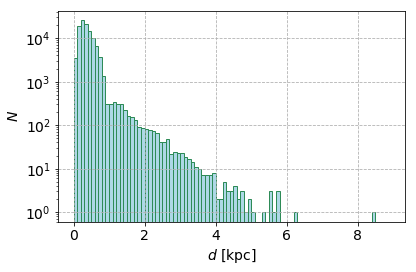

In [359]:
fig=p.figure(figsize=(6,4))
data = ds.evaluate('best_distance')
p.grid(ls='dashed')
p.hist(data, bins=arange(0,9,0.1), histtype='bar', edgecolor='seagreen', color='lightblue')
p.yscale('log')
p.xlabel(r'$d$ [kpc]'), p.ylabel(r'$N$')
fig.tight_layout()
fig.savefig('/net/virgo01/data/users/virgini/rockstar/RC3/output/Report/distance.png', format='png')
p.show()

#### Parallax

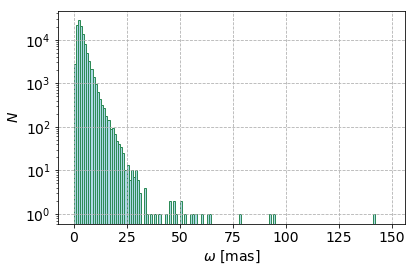

In [1100]:
fig=p.figure(figsize=(6,4))
data = ds.evaluate('best_parallax')
p.grid(ls='dashed')
p.hist(data, bins=arange(0,150,1), histtype='bar', edgecolor='seagreen', color='lightblue')
p.yscale('log')
p.xlabel(r'$\omega$ [mas]'), p.ylabel(r'$N$')
fig.tight_layout()
fig.savefig('/net/virgo01/data/users/virgini/rockstar/RC3/output/Report/parallax.png', format='png')
p.show()

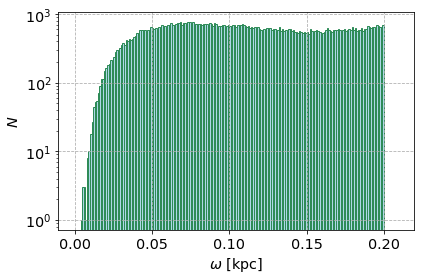

In [326]:
fig=p.figure(figsize=(6,4))
data = ds.evaluate('best_parallax_error/best_parallax')
p.grid(ls='dashed')
p.hist(data, bins=arange(0,0.21,0.001), histtype='bar', edgecolor='seagreen', color='lightblue')
p.yscale('log')
p.xlabel(r'$\omega$ [kpc]', fontsize='x-large'), p.ylabel(r'$N$', fontsize='x-large')
p.xticks(fontsize='x-large'), p.yticks(fontsize='x-large')
fig.tight_layout()
fig.savefig('/net/virgo01/data/users/virgini/rockstar/RC3/output/Report/eparallax.png', format='png')
p.show()

In [1103]:
len(ds.data.eHRV[ds.data.eHRV<2])/len(ds.data.eHRV)

0.8188879503470564

#### G magnitude

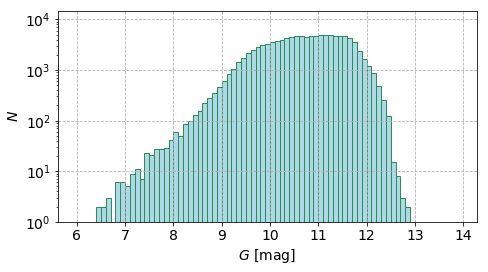

In [447]:
fig=p.figure(figsize=(7,4))
data = ds.evaluate('phot_g_mean_mag')
p.grid(ls='dashed')
p.hist(data, bins=arange(6,14,0.1), histtype='bar', edgecolor='seagreen', color='lightblue')
p.yscale('log')
p.ylim(0,15000)
p.xlabel(r'$G$ [mag]'), p.ylabel(r'$N$')
fig.tight_layout()
fig.savefig('/net/virgo01/data/users/virgini/rockstar/RC3/output/Report/magnitude.png', format='png')
p.show()

#### HR Diagram

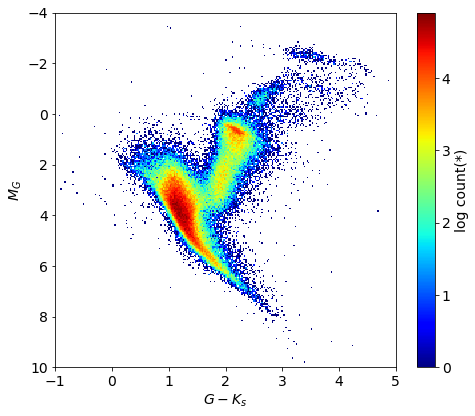

In [367]:
fig=p.figure(figsize=(7,6))
ds.plot('phot_g_mean_mag - Kmag_2MASS', 'G', f='log', limits=[[-1,5],[10,-4]], colormap='jet')
p.xlabel(r'$G - K_s$'), p.ylabel(r'$M_G$')
# p.xticks(fontsize='x-large'), p.yticks(fontsize='x-large')
fig.tight_layout()
fig.savefig('/net/virgo01/data/users/virgini/rockstar/RC3/output/Report/hrdiagram.png', format='png')
p.show()

#### Radial Velocity

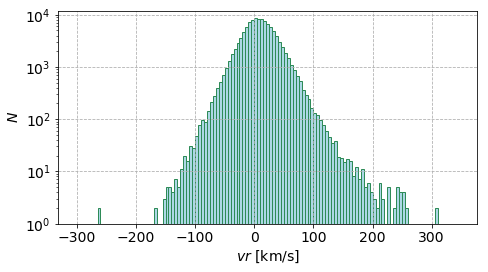

In [439]:
fig = p.figure(figsize=(7,4))
data = ds.evaluate('HRV')
p.grid(ls='dashed')
p.hist(data, bins=arange(-300,350,5), histtype='bar', edgecolor='seagreen', color='lightblue')
p.yscale('log')
p.ylim(0,12000)
p.xlabel(r'$vr$ [km/s]'), p.ylabel(r'$N$')
fig.tight_layout()
fig.savefig('/net/virgo01/data/users/virgini/rockstar/RC3/output/Report/vr.png', format='png')
p.show()

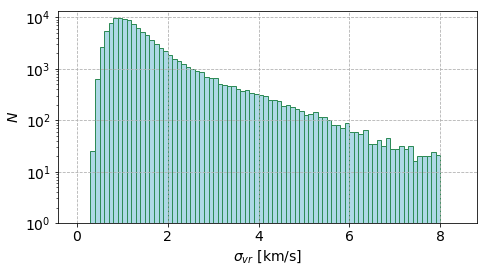

In [396]:
fig=p.figure(figsize=(7,4))
data = ds.evaluate('eHRV')
p.grid(ls='dashed')
p.hist(data, bins=arange(0,8.5,0.1), histtype='bar', edgecolor='seagreen', color='lightblue')
p.yscale('log')
p.yticks([1, 10, 1e2, 1e3, 1e4], [r'$10^0$', r'$10^1$', r'$10^2$', r'$10^3$', r'$10^4$'])
p.xlabel(r'$\sigma_{vr}$ [km/s]'), p.ylabel(r'$N$')
fig.tight_layout()
fig.savefig('/net/virgo01/data/users/virgini/rockstar/RC3/output/Report/vr_e.png', format='png')
p.show()

#### Proper motions

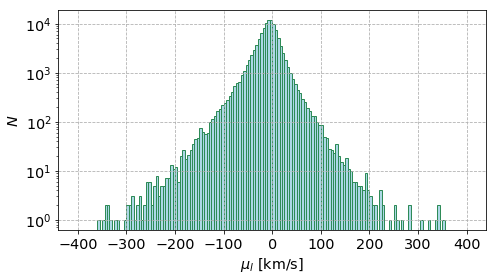

In [319]:
fig=p.figure(figsize=(7,4))
data = ds.evaluate('pm_l')
p.grid(ls='dashed')
p.hist(data, bins=arange(-400,405,5), histtype='bar', edgecolor='seagreen', color='lightblue')
p.yscale('log')
# p.ylim(0,100000)
p.xlabel(r'$\mu_{l}$ [km/s]', fontsize='x-large'), p.ylabel(r'$N$', fontsize='x-large')
p.xticks(fontsize='x-large'), p.yticks(fontsize='x-large')
fig.tight_layout()
fig.savefig('/net/virgo01/data/users/virgini/rockstar/RC3/output/Report/pml', format='png')
p.show()

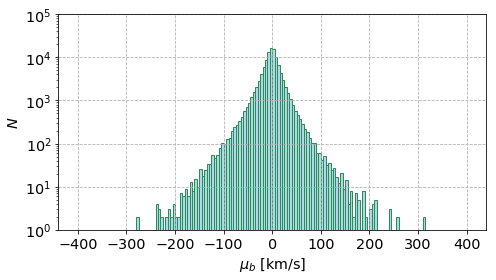

In [310]:
fig=p.figure(figsize=(7,4))
data = ds.evaluate('pm_b')
p.grid(ls='dashed')
p.hist(data, bins=arange(-400,405,5), histtype='bar', edgecolor='seagreen', color='lightblue')
p.yscale('log')
p.ylim(0,100000)
p.xlabel(r'$\mu_{b}$ [km/s]', fontsize='x-large'), p.ylabel(r'$N$', fontsize='x-large')
p.xticks(fontsize='x-large'), p.yticks(fontsize='x-large')
fig.tight_layout()
fig.savefig('/net/virgo01/data/users/virgini/rockstar/RC3/output/Report/pmb', format='png')
p.show()

#### Space distribution

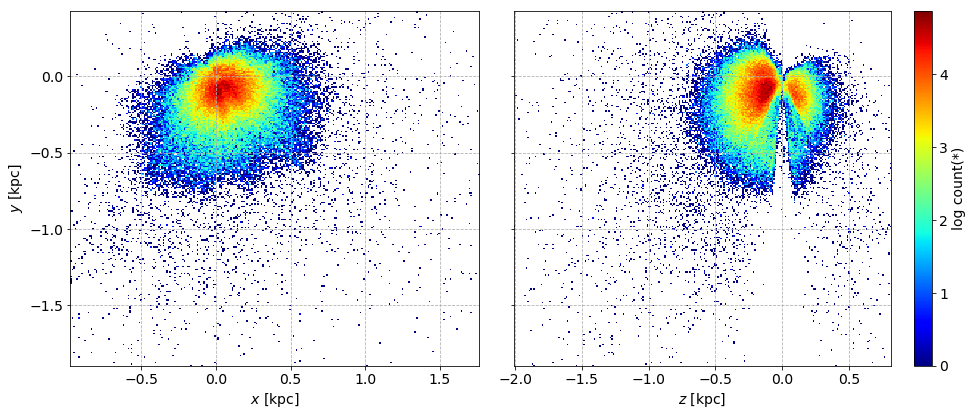

In [886]:
fig = p.figure(figsize=(14,6))
gs = p.GridSpec(nrows=1, ncols=2, width_ratios=[1,1.15])
fig.add_subplot(gs[0])
p.grid(ls='dashed')
ds.plot('x', 'y', f='log', colorbar=False, colormap='jet', shape=256)
p.xlabel(r'$x$ [kpc]'), p.ylabel(r'$y$ [kpc]')
p.title(' ')
fig.add_subplot(gs[1])
p.grid(ls='dashed')
ds.plot('z', 'y', f='log', colormap='jet')
p.xlabel(r'$z$ [kpc]'), p.ylabel('')
p.yticks(visible=False)
fig.tight_layout()
fig.savefig('/net/virgo01/data/users/virgini/rockstar/RC3/output/Report/xyz.png', format='png')
p.show()

#### Error in positions

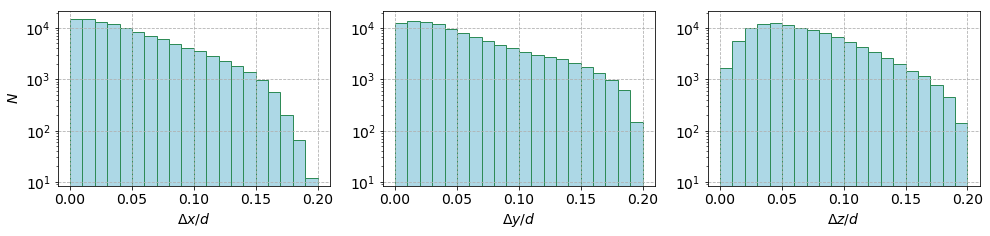

In [1248]:
fig = p.figure(figsize=(14,3.5))
fig.add_subplot(131)
data = ds.evaluate('x_uncertainty/best_distance')
p.grid(ls='dashed')
p.hist(data, bins=arange(0,0.21,0.01), histtype='bar', edgecolor='seagreen', color='lightblue')
p.yscale('log')
p.xlabel(r'$\Delta x / d$'), p.ylabel(r'$N$')
fig.add_subplot(132)
data = ds.evaluate('x_uncertainty/best_distance')
p.hist(data, bins=arange(0,0.21,0.01), visible=False)
data = ds.evaluate('y_uncertainty/best_distance')
p.grid(ls='dashed')
p.hist(data, bins=arange(0,0.21,0.01), histtype='bar', edgecolor='seagreen', color='lightblue')
p.yscale('log')
p.xlabel(r'$\Delta y/d$')
fig.add_subplot(133)
data = ds.evaluate('x_uncertainty/best_distance')
p.hist(data, bins=arange(0,0.21,0.01), visible=False)
data = ds.evaluate('z_uncertainty/best_distance')
p.grid(ls='dashed')
p.hist(data, bins=arange(0,0.21,0.01), histtype='bar', edgecolor='seagreen', color='lightblue')
p.yscale('log')
p.xlabel(r'$\Delta z/d$')
fig.tight_layout()
fig.savefig('/net/virgo01/data/users/virgini/rockstar/RC3/output/Report/xyz-error.png', format='png')
p.show()

In [1172]:
len(ds.data.x[(ds.data.vy<0)])/len(ds)

0.7976422196922399

#### Space motions

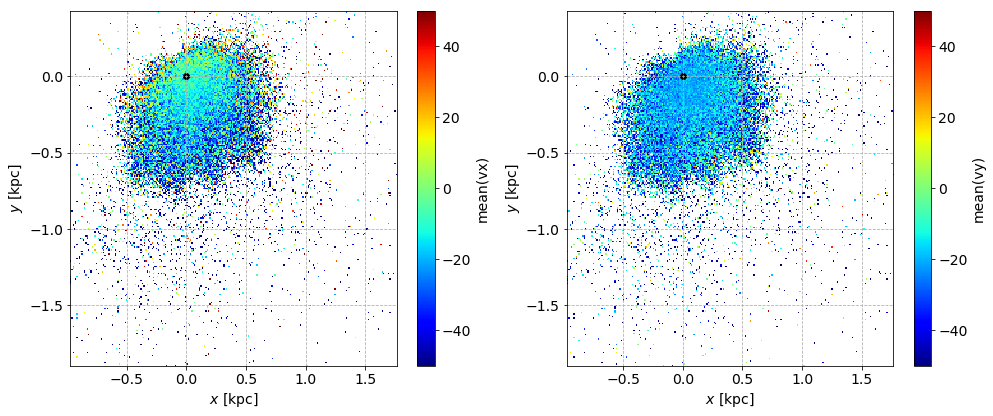

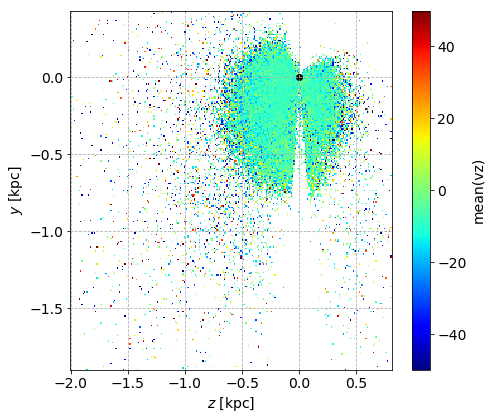

In [1119]:
fig=p.figure(figsize=(14,6))
fig.add_subplot(121)
p.grid(ls='dashed')
ds.plot('x', 'y', what='mean(vx)', colormap='jet', vmin=-50, vmax=50, shape=256)
p.scatter(0,0, c='k')
p.xlabel(r'$x$ [kpc]'), p.ylabel(r'$y$ [kpc]')
fig.add_subplot(122)
p.grid(ls='dashed')
ds.plot('x', 'y', what='mean(vy)', colormap='jet', vmin=-50, vmax=50, shape=256)
p.scatter(0,0, c='k')
p.xlabel(r'$x$ [kpc]'), p.ylabel(r'$y$ [kpc]')
fig.tight_layout()
fig.savefig('/net/virgo01/data/users/virgini/rockstar/RC3/output/Report/xyz-velocity.png', format='png')
p.show()

fig=p.figure(figsize=(7,6))
p.grid(ls='dashed')
ds.plot('z', 'y', what='mean(vz)', colormap='jet', vmin=-50, vmax=50, shape=256)
p.scatter(0,0, c='k')
p.xlabel(r'$z$ [kpc]'), p.ylabel(r'$y$ [kpc]')
p.grid(ls='dashed')
fig.savefig('/net/virgo01/data/users/virgini/rockstar/RC3/output/Report/xyz-velocity2.png', format='png')
p.show()


#### Sky pleiades

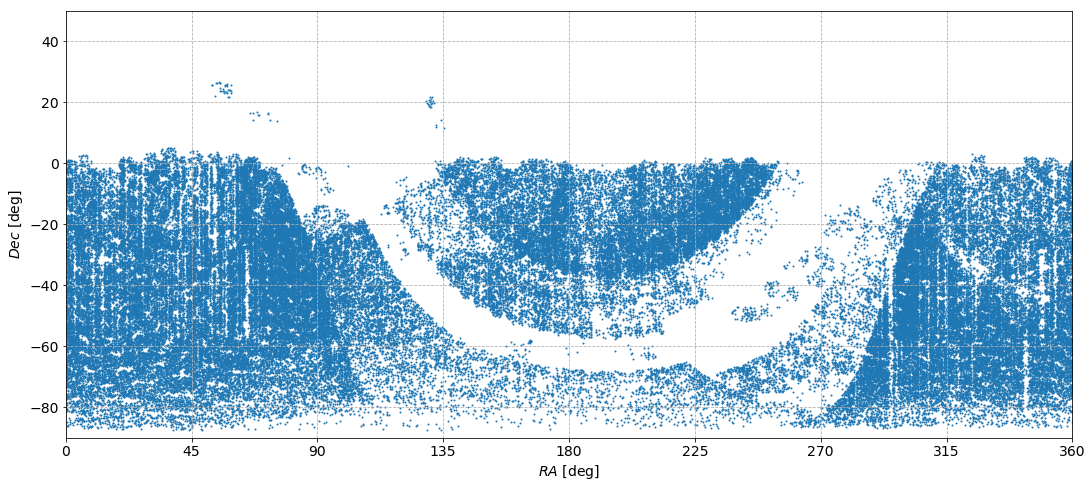

In [1207]:
fig=p.figure(figsize=(14,7))
p.grid(ls='dashed')
ds.scatter('ra', 'dec', s=1, length_check=False)
p.xlabel(r'$RA$ [deg]'), p.ylabel(r'$Dec$ [deg]')
p.xlim(0,360), p.ylim(-90,50)
p.xticks(arange(0,360+45,45))
fig.tight_layout(rect=[0,0,1.1,1])
fig.savefig('/net/virgo01/data/users/virgini/rockstar/RC3/output/Report/sky-pleiades.png', format='png')
p.show()

#### Error in velocity

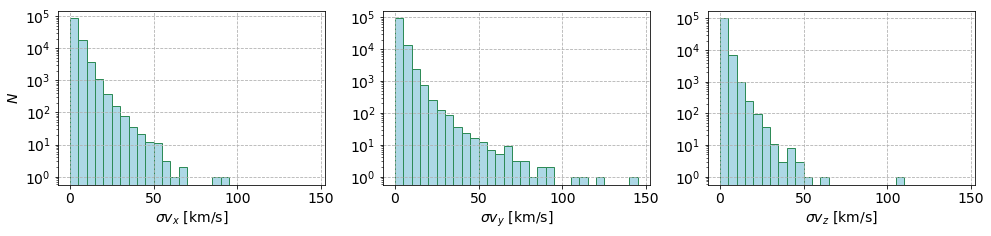

In [1249]:
fig = p.figure(figsize=(14,3.5))
fig.add_subplot(131)
data = ds.evaluate('vx_uncertainty')
p.grid(ls='dashed')
p.hist(data, bins=arange(0,150,5), histtype='bar', edgecolor='seagreen', color='lightblue')
p.yscale('log')
p.xlabel(r'$\sigma v_x$ [km/s]'), p.ylabel(r'$N$')
fig.add_subplot(132)
data = ds.evaluate('vy_uncertainty')
p.grid(ls='dashed')
p.hist(data, bins=arange(0,150,5), histtype='bar', edgecolor='seagreen', color='lightblue')
p.yscale('log')
p.xlabel(r'$\sigma v_y$ [km/s]')
fig.add_subplot(133)
data = ds.evaluate('vz_uncertainty')
p.grid(ls='dashed')
p.hist(data, bins=arange(0,150,5), histtype='bar', edgecolor='seagreen', color='lightblue')
p.yscale('log')
p.xlabel(r'$\sigma v_z$ [km/s]')
fig.tight_layout()
fig.savefig('/net/virgo01/data/users/virgini/rockstar/RC3/output/Report/xyz-vel-error.png', format='png')
p.show()

In [1327]:
# Plot CMD, vector point diagram, metallicity

id_1 = [100, 145, 204, 206, 207, 210, 213]
id_2 = [205, 206, 208, 209, 211, 212, 213, 215, 218]
id_3 = [1, 2, 3, 4, 5, 7, 10, 13, 17, 18, 22, 25, 28, 35]
id_4 = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23, 26, 29, 31, 34, 42, 43]

id_all = [id_1, id_2, id_3, id_4]
exp    = ['1.', '2.', '3.', '4.']
select = ['exp1==%s', 'exp2==%s', 'exp3==%s', 'exp4==%s']
folder = '/net/virgo01/data/users/virgini/rockstar/RC3/output/Report/'
gs1 = p.GridSpec(nrows=3, ncols=1)
gs2 = p.GridSpec(nrows=3, ncols=2)

tmp_pdf = '/net/virgo01/data/users/virgini/rockstar/RC3/output/Report/Experiment_try.pdf'
with PdfPages(tmp_pdf) as pdf:

    for j in [2]: #range(4):
        for i in tqdm([1], desc='Loading'):

            ds.select(select[j]  %i, name='sub')

            # from which experiment
            flag = exp[j]+str(i)

            # data of tgas-rave stars
            n = ds.selected_length(selection='sub')
            l = ds.evaluate('l', selection='sub')
            b = ds.evaluate('b', selection='sub')
            pm_l = ds.evaluate('pm_l', selection='sub')
            pm_b = ds.evaluate('pm_b', selection='sub')
            parallax = ds.evaluate('best_parallax', selection='sub')
            relative_parallax_error = ds.evaluate('best_parallax_error/best_parallax', selection='sub')

            # median position on the sky
            l_med = median(ds.evaluate('l', selection='sub'))
            b_med = median(ds.evaluate('b', selection='sub'))
            pm_l_med = median(ds.evaluate('pm_l', selection='sub'))
            pm_b_med = median(ds.evaluate('pm_b', selection='sub'))

            # radius containing 100% and 68% of members
            D = ds.evaluate('arccos(sin(deg2rad(b))*sin(%s) + cos(deg2rad(b))*cos(%s)*cos(abs(deg2rad(l)-(%s))))'\
                             %(deg2rad(b_med), deg2rad(b_med), deg2rad(l_med)), selection='sub')
            R = sort(D)
            r = max(R)

            # define selection in TGASxRAVE dataset based on position in l and b (and positive distance)
            ds.select('(arccos(sin(deg2rad(b))*sin(%s) + cos(deg2rad(b))*cos(%s)*cos(abs(deg2rad(l)-(%s)))) <= %s)\
                      & (best_distance>=0)' %(deg2rad(b_med), deg2rad(b_med), deg2rad(l_med), r), name='position')

            # define selection in TGASxRAVE dataset based on proper motion
            ds.select('(abs(pm_l - %s)/%s <= 1) & (abs(pm_b - %s)/%s <= 1)' %(str('%.55f' %median(pm_l)),\
                      str('%.55f' %std(pm_l)), str('%.55f' %median(pm_b)), str('%.55f' %std(pm_b))), name='motion')

            # define selection in TGAS dataset based on parallax
            ds.select('(abs(best_parallax - %s) / sqrt(best_parallax_error**2 + %s)) <= 1' \
                      %(str('%.55f' %median(parallax)), str('%.55f' %(std(parallax)**2))), name='par')

            fig = p.figure(figsize=(14, 20))

            ax = fig.add_subplot(gs1[0])
            p.title(('Experiment %s - Substructure %s' %(j+1, i)))
            line1 = p.scatter(l, b, s=7)
            p.xlim(0,360), p.ylim(-90,90)
            p.xlabel(r'$l$ [deg]'), p.ylabel(r'$b$ [deg]')
            p.xlim(0,360)
            p.ylim(-90,90)
            ticks = ax.get_xticks()
            ticks[ticks < 0] += 360
            ax.set_xticklabels([int(tick) for tick in ticks])

            fig.add_subplot(gs2[2])
            line3 = ds.scatter('pm_l', 'pm_b', s=3, c='lightgrey', selection='position', length_check=False)
            line1 = ds.scatter('pm_l', 'pm_b', s=7, selection='sub')
            p.xlabel(r'$\mu_l$ [mas/yr]'), p.ylabel(r'$\mu_b$ [mas/yr]')
            limit = 150
            p.xlim(-limit, limit), p.ylim(-limit, limit)
            p.axvline(0, ls='dashed', c='k')
            p.axhline(0, ls='dashed', c='k')

            fig.add_subplot(gs2[3])
            line3 = ds.scatter('G - K', 'G', s=3, c='lightgrey', selection='position', length_check=False)
            line1 = ds.scatter('G - K', 'G', s=7, selection='sub')
            p.xlabel(r'$G - K$'), p.ylabel(r'$M_G$')
            p.xlim(-1,5), p.ylim(9, -3)

            fig.add_subplot(gs2[4])
            bins = arange(0,15,0.5)
            line1 = p.hist(parallax, histtype='step', bins=bins)
            p.xlabel(r'$\omega$ [mas]'), p.ylabel(r'$N$')

            fig.add_subplot(gs2[5])
            bins = arange(0,1.1,0.05)
            line1 = p.hist(relative_parallax_error, histtype='step', bins=bins)
            p.xlabel(r'$\Delta \omega / \omega$'), p.ylabel(r'$N$')

            fig.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])
#             name = os.path.join(folder + 'sky-' + str(j+1) + '-' + str(i) + '.png')
#             fig.savefig(name, format='png')
            pdf.savefig(fig)
            p.close()

print('finish')
# print('Substructure', flag, '|', n_member+n_add, 'stars')

Loading: 100%|██████████| 1/1 [00:02<00:00,  2.68s/it]

finish


In [1341]:
# Plot CMD, vector point diagram, metallicity

id_1 = [100, 145, 204, 206, 207, 210, 213]
id_2 = [205, 206, 208, 209, 211, 212, 213, 215, 218]
id_3 = [1, 2, 3, 4, 5, 7, 10, 13, 17, 18, 22, 25, 28, 35]
id_4 = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23, 26, 29, 31, 34, 42, 43]

id_all = [id_1, id_2, id_3, id_4]
exp    = ['1.', '2.', '3.', '4.']
select = ['exp1==%s', 'exp2==%s', 'exp3==%s', 'exp4==%s']
folder = '/net/virgo01/data/users/virgini/rockstar/RC3/output/Report/'
gs1 = p.GridSpec(nrows=3, ncols=1)
gs2 = p.GridSpec(nrows=3, ncols=2)

# tmp_pdf = '/net/virgo01/data/users/virgini/rockstar/RC3/output/Report/Field_stars.pdf'
# with PdfPages(tmp_pdf) as pdf:

for j in range(4):
    for i in tqdm(id_all[j], desc='Loading'):

        ds.select(select[j]  %i, name='sub')

        # from which experiment
        flag = exp[j]+str(i)

        # data of tgas-rave stars
        n = ds.selected_length(selection='sub')
        l = ds.evaluate('l', selection='sub')
        b = ds.evaluate('b', selection='sub')
        pm_l = ds.evaluate('pm_l', selection='sub')
        pm_b = ds.evaluate('pm_b', selection='sub')
        parallax = ds.evaluate('best_parallax', selection='sub')
        relative_parallax_error = ds.evaluate('best_parallax_error/best_parallax', selection='sub')

        # median position on the sky
        l_med = median(ds.evaluate('l', selection='sub'))
        b_med = median(ds.evaluate('b', selection='sub'))
        pm_l_med = median(ds.evaluate('pm_l', selection='sub'))
        pm_b_med = median(ds.evaluate('pm_b', selection='sub'))

        # radius containing 100% and 68% of members
        D = ds.evaluate('arccos(sin(deg2rad(b))*sin(%s) + cos(deg2rad(b))*cos(%s)*cos(abs(deg2rad(l)-(%s))))'\
                         %(deg2rad(b_med), deg2rad(b_med), deg2rad(l_med)), selection='sub')
        R = sort(D)
        r = max(R)

        # define selection in TGASxRAVE dataset based on position in l and b (and positive distance)
        ds.select('(arccos(sin(deg2rad(b))*sin(%s) + cos(deg2rad(b))*cos(%s)*cos(abs(deg2rad(l)-(%s)))) <= %s)\
                  & (best_distance>=0)' %(deg2rad(b_med), deg2rad(b_med), deg2rad(l_med), r), name='position')
        
        n_field = len(ds.evaluate('l', selection='position'))

        fig = p.figure(figsize=(14, 7))

        p.title(('Experiment %s - Substructure %s' %(j+1, i)))
        line2 = ds.scatter('l', 'b', s=7, selection='position', c='lightgrey', length_check=False)
        line1 = ds.scatter('l', 'b', s=20, selection='sub', c='blue')
        p.xlabel(r'$l$ [deg]'), p.ylabel(r'$b$ [deg]')
        p.legend([line1, line2], ['member stars (%s)' %n, 'field stars (%s)' %n_field], loc='upper left')

        fig.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])
        name = os.path.join(folder + 'field-' + str(j+1) + '-' + str(i) + '.png')
        fig.savefig(name, format='png')
#         pdf.savefig(fig)
#         p.show()
        p.close()

print('finish')
# print('Substructure', flag, '|', n_member+n_add, 'stars')

Loading: 100%|██████████| 27/27 [00:09<00:00,  2.95it/s]

finish


In [1312]:
median(dm.data.vel)

4.9733213545000003

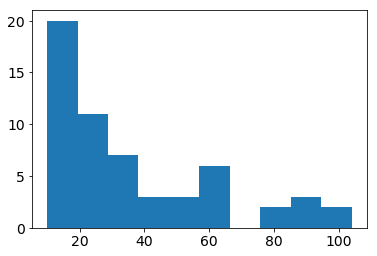

In [1304]:
p.hist(dm.data.n_star)
p.show()

In [1299]:
id_1 = [100, 145, 204, 206, 207, 210, 213]
id_2 = [205, 206, 208, 209, 211, 212, 213, 215, 218]
id_3 = [1, 2, 3, 4, 5, 7, 10, 13, 17, 18, 22, 25, 28, 35]
id_4 = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23, 26, 29, 31, 34, 42, 43]

id_all = [id_1, id_2, id_3, id_4]
exp    = ['1.', '2.', '3.', '4.']
select = ['exp1==%s', 'exp2==%s', 'exp3==%s', 'exp4==%s']

for j in range(4):
    for i in tqdm(id_all[j]):
        ds.select(select[j]  %i, name='sub')
        a = ds.evaluate('vx_uncertainty', selection='sub').max()
        b = ds.evaluate('vy_uncertainty', selection='sub').max()
        c = ds.evaluate('vz_uncertainty', selection='sub').max()
        print(a,b,c)

100%|██████████| 27/27 [00:00<00:00, 1372.56it/s]

3.61044443481 2.79650690209 1.59424761598
3.73262810156 1.88482991748 3.72808832389
1.72230211045 1.3465424681 1.87342719148
2.93340446521 2.91284323711 2.24408926619
3.57234770877 5.8501572046 2.88101388269
3.71541117899 1.76509522589 5.62798425566
2.35817434958 2.81725892667 2.92352628702
3.94314935473 3.44821075042 3.62678788764
3.32516054836 3.8764660328 3.81986958179
1.7231090095 1.59678997817 1.65258150972
2.81431747668 2.99966907677 2.84888059421
1.76464437942 4.01538779499 3.17981415566
2.84402794936 2.76896475355 1.78936053027
5.42284883995 5.08748588555 4.66771099594
1.90251346039 3.72106813593 2.72507101108
2.41980986615 1.55321832996 1.75856231322
2.05675165583 4.132177223 3.63608615314
6.56183044444 4.39049190459 2.92615875289
4.19659371438 5.176985762 4.80781610352
5.54216768877 3.7209031739 5.04632484223
3.17526369955 4.11865597443 3.38488069616
5.23365862913 3.86472168191 4.08708556262
6.87343314778 5.58539907592 3.59344252897
2.33880839351 2.67039147347 5.62934454666
4

## All substructures in the sky (l and b)

In [ ]:
tmp_pdf = '/net/virgo01/data/users/virgini/rockstar/RC3/output/SkyLB.pdf'
with PdfPages(tmp_pdf) as pdf:
    
    fig = p.figure(figsize=(14, 7))
    n_sub = int(max(ds.data.exp1[~isnan(ds.data.exp1)]))
    ds.scatter('l', 'b', s=1, c='lightgray',  length_check=False)
    for n in range(n_sub):
        ds.select('exp1 == %s' %n, name='sub')
        ds.scatter('l', 'b', s=3, selection='sub', length_check=False)
    p.title('Experiment 1')
    p.grid(linestyle='dashed')
    p.xlim(0,360), p.ylim(-90,90)
    fig.tight_layout()
    pdf.savefig()
#     fig.savefig('/net/virgo01/data/users/virgini/rockstar/RC3/output/Sky-LB-1.png', format='png')
    pdf.savefig()
#     p.show()

    fig = p.figure(figsize=(14, 7))
    n_sub = int(max(ds.data.exp2[~isnan(ds.data.exp2)]))
    ds.scatter('l', 'b', s=1, c='lightgray',  length_check=False)
    for n in range(n_sub):
        ds.select('exp2 == %s' %n, name='sub')
        ds.scatter('l', 'b', s=3, selection='sub', length_check=False)
    p.title('Experiment 2')
    p.grid(linestyle='dashed')
    p.xlim(0,360), p.ylim(-90,90)
    fig.tight_layout()
    pdf.savefig()
#     fig.savefig('/net/virgo01/data/users/virgini/rockstar/RC3/output/Sky-LB-2.png', format='png')
    # p.show()

    fig = p.figure(figsize=(14, 7))
    n = int(max(ds.data.exp3[~isnan(ds.data.exp3)]))
    n_dump =[26] #list of indices to be ignored
    n_sub = [ind for ind in range(n) if ind not in n_dump]
    ds.scatter('l', 'b', s=1, c='lightgray',  length_check=False)
    for i in n_sub:
        ds.select('exp3 == %s' %i, name='sub')
        ds.scatter('l', 'b', s=3, selection='sub', length_check=False)
    p.title('Experiment 3')
    p.grid(linestyle='dashed')
    p.xlim(0,360), p.ylim(-90,90)
    fig.tight_layout()
    pdf.savefig()
#     fig.savefig('/net/virgo01/data/users/virgini/rockstar/RC3/output/Sky-LB-3.png', format='png')
    # p.show()

    fig = p.figure(figsize=(14, 7))
    n = int(max(ds.data.exp4[~isnan(ds.data.exp4)]))
    n_dump =[28] #list of indices to be ignored
    n_sub = [ind for ind in range(n) if ind not in n_dump]
    ds.scatter('l', 'b', s=1, c='lightgray',  length_check=False)
    for i in n_sub:
        ds.select('exp4 == %s' %i, name='sub')
        ds.scatter('l', 'b', s=3, selection='sub', length_check=False)
    p.title('Experiment 4')
    p.grid(linestyle='dashed')
    p.xlim(0,360), p.ylim(-90,90)
    fig.tight_layout()
    pdf.savefig()
#     fig.savefig('/net/virgo01/data/users/virgini/rockstar/RC3/output/Sky-LB-4.png', format='png')
    # p.show()


## All substructures in the sky (ra and dec)

In [ ]:
fig = p.figure(figsize=(14, 7))
n_sub = int(max(ds.data.exp1[~isnan(ds.data.exp1)]))
ds.scatter('ra', 'dec', s=1, c='lightgray',  length_check=False)
for n in range(n_sub):
    ds.select('exp1 == %s' %n, name='sub')
    ds.scatter('ra', 'dec', s=3, selection='sub', length_check=False)
p.title('Experiment 1')
p.grid(linestyle='dashed')
p.xlim(0,360), p.ylim(-90,40)
fig.tight_layout()
fig.savefig('/net/virgo01/data/users/virgini/rockstar/RC3/output/Sky-RaDec-1.png', format='png')

fig = p.figure(figsize=(14, 7))
n_sub = int(max(ds.data.exp2[~isnan(ds.data.exp2)]))
ds.scatter('ra', 'dec', s=1, c='lightgray',  length_check=False)
for n in range(n_sub):
    ds.select('exp2 == %s' %n, name='sub')
    ds.scatter('ra', 'dec', s=3, selection='sub', length_check=False)
p.title('Experiment 2')
p.grid(linestyle='dashed')
p.xlim(0,360), p.ylim(-90,40)
fig.tight_layout()
fig.savefig('/net/virgo01/data/users/virgini/rockstar/RC3/output/Sky-RaDec-2.png', format='png')

fig = p.figure(figsize=(14, 7))
n = int(max(ds.data.exp3[~isnan(ds.data.exp3)]))
n_dump =[26] #list of indices to be ignored
n_sub = [ind for ind in range(n) if ind not in n_dump]
ds.scatter('ra', 'dec', s=1, c='lightgray',  length_check=False)
for i in n_sub:
    ds.select('exp3 == %s' %i, name='sub')
    ds.scatter('ra', 'dec', s=3, selection='sub', length_check=False)
p.title('Experiment 3')
p.grid(linestyle='dashed')
p.xlim(0,360), p.ylim(-90,40)
fig.tight_layout()
fig.savefig('/net/virgo01/data/users/virgini/rockstar/RC3/output/Sky-RaDec-3.png', format='png')

fig = p.figure(figsize=(14, 7))
n = int(max(ds.data.exp4[~isnan(ds.data.exp4)]))
n_dump =[28] #list of indices to be ignored
n_sub = [ind for ind in range(n) if ind not in n_dump]
ds.scatter('ra', 'dec', s=1, c='lightgray',  length_check=False)
for i in n_sub:
    ds.select('exp4 == %s' %i, name='sub')
    ds.scatter('ra', 'dec', s=3, selection='sub', length_check=False)
p.title('Experiment 4')
p.grid(linestyle='dashed')
p.xlim(0,360), p.ylim(-90,40)
fig.tight_layout()
fig.savefig('/net/virgo01/data/users/virgini/rockstar/RC3/output/Sky-RaDec-4.png', format='png')

p.show(fig)

## Comparison of experiment 1-2 and 3-4

In [1355]:
com12 = '/net/virgo01/data/users/virgini/rockstar/RC3/output/common-b05-f40-b20-f40'          # !!! Change this
# com12 = '/net/virgo01/data/users/virgini/rockstar/RC3/output/common-b05-f40-b20-f80'
hdr = ['sub_id_1', 'sub_id_2', 'np_1', 'np_2', 'np_common', 'percent_1', 'percent_2']

df  = pd.read_csv(com12, sep=' ', comment='#', names=hdr)
# exp12 = array(df.sub_id_1[(df.percent_1 == 100) & (df.percent_2 == 100)])

In [1361]:
df[df.np_2<]

,sub_id_1,sub_id_2,np_1,np_2,np_common,percent_1,percent_2
298,90,9,25,1036,1,4,0
303,91,9,12,1036,1,8,0
306,92,9,51,1036,8,15,0
480,140,9,214,1036,7,3,0
487,141,9,24,1036,7,29,0
491,142,9,16,1036,7,43,0
493,143,9,27,1036,10,37,0
495,144,9,10,1036,1,10,0
531,155,9,17,1036,3,17,0
535,156,9,45,1036,3,6,0


In [ ]:
pp = PdfPages('/net/virgo01/data/users/virgini/rockstar/RC3/output/Exp12-pos-vel-100.pdf')     # !!! Change this

box = 0.15
for i in tqdm(exp12, desc='Loading...'):
    fig = p.figure(figsize=(12,6))
    gs  = p.GridSpec(nrows=1, ncols=2)
    gs.wspace=0
    
    ds.select('exp1 == %s' %i, name='sub')                      # !!! Change this
    medx = median(ds.evaluate('x', selection='sub'))
    medy = median(ds.evaluate('y', selection='sub'))
    medz = median(ds.evaluate('z', selection='sub'))
    tmpx  = ds.evaluate('x', selection='sub')                           
    tmpy  = ds.evaluate('y', selection='sub')
    tmpz  = ds.evaluate('z', selection='sub')
    tmpvx = ds.evaluate('vx', selection='sub') / 1000
    tmpvy = ds.evaluate('vy', selection='sub') / 1000
    tmpvz = ds.evaluate('vz', selection='sub') / 1000  
    
    fig.add_subplot(gs[0])
    for j in range(ds.selected_length('sub')):
        p.arrow(tmpx[j], tmpy[j], dx=tmpvx[j], dy=tmpvy[j], width=0, head_width=0.002, ec='grey', fc='grey', zorder=1)
    ds.scatter('x', 'y', c='black', s=20, selection='sub', zorder=2)
    p.scatter(medx, medy, s=100, c='red', marker='+', zorder=3)
    p.text(medx-0.13, medy+0.13, 'Sub 1.%s' %i)                                          # !!! Change this
    p.text(medx-0.13, medy+0.12, '%s Stars' %(ds.selected_length('sub')))
    p.text(medx-0.13, medy+0.11, 'Exp 1 & 2')                                            # !!! Change this
    p.xlim(medx-box, medx+box), p.ylim(medy-box, medy+box)
    p.xlabel('x [kpc]', fontsize='large'), p.ylabel('y [kpc]', fontsize='large')
    p.gca().add_patch(p.Circle((medx, medy), radius=0.05, ec='red', fc='none'))
    p.gca().add_patch(p.Circle((medx, medy), radius=0.1, ec='blue', fc='none'))
    p.xticks(size='large'), p.yticks(size='large')
    
    
    fig.add_subplot(gs[1])
    for j in range(ds.selected_length('sub')):
        p.arrow(tmpz[j], tmpy[j], dx=tmpvz[j], dy=tmpvy[j], width=0, head_width=0.002, ec='grey', fc='grey', zorder=1)
    ds.scatter('z', 'y', c='black', s=20, selection='sub', zorder=2)
    p.scatter(medz, medy, s=100, c='red', marker='+', zorder=3)
    p.text(medz+0.1, medy+0.13, 'r = 50 pc', color='red')
    p.text(medz+0.1, medy+0.12, 'r = 100 pc', color='blue')
    p.xlim(medz-box, medz+box), p.ylim(medy-box, medy+box)
    p.xlabel('z [kpc]', fontsize='large'), p.ylabel('y [kpc]', visible=False)
    p.gca().add_patch(p.Circle((medz, medy), radius=0.05, ec='red', fc='none'))
    p.gca().add_patch(p.Circle((medz, medy), radius=0.1, ec='blue', fc='none'))
    p.yticks(visible=False), p.xticks(size='large')
    
    fig.tight_layout()
    pp.savefig(fig)
    p.close()
    
pp.close()

In [ ]:
pp = PdfPages('/net/virgo01/data/users/virgini/rockstar/RC3/output/cmd-met-exp34-100')       # !!! Change this

xmin, xmax = -2, 1.2
bins = arange(xmin,xmax,0.2)

for i in tqdm(exp12, desc='Loading...'):
# for i in [0,1,2]:
    fig = p.figure(figsize=(12,6))
    gs  = p.GridSpec(nrows=1, ncols=2)
    
    ds.select('exp3 == %s' %i, name='sub')             # !!! Change this
    
    fig.add_subplot(gs[0])
    ds.plot('G - K', 'G', f='log', limits=[[-1,4],[-2,10]], colormap='Greys', colorbar=False)
    ds.scatter('G - K', 'G', s=7, selection='sub', c='red', length_check=False)
    p.title(' ')
    p.xlim(-1,4), p.ylim(-2, 10)
    p.gca().invert_yaxis()
    p.text(-0.85, -1.4, 'Sub 3.%s' %i)                                  # !!! Change this
    p.text(-0.85, -0.9, '%s Stars' %(ds.selected_length('sub')))
    p.text(-0.85, -0.4, 'Exp 3 & 4')                                    # !!! Change this

    fig.add_subplot(gs[1])
    tmp = ds.evaluate('Met_K', selection='sub')
    tmp = tmp[~isnan(tmp)]
    p.hist(tmp, bins=bins, histtype='step', label='Met_K = %s $\pm$ %s' %(round(tmp.mean(), 3), round(tmp.std(), 2)))
    p.legend(loc='upper left', frameon=False)
    
    fig.tight_layout()
    pp.savefig()
#     p.show()
    p.close()
pp.close()

## Each experiment (only 3 and 4 of interest)

In [ ]:
# pp = PdfPages('/net/virgo01/data/users/virgini/rockstar/RC3/output/Exp4-pos-vel.pdf')     # !!! Change this

box = 0.15
nsub = int(ds.data.exp4[~isnan(ds.data.exp4)].max())            # !!! Change this

for i in [0]:#tqdm(range(nsub), desc='Loading...'):
    fig = p.figure(figsize=(12,6))
    gs  = p.GridSpec(nrows=1, ncols=2)
    gs.wspace=0
    
    ds.select('exp4 == %s' %i, name='sub')                      # !!! Change this
    if ds.selected_length(selection='sub') < 50000:
        medx = median(ds.evaluate('x', selection='sub'))
        medy = median(ds.evaluate('y', selection='sub'))
        medz = median(ds.evaluate('z', selection='sub'))
        tmpx  = ds.evaluate('x', selection='sub')                           
        tmpy  = ds.evaluate('y', selection='sub')
        tmpz  = ds.evaluate('z', selection='sub')
        tmpvx = ds.evaluate('vx', selection='sub') / 1000
        tmpvy = ds.evaluate('vy', selection='sub') / 1000
        tmpvz = ds.evaluate('vz', selection='sub') / 1000  

        fig.add_subplot(gs[0])
        for j in range(ds.selected_length('sub')):
            p.arrow(tmpx[j], tmpy[j], dx=tmpvx[j], dy=tmpvy[j], width=0, head_width=0.002, ec='grey', fc='grey', zorder=1)
        ds.scatter('x', 'y', c='black', s=20, selection='sub', zorder=2)
        p.scatter(medx, medy, s=100, c='red', marker='+', zorder=3)
        p.text(medx-0.13, medy+0.13, 'Sub 4.%s' %i)                                      # !!! Change this
        p.text(medx-0.13, medy+0.12, '%s Stars' %(ds.selected_length('sub')))
        p.text(medx-0.13, medy+0.11, 'Exp 4')                                            # !!! Change this
        p.xlim(medx-box, medx+box), p.ylim(medy-box, medy+box)
        p.xlabel('x [kpc]', fontsize='large'), p.ylabel('y [kpc]', fontsize='large')
        p.gca().add_patch(p.Circle((medx, medy), radius=0.05, ec='red', fc='none'))
        p.gca().add_patch(p.Circle((medx, medy), radius=0.1, ec='blue', fc='none'))
        p.xticks(size='large'), p.yticks(size='large')


        fig.add_subplot(gs[1])
        for j in range(ds.selected_length('sub')):
            p.arrow(tmpz[j], tmpy[j], dx=tmpvz[j], dy=tmpvy[j], width=0, head_width=0.002, ec='grey', fc='grey', zorder=1)
        ds.scatter('z', 'y', c='black', s=20, selection='sub', zorder=2)
        p.scatter(medz, medy, s=100, c='red', marker='+', zorder=3)
        p.text(medz+0.1, medy+0.13, 'r = 50 pc', color='red')
        p.text(medz+0.1, medy+0.12, 'r = 100 pc', color='blue')
        p.xlim(medz-box, medz+box), p.ylim(medy-box, medy+box)
        p.xlabel('z [kpc]', fontsize='large'), p.ylabel('y [kpc]', visible=False)
        p.gca().add_patch(p.Circle((medz, medy), radius=0.05, ec='red', fc='none'))
        p.gca().add_patch(p.Circle((medz, medy), radius=0.1, ec='blue', fc='none'))
        p.yticks(visible=False), p.xticks(size='large')

        fig.tight_layout()
#         pp.savefig(fig)
        p.show()
        p.close()

# pp.close()

In [ ]:
pp = PdfPages('/net/virgo01/data/users/virgini/rockstar/RC3/output/Exp4-cmd-met.pdf')       # !!! Change this

xmin, xmax = -2, 1.2
bins = arange(xmin,xmax,0.2)

nsub = int(ds.data.exp4[~isnan(ds.data.exp4)].max())            # !!! Change this

for i in tqdm(range(nsub), desc='Loading...'):
# for i in [0,1,2]:
    fig = p.figure(figsize=(12,6))
    gs  = p.GridSpec(nrows=1, ncols=2)
    
    ds.select('exp4 == %s' %i, name='sub')             # !!! Change this
    if ds.selected_length(selection='sub') < 50000:
        fig.add_subplot(gs[0])
        ds.plot('G - K', 'G', f='log', limits=[[-1,4],[-2,10]], colormap='Greys', colorbar=False)
        ds.scatter('G - K', 'G', s=7, selection='sub', c='red', length_check=False)
        p.title(' ')
        p.xlim(-1,4), p.ylim(-2, 10)
        p.gca().invert_yaxis()
        p.text(-0.85, -1.4, 'Sub 4.%s' %i)                                  # !!! Change this
        p.text(-0.85, -0.9, '%s Stars' %(ds.selected_length('sub')))
        p.text(-0.85, -0.4, 'Exp 4')                                    # !!! Change this

        fig.add_subplot(gs[1])
        tmp = ds.evaluate('Met_K', selection='sub')
        tmp = tmp[~isnan(tmp)]
        p.hist(tmp, bins=bins, histtype='step', label='Met_K = %s $\pm$ %s' %(round(tmp.mean(), 3), round(tmp.std(), 2)))
        p.legend(loc='upper left', frameon=False)

        fig.tight_layout()
        pp.savefig()
    #     p.show()
        p.close()
pp.close()

# Cross match to existing catalogue

* Data from DAML02 is taken from http://vizier.u-strasbg.fr/viz-bin/VizieR-3?-source=B/ocl/clusters

* Data from Rockstar is taken from the mean position of halo (xyz) translated into galactic coordinate (lb)

In [ ]:
dh1 = vaex.from_ascii('/net/virgo01/data/users/virgini/rockstar/RC3/output/b05-f40-n10-t70-halo')
dh2 = vaex.from_ascii('/net/virgo01/data/users/virgini/rockstar/RC3/output/b05-f80-n10-t70-halo')
dh3 = vaex.from_ascii('/net/virgo01/data/users/virgini/rockstar/RC3/output/b20-f40-n10-t70-halo')
dh4 = vaex.from_ascii('/net/virgo01/data/users/virgini/rockstar/RC3/output/b20-f80-n10-t70-halo')

hdr = ['x', 'y', 'z', 'vx', 'vy', 'vz', 'rs_id', 'as_int_id', 'int_id', 'ext_id']
dp1 = pd.read_csv('/net/virgo01/data/users/virgini/rockstar/RC3/output/b05-f40-n10-t70-particles', comment='#', sep=' ', names=hdr)
dp2 = pd.read_csv('/net/virgo01/data/users/virgini/rockstar/RC3/output/b05-f80-n10-t70-particles', comment='#', sep=' ', names=hdr)
dp3 = pd.read_csv('/net/virgo01/data/users/virgini/rockstar/RC3/output/b20-f40-n10-t70-particles', comment='#', sep=' ', names=hdr)
dp4 = pd.read_csv('/net/virgo01/data/users/virgini/rockstar/RC3/output/b20-f80-n10-t70-particles', comment='#', sep=' ', names=hdr)

In [ ]:
dp, dh = dp2, dh2
difference = zeros(len(dh))
for i in range(len(dh)):
    x_mean = mean(dp.vx[(dp.ext_id==i) & (dp.int_id==dp.as_int_id)])
    x_rockstar = dh.data.vx[dh.data.id==i]
    difference[i] = abs(x_mean-x_rockstar)
    n_star  = dh.data.num_p[dh.data.id==i]
    n_core = dh.data.n_core[dh.data.id==i]
#     if difference[i] >= 1e-3:
#         print(i, difference[i])
# len(dh), difference[difference >= 1e-3].shape, difference[difference >= 1e-3]

In [ ]:
p.hist(difference)
# p.yscale('log'), p.xscale('log')
# p.axvline(1e-3, c='red')
p.show()

In [ ]:
# p.hist(ds.data.vz[(ds.data.vx >= -100) & (ds.data.vx <= -90) & (ds.data.vy >= -50) & (ds.data.vy <= -40) & (ds.data.vz >=-30) & (ds.data.vz <= -20)], bins=arange(-200,200,10))
x = ds.data.l[(ds.data.vx >= -100) & (ds.data.vx <= -90) & (ds.data.vy >= -50) & (ds.data.vy <= -40) & (ds.data.vz >=-30) & (ds.data.vz <= -20)]
y = ds.data.b[(ds.data.vx >= -100) & (ds.data.vx <= -90) & (ds.data.vy >= -50) & (ds.data.vy <= -40) & (ds.data.vz >=-30) & (ds.data.vz <= -20)]
z = ds.data.z[(ds.data.vx >= -100) & (ds.data.vx <= -90) & (ds.data.vy >= -50) & (ds.data.vy <= -40) & (ds.data.vz >=-30) & (ds.data.vz <= -20)]
vx = ds.data.pm_l[(ds.data.vx >= -100) & (ds.data.vx <= -90) & (ds.data.vy >= -50) & (ds.data.vy <= -40) & (ds.data.vz >=-30) & (ds.data.vz <= -20)]
vy = ds.data.pm_b[(ds.data.vx >= -100) & (ds.data.vx <= -90) & (ds.data.vy >= -50) & (ds.data.vy <= -40) & (ds.data.vz >=-30) & (ds.data.vz <= -20)]
vz = ds.data.vz[(ds.data.vx >= -100) & (ds.data.vx <= -90) & (ds.data.vy >= -50) & (ds.data.vy <= -40) & (ds.data.vz >=-30) & (ds.data.vz <= -20)]

p.scatter(x, y)
for i in range(len(x)):
    p.arrow(x[i], y[i], vx[i], vy[i])
p.show()

In [ ]:
dh4.add_virtual_columns_cartesian_to_spherical()     #!! Change this
dh = dh4.to_copy(['id', 'num_p', 'l', 'b', 'distance'], virtual=True)     #!! Change this

In [ ]:
output = '/net/virgo01/data/users/virgini/rockstar/RC3/output/crossmatch-exp4'    #!! Change this

# write the header in the file
with open(output, 'w') as f:
    writer = csv.writer(f, delimiter=',', lineterminator='\n')
    writer.writerow(['#sub_id', 'num_p', 'l', 'b', 'd'])
    f.close()
    
# write the data in the file
with open(output, 'a') as f:
    writer = csv.writer(f, delimiter=',', lineterminator='\n')
    for i in range(len(dh)):
        nump = dh.data.num_p[i]
        gall = (dh.data.l[i]+360)%360
        galb = dh.data.b[i]
        dist = dh.data.distance[i]
        writer.writerow([i, nump, gall, galb, dist])
    f.close()

In [ ]:
dm = vaex.from_csv('/net/virgo01/data/users/virgini/rockstar/RC3/output/crossmatch-daml-exp4')

dm.add_column(name='sep_deg', data=dm.data. Separation/3600)

dm.rename_column(name='#sub_id', new_name='sub_id')
dm.rename_column(name='_Glon', new_name='Glon')
dm.rename_column(name='_Glat', new_name='Glat')

In [ ]:
for i in range(len(dm)):
    a = dm.data.sub_id[i]
    b = dm.data.num_p[i]
    c = round(dm.data.l[i],2)
    d = round(dm.data.b[i],2)
    e = round(dm.data.d[i]*1000,2)
    f = round(dm.data.sep_deg[i],2)
    g = round(dm.data.Glon[i],2)
    h = round(dm.data.Glat[i],2)
    j = round(dm.data.Dist[i],2)
    k = dm.data.Cluster[i]
    print(a, '&', b, '&', c, '&', d, '&', e, '&', f, '&', g, '&', h, '&', j, '&', k.decode(),'\\\\')

In [ ]:
dm = vaex.from_csv('/net/virgo01/data/users/virgini/rockstar/RC3/output/crossmatch-md-exp1')
dm.add_column(name='sep_deg', data=dm.data. Separation/3600)
dm.rename_column(name='#sub_id', new_name='sub_id')

In [ ]:
for i in range(len(dm)):
    a = dm.data.sub_id[i]
    b = dm.data.num_p[i]
    c = round(dm.data.l_2[i],2)
    d = round(dm.data.b_2[i],2)
    e = round(dm.data.d[i]*1000,2)
    f = round(dm.data.sep_deg[i],2)
    g = round(dm.data.l_1[i],2)
    h = round(dm.data.b_1[i],2)
#     j = [290, 130, 320]
    j = [320]
    k = dm.data.Name[i]
    print(a, '&', b, '&', c, '&', d, '&', e, '&', f, '&', g, '&', h, '&', j[i], '&', k.decode(),'\\\\')

In [ ]:
arctan(deg2rad(2))*270

# Table of kinematics

In [ ]:
output = '/net/virgo01/data/users/virgini/rockstar/RC3/output/Exp4-kinematics' #####

# write the header in the file
with open(output, 'w') as f:
    writer = csv.writer(f, delimiter=',', lineterminator='\n')
    writer.writerow(['sub_id', 'sigma_vr', 'pm_l', 'sigma_pm_l', 'pm_b', 'sigma_pm_b',\
                     'd', 'sigma_vl', 'sigma_vb', 'r_100', 'r_68'])
    f.close()

nsub = len(unique(ds.data.exp4[~isnan(ds.data.exp4)])) #####
with open(output, 'a') as f:
    writer = csv.writer(f, delimiter=',', lineterminator='\n')

    for i in range(nsub):
        ds.select('exp4 == %s' %i, name='sub') #####
        svr  = median(ds.evaluate('eHRV', selection='sub'))               # sigma velocity radial, km/s
        pml  = median(ds.evaluate('pm_l', selection='sub'))               # proper motion l
        spml = ds.evaluate('pm_l', selection='sub').std()                 # sigma proper motion l
        pmb  = median(ds.evaluate('pm_b', selection='sub'))               # proper motion b 
        spmb = ds.evaluate('pm_b', selection='sub').std()                 # sigma proper motion b
        dist = median(ds.evaluate('best_distance', selection='sub'))      # distance heliocentric
        svl  = 4.74*dist*spml                                             # sigma velocity l
        svb  = 4.74*dist*spmb                                             # sigma velocity b

        # calculate the a (radius containing 68 percent of members)
        xmed = median(ds.evaluate('x', selection='sub'))
        ymed = median(ds.evaluate('y', selection='sub'))
        zmed = median(ds.evaluate('z', selection='sub'))
        r100 = sort(ds.evaluate('sqrt((x-%s)**2+(y-%s)**2+(z-%s)**2)' %(xmed,ymed,zmed), selection='sub'))
        a100 = max(r100)*1e3         # [parsec]
        r68  = int(0.68*len(r100))
        a68  = r100[r68-1]*1e3       # [parsec]

        writer.writerow([i, round(svr,2), round(pml,2), round(spml,2), round(pmb,2), round(spmb,2),\
                         round(dist*1e3,2), round(svl,2), round(svb,2), round(a100,2), round(a68,2)])

#         print(i, '&', round(svr,2), '&', round(pml,2), '&', round(spml,2), '&', round(pmb,2), '&', \
#               round(spmb,2), '&', round(dist*1e3,2), '&', round(svl,2), '&', round(svb,2), '&', \
#               round(a100,2), '&', round(a68,2), '\\\\')

    f.close()

In [452]:
Exp1 = pd.read_csv('/net/virgo01/data/users/virgini/rockstar/RC3/output/Exp1-kinematics')
Exp2 = pd.read_csv('/net/virgo01/data/users/virgini/rockstar/RC3/output/Exp2-kinematics')
Exp3 = pd.read_csv('/net/virgo01/data/users/virgini/rockstar/RC3/output/Exp3-kinematics')
Exp4 = pd.read_csv('/net/virgo01/data/users/virgini/rockstar/RC3/output/Exp4-kinematics')

# Master table of the substructure

In order to make a master table that contains the confident substructures from the 4 experiments, we first take the substructures from each experiment that have velocity dispersion less than 10 km/s. This gives us 81 substructures. The next step is to examine if there are substructures that have the same stars between different experiment. This is to avoid a star to appear twice or more in different substructures in the master table. Some substructures are indeed share the same stars, but some share only partly (they consist of a few smaller substructures). We delete any duplicates for the substructures that share the exact same membership. For substuctures that consist of smaller ones (or a part of it), we select the smaller substructures as individual objects and dump the bigger counterparts. There are also some substructures consist of stars that do not belong to any other substructures at all, which we include directly to the master table. Based on this selection, we now have 55 substructures that are relatively clumped in space and are coherent in velocity. We will do further analysis for these substructures.

****** Additional correction: The velocity dispersion should be total $\sigma = 1/3 (\sigma_{v_x}^2+\sigma_{v_y}^2+\sigma_{v_z}^2)^{1/2}$ and less than 10 km/s, so not the individual. But if we choose $\sigma \leq 5$ the result is exactly the same except for 4.37 being ecluded (but this has ~1300 members anyway so it's okay to be exluded) and 3.12 being added (it has $\sigma_{v_x} = 10.07$ but $\sigma = 4.7$) but it also has more than 700 members, so we won't add it anyway.

****** Additional correction: Just use the velocity dispersion along the principal axis. Each of it to be less than 10 km/s.

#### 0. Get the id for duplicate substructures

In [453]:
tmp = '/net/virgo01/data/users/virgini/rockstar/RC3/output/common-b05-f40-b05-f80'
hdr = ['sub_id_1', 'sub_id_2', 'np_1', 'np_2', 'np_common', 'percent_1', 'percent_2']
df  = pd.read_csv(tmp, sep=' ', comment='#', names=hdr)
common_12 = unique(df.sub_id_2[(df.percent_1 == 100) & (df.percent_2 == 100)])

tmp = '/net/virgo01/data/users/virgini/rockstar/RC3/output/common-b20-f40-b20-f80'
df  = pd.read_csv(tmp, sep=' ', comment='#', names=hdr)
common_34 = unique(df.sub_id_2[(df.percent_1 == 100) & (df.percent_2 == 100)])

In [454]:
print('%s subs are removed from the 2nd experiment out of 249' %common_12.shape)
print('%s subs are removed from the 4th experiment out of 44' %common_34.shape)

224 subs are removed from the 2nd experiment out of 249
1 subs are removed from the 4th experiment out of 44


#### 1. Choose the substructures that have coherent velocity along the principal axes

In [1196]:
output = '/net/virgo01/data/users/virgini/rockstar/RC3/output/exp-covariance'
header = ['exp', 'subs', 'n', 'r1', 'r2', 'r3', 'physize', 'v1', 'v2', 'v3', 'vel']
dc = pd.read_csv(output, sep=' ', comment='#', names=header) #data from covariance matrix
dc_new = dc[(dc.v1 <= 10) & (dc.v2 <= 10) & (dc.v3 <= 10)]
# dc_new = dc[sqrt(dc.v1**2 + dc.v2**2 + dc.v3**3) <= 10]
# dc_new = dc[dc.vel<=5]

In [1197]:
id_1 = sort(dc_new.subs[dc_new.exp==1])
id_2 = sort(dc_new.subs[dc_new.exp==2])
id_3 = sort(dc_new.subs[dc_new.exp==3])
id_4 = sort(dc_new.subs[dc_new.exp==4])

In [1198]:
len(id_1), len(id_2), len(id_3), len(id_4), len(id_1)+len(id_2)+len(id_3)+len(id_4)

(8, 11, 27, 35, 81)

In [1195]:
id_1, id_2, id_3, id_4

(array([100, 145]),
 array([102, 146, 206]),
 array([ 1,  4,  6,  7,  8, 13, 14, 17, 22, 25, 27]),
 array([ 3,  4,  5,  6, 10, 11, 12, 13, 14, 17, 19, 20, 21, 22, 23, 24, 26,
        29, 31, 34, 35]))

In [786]:
# remove duplicate
duplicate_12 = intersect1d(id_2, common_12)
duplicate_34 = intersect1d(id_4, common_34)
print('Substructure to be removed (100% duplicate):')
for i in range(len(duplicate_12)):
    print('2.%s' %duplicate_12[i])
for i in range(len(duplicate_34)):
    print('4.%s' %duplicate_34[i])

Substructure to be removed (100% duplicate):
2.102
2.146
4.1


In [792]:
a = ds.evaluate('source_id', selection='exp1==145')
b = ds.evaluate('source_id', selection='exp3==0')
intersect1d(a,b)

array([659687494694306688, 661148264610947968, 661206573087872256,
       661277457228117504, 661319547906689024, 661424070230823040,
       664286476955590016, 664376430751104512, 664963020203495552,
       665129286977719168])

In [584]:
id_1 = 100, 145, 201, 204, 206, 207, 210, 213
id_2 = 205, 206, 208, 209, 211, 212, 213, 215, 218
id_3 = 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 13, 14, 16, 17, 18, 19, 20, 21, 22, 25, 27, 28, 29, 30, 33, 35
id_4 = 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 29, 31, 34, 35, 36, 38, 39, 42, 43

In [1264]:
print('Number of substructures after sigma cut =', len(id_1)+len(id_2)+len(id_3)+len(id_4)), (len(id_1),len(id_2),len(id_3),len(id_4))

Number of substructures after sigma cut = 57


(None, (7, 9, 14, 27))

## Rank substructures based on the velocity dispersion

In [1000]:
output = '/net/virgo01/data/users/virgini/rockstar/RC3/output/exp-covariance'
header = ['exp', 'subs', 'n', 'r1', 'r2', 'r3', 'physize', 'v1', 'v2', 'v3', 'vel']
dc = pd.read_csv(output, sep=' ', comment='#', names=header, skiprows=1) #data from covariance matrix

In [1263]:
# Results #1

id_1 = [100, 145, 204, 206, 207, 210, 213]
id_2 = [205, 206, 208, 209, 211, 212, 213, 215, 218]
id_3 = [1, 2, 3, 4, 5, 7, 10, 13, 17, 18, 22, 25, 28, 35]
id_4 = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23, 26, 29, 31, 34, 42, 43]


In [1002]:
# copy dc to get only the information we need.

n  = len(id_1)+len(id_2)+len(id_3)+len(id_4) 
exp  = zeros(n)
subs = zeros(n)
v1 = zeros(n)
v2 = zeros(n)
v3 = zeros(n)
r1 = zeros(n)
r2 = zeros(n)
r3 = zeros(n)

idx = 0
for i in id_1:   
    exp[idx] = 1
    subs[idx] = i
    r1[idx] = float(dc.r1[(dc.exp==1) & (dc.subs==i)])
    r2[idx] = float(dc.r2[(dc.exp==1) & (dc.subs==i)])
    r3[idx] = float(dc.r3[(dc.exp==1) & (dc.subs==i)])
    v1[idx] = float(dc.v1[(dc.exp==1) & (dc.subs==i)])
    v2[idx] = float(dc.v2[(dc.exp==1) & (dc.subs==i)])
    v3[idx] = float(dc.v3[(dc.exp==1) & (dc.subs==i)])
    idx=idx+1
for i in id_2:   
    exp[idx] = 2
    subs[idx] = i 
    r1[idx] = float(dc.r1[(dc.exp==2) & (dc.subs==i)])
    r2[idx] = float(dc.r2[(dc.exp==2) & (dc.subs==i)])
    r3[idx] = float(dc.r3[(dc.exp==2) & (dc.subs==i)])
    v1[idx] = float(dc.v1[(dc.exp==2) & (dc.subs==i)])
    v2[idx] = float(dc.v2[(dc.exp==2) & (dc.subs==i)])
    v3[idx] = float(dc.v3[(dc.exp==2) & (dc.subs==i)])
    idx=idx+1
for i in id_3:  
    exp[idx] = 3
    subs[idx] = i  
    r1[idx] = float(dc.r1[(dc.exp==3) & (dc.subs==i)])
    r2[idx] = float(dc.r2[(dc.exp==3) & (dc.subs==i)])
    r3[idx] = float(dc.r3[(dc.exp==3) & (dc.subs==i)])
    v1[idx] = float(dc.v1[(dc.exp==3) & (dc.subs==i)])
    v2[idx] = float(dc.v2[(dc.exp==3) & (dc.subs==i)])
    v3[idx] = float(dc.v3[(dc.exp==3) & (dc.subs==i)])
    idx=idx+1
for i in id_4:  
    exp[idx] = 4
    subs[idx] = i  
    r1[idx] = float(dc.r1[(dc.exp==4) & (dc.subs==i)])
    r2[idx] = float(dc.r2[(dc.exp==4) & (dc.subs==i)])
    r3[idx] = float(dc.r3[(dc.exp==4) & (dc.subs==i)])
    v1[idx] = float(dc.v1[(dc.exp==4) & (dc.subs==i)])
    v2[idx] = float(dc.v2[(dc.exp==4) & (dc.subs==i)])
    v3[idx] = float(dc.v3[(dc.exp==4) & (dc.subs==i)])
    idx=idx+1

In [1003]:
# Make a file to store information, to sort later (using excel...)

output = '/net/virgo01/data/users/virgini/rockstar/RC3/output/exp-covariance-sort'
with open(output, 'w') as f:
    writer = csv.writer(f, delimiter=' ', lineterminator='\n')
    writer.writerow(['#exp', 'subs', 'r1', 'r2', 'r3', 'v1', 'v2', 'v3'])
    f.close()

with open(output, 'a') as f:
    writer = csv.writer(f, delimiter=' ', lineterminator='\n')
    for i in range(n):
        writer.writerow([exp[i], subs[i], r1[i], r2[i], r3[i], v1[i], v2[i], v3[i]])
    f.close()

To do before the next step: sort in excel! 

In [1004]:
output = '/net/virgo01/data/users/virgini/rockstar/RC3/output/exp-covariance-sort-vel.csv'
header = ['exp', 'subs', 'r1', 'r2', 'r3', 'v1', 'v2', 'v3']
dr = pd.read_csv(output, sep=' ', comment='#', names=header, skiprows=1) #data rank

In [1005]:
name = [[]] * (n)
for i in range(n):
    name[i] = str(dr.exp[i]) + '.' + str(dr.subs[i])

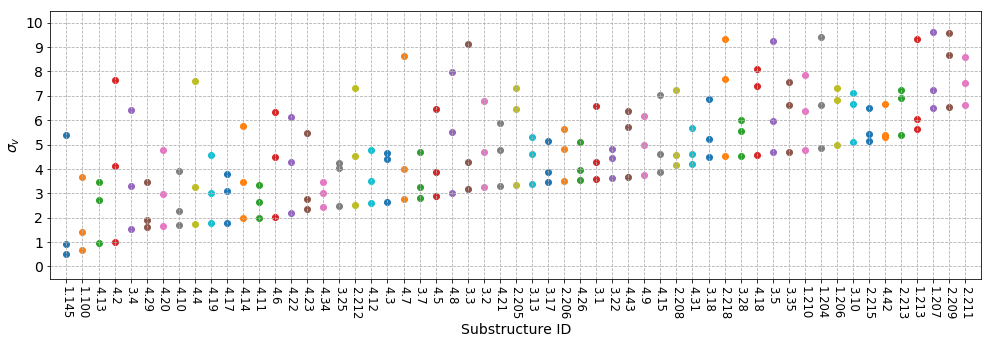

In [1008]:
fig = p.figure(figsize=(14,5))

idx=0
for i in range(n):
    p.scatter([idx,idx,idx], [dr.v1[i], dr.v2[i], dr.v3[i]])
    idx = idx+1
p.xticks(arange(0,n,1), name, fontsize='small', rotation=270)
p.yticks(arange(0,11,1))
p.xlabel('Substructure ID'), p.ylabel(r'$\sigma_v$')
p.xlim(-1,n), p.ylim(-0.5,10.5)
p.grid(axis='both', ls='--')
fig.tight_layout()
fig.savefig('/net/virgo01/data/users/virgini/rockstar/RC3/output/Report/rank.png', format='png')
p.show()

'Velocity dispersion of the substructure in the velocity principal axes, rank from the smallest to the largest with respect to the main principal axis. Different experiment might resproduce the same substructures with exactly the same properties, such as Pleiades (1,2), Praesepe (3,4), Praesepe with one contaminant star (5,6)'

## Calculate the significance

In [39]:
a = ds.evaluate('vx', selection='exp4==0').std()
b = ds.evaluate('vy', selection='exp4==0').std()
c = ds.evaluate('vz', selection='exp4==0').std()

sqrt(a**2+b**2+c**2)

53.95008164135841

In [61]:
k=4
int(ds.evaluate('exp%s' %k)[~isnan(ds.evaluate('exp%s' %k))].max())+1

44

In [77]:
# For paper

output = '/net/virgo01/data/users/virgini/rockstar/RC3/output/significance/significance_14_new'

pca = PCA(n_components=3, svd_solver='full')

with open(output, 'w') as f:
    writer = csv.writer(f, delimiter=' ', lineterminator='\n')
    writer.writerow(['exp', 'subs', 'n_member', 'n_field', 'sigma_xyz', 'prob_sigma_xyz'])
    
    for k in [1,4]:
        for i in tqdm(range(int(ds.evaluate('exp%s' %k)[~isnan(ds.evaluate('exp%s' %k))].max())+1), desc='Loading..'):

            ds.select('exp%s == %s' %(k, i), name='sub')

            n = ds.selected_length(selection='sub')
            
            x = ds.evaluate('x', selection='sub')
            y = ds.evaluate('y', selection='sub')
            z = ds.evaluate('z', selection='sub')

            vx = ds.evaluate('vx', selection='sub')
            vy = ds.evaluate('vy', selection='sub')
            vz = ds.evaluate('vz', selection='sub')
            
            V = sqrt(vx**2 + vy**2 + vz**2)
            sigV = V.std() 
            
            ### select stars within the area of the substructure

            xmin, xmax = str('%.55f' %x.min()), str('%.55f' %x.max())
            ymin, ymax = str('%.55f' %y.min()), str('%.55f' %y.max())
            zmin, zmax = str('%.55f' %z.min()), str('%.55f' %z.max())

            ds.select('(x >= %s) & (x <= %s) & (y >= %s) & (y <= %s) & (z >= %s) & (z <= %s)' \
                     %(xmin, xmax, ymin, ymax, zmin, zmax), name='area')

            ### velocity of the stars in the area
            
            vx2 = ds.evaluate('vx', selection='area')
            vy2 = ds.evaluate('vy', selection='area')
            vz2 = ds.evaluate('vz', selection='area')
            idx = ds.evaluate('source_id', selection='area')
            n2 = ds.selected_length(selection='area')

            # number of iteration, provide zero arrays
            itr = 10000
            sigV2 = zeros(itr)

            for j in range(itr):

                # draw n number of stars, calculate the mean velocity and the dispersion
                idx_random = random.choice(idx, size=n, replace=False)
                index = arange(idx.shape[0])[in1d(idx, idx_random)] #get the index
                vx2_random = array([vx2[i] for i in index])
                vy2_random = array([vy2[i] for i in index])
                vz2_random = array([vz2[i] for i in index])

                V2 = sqrt(vx2_random**2 + vy2_random**2 + vz2_random**2)
                sigV2[j] = V2.std() 

            prob_sigV2 = (len(sigV2[sigV2 <= sigV]) / itr) * 100

            writer.writerow([k, i, n, n2, sigV, prob_sigV2])

    f.close()

Loading..: 100%|██████████| 44/44 [18:02<00:00, 24.60s/it]


In [72]:
df = pd.read_csv(output, sep=' ')
df

,exp,subs,n_member,n_field,sigma_xyz,prob_sigma_xyz
0,1,0,19,19,40.082555,100.00
1,4,0,26,33,53.950082,29.27


In [1021]:
output = '/net/virgo01/data/users/virgini/rockstar/RC3/output/significance/sigma_value'
folder = '/net/virgo01/data/users/virgini/rockstar/RC3/output/significance/'

pca = PCA(n_components=3, svd_solver='full')

with open(output, 'w') as f:
    writer = csv.writer(f, delimiter=' ', lineterminator='\n')
    writer.writerow(['#', 'exp', 'subs', 'n_member', 'n_field', 'sigma_vx', 'sigma_vy', 'sigma_vz', 'sigma_xyz', \
                     'sigma_v1', 'sigma_v2', 'sigma_v3', 'sigma_123'])
    
    for i in tqdm(range(len(name)), desc='Loading..'):
#     for i in [3,4]:

        name2 = name[i].split('.')
        name2[0], name2[1]

        ds.select('exp%s == %s' %(name2[0], name2[1]), name='sub')
        
        n = ds.selected_length(selection='sub')
        
        x = ds.evaluate('x', selection='sub')
        y = ds.evaluate('y', selection='sub')
        z = ds.evaluate('z', selection='sub')
        
        vx = ds.evaluate('vx', selection='sub')
        vy = ds.evaluate('vy', selection='sub')
        vz = ds.evaluate('vz', selection='sub')
        
        sigma_xyz = sqrt((vx.std()**2 + vy.std()**2 + vz.std()**2)/3)
        
        vv = array([vx, vy, vz]).T
        vv_variance = pca.fit(vv)
        var_1, var_2, var_3 = sort(vv_variance.explained_variance_)
        sigma_1, sigma_2, sigma_3 = sqrt(var_1), sqrt(var_2), sqrt(var_3)
        sigma_123 = sqrt((var_1 + var_2 + var_3)/3)
                
        xmin, xmax = str('%.55f' %x.min()), str('%.55f' %x.max())
        ymin, ymax = str('%.55f' %y.min()), str('%.55f' %y.max())
        zmin, zmax = str('%.55f' %z.min()), str('%.55f' %z.max())
        
        stdvx = vx.std() + 0 #+ 1e-3
        stdvy = vy.std() + 0 #+ 1e-3
        stdvz = vz.std() + 0 #+ 1e-3

        # select stars within the area of the substructure
        ds.select('(x >= %s) & (x <= %s) & (y >= %s) & (y <= %s) & (z >= %s) & (z <= %s)' \
                 %(xmin, xmax, ymin, ymax, zmin, zmax), name='area')

        # velocity of the stars in the area
        vx2 = ds.evaluate('vx', selection='area')
        vy2 = ds.evaluate('vy', selection='area')
        vz2 = ds.evaluate('vz', selection='area')
        idx = ds.evaluate('source_id', selection='area')
        n2 = ds.selected_length(selection='area')
        
        # number of iteration, provide zero arrays
        itr = 10000
        vx2_mean, vx2_std = zeros(itr), zeros(itr)
        vy2_mean, vy2_std = zeros(itr), zeros(itr)
        vz2_mean, vz2_std = zeros(itr), zeros(itr)
        sigma2_xyz, sigma2_123 = zeros(itr), zeros(itr)
        sigma2_1, sigma2_2, sigma2_3 = zeros(itr), zeros(itr), zeros(itr)

        for j in range(itr):

            # draw n number of stars, calculate the mean velocity and the dispersion
            idx_random = random.choice(idx, size=n, replace=False)
            index = arange(idx.shape[0])[in1d(idx, idx_random)] #get the index
            vx2_random = array([vx2[i] for i in index])
            vy2_random = array([vy2[i] for i in index])
            vz2_random = array([vz2[i] for i in index])
            
            vx2_mean[j], vx2_std[j] = vx2_random.mean(), vx2_random.std()
            vy2_mean[j], vy2_std[j] = vy2_random.mean(), vy2_random.std()
            vz2_mean[j], vz2_std[j] = vz2_random.mean(), vz2_random.std()
            
            sigma2_xyz[j] = sqrt((vx2_std[j]**2 + vy2_std[j]**2 + vz2_std[j]**2)/3)
            
            vv2 = array([vx2_random, vy2_random, vz2_random]).T
            vv2_variance = pca.fit(vv2)
            var2_1, var2_2, var2_3 = sort(vv2_variance.explained_variance_)
            
            sigma2_1[j] = sqrt(var2_1)
            sigma2_2[j] = sqrt(var2_2)
            sigma2_3[j] = sqrt(var2_3)
            
            sigma2_123[j] = sqrt((var2_1 + var2_2 + var2_3)/3)
            
#         fig = p.figure(figsize=(14,4))
        
#         fig.add_subplot(121)
#         p.title('Cartesian coordinates')
#         p.axvline(x=sigma_xyz, c='k', ls='dashed')
#         p.hist(sigma2_xyz, bins=arange(0,51,1), histtype='bar', edgecolor='seagreen', color='lightblue')
#         p.xlabel(r'$\sigma_v$'), p.ylabel(r'$N$')
#         p.yscale('log')
        
#         fig.add_subplot(122)
#         p.title('Principal axes')
#         p.axvline(x=sigma_123, c='k', ls='dashed')
#         p.hist(sigma2_123, bins=arange(0,51,1), histtype='bar', edgecolor='seagreen', color='lightblue')
#         p.xlabel(r'$\sigma_v$'), p.ylabel(r'$N$')
#         p.yscale('log')
        
#         fig.tight_layout()
#         impath = os.path.join(folder+'sigma_'+str(name2[0])+'_'+str(name2[1])+'.png')
#         fig.savefig(impath, format='png')      
        
#         p.close()

#         fig = p.figure(figsize=(14,4))
        
#         fig.add_subplot(131)
#         p.title(r'$\sigma_{v_1} = %s$' %round(sigma_1, 2), loc='right', fontsize=14)
#         p.axvline(x=sigma_1, c='k', ls='dashed')
#         p.hist(sigma2_1, bins=arange(0,51,1), histtype='bar', edgecolor='seagreen', color='lightblue')
#         p.xlabel(r'$\sigma_{v_1}$'), p.ylabel(r'$N$')
#         p.yscale('log')
        
#         fig.add_subplot(132)
#         p.title(r'$\sigma_{v_2} = %s$' %round(sigma_2, 2), loc='right', fontsize=14)
#         p.axvline(x=sigma_2, c='k', ls='dashed')
#         p.hist(sigma2_2, bins=arange(0,51,1), histtype='bar', edgecolor='seagreen', color='lightblue')
#         p.xlabel(r'$\sigma_{v_2}$'), p.ylabel(r'$N$')
#         p.yscale('log')

#         fig.add_subplot(133)
#         p.title(r'$\sigma_{v_3} = %s$' %round(sigma_3, 2), loc='right', fontsize=14)
#         p.axvline(x=sigma_3, c='k', ls='dashed')
#         p.hist(sigma2_3, bins=arange(0,51,1), histtype='bar', edgecolor='seagreen', color='lightblue')
#         p.xlabel(r'$\sigma_{v_3}$'), p.ylabel(r'$N$')
#         p.yscale('log')

#         fig.tight_layout()
#         impath = os.path.join(folder+'sigma_principal_'+str(name2[0])+'_'+str(name2[1])+'.png')
#         fig.savefig(impath, format='png')      
        
#         p.close()



#         prob_vx_mean = (len(vx2_mean[(vx2_mean >= (vx.mean()-0.1)) & (vx2_mean <= (vx.mean()+0.1))]) / itr) * 100
#         prob_vy_mean = (len(vy2_mean[(vy2_mean >= (vy.mean()-0.1)) & (vy2_mean <= (vy.mean()+0.1))]) / itr) * 100
#         prob_vz_mean = (len(vz2_mean[(vz2_mean >= (vz.mean()-0.1)) & (vz2_mean <= (vz.mean()+0.1))]) / itr) * 100

#         prob_vx_std  = (len(vx2_std[vx2_std <= stdvx]) / itr) * 100
#         prob_vy_std  = (len(vy2_std[vy2_std <= stdvy]) / itr) * 100
#         prob_vz_std  = (len(vz2_std[vz2_std <= stdvz]) / itr) * 100
        
#         prob_sigma_xyz = (len(sigma2_xyz[sigma2_xyz <= sigma_xyz]) / itr) * 100
        
#         prob_sigma_1 = (len(sigma2_1[sigma2_1 <= sigma_1]) / itr) * 100
#         prob_sigma_2 = (len(sigma2_2[sigma2_2 <= sigma_2]) / itr) * 100
#         prob_sigma_3 = (len(sigma2_3[sigma2_3 <= sigma_3]) / itr) * 100
        
#         prob_sigma_123 = (len(sigma2_123[sigma2_123 <= sigma_123]) / itr) * 100
        
#         prob_both = len(vx2_random[vx2_mean])
#         prob = [prob_vx_std, prob_vy_std, prob_vz_std, prob_vx_mean, prob_vy_mean, prob_vz_mean]
#         prob2 = [round(elem, 2) for elem in prob]

#         writer.writerow([i, name2[0], name2[1], n, n2, prob_vx_mean, prob_vy_mean, prob_vz_mean,\
#                          prob_vx_std, prob_vy_std, prob_vz_std, prob_sigma_xyz, prob_sigma_1,\
#                          prob_sigma_2, prob_sigma_3, prob_sigma_123])
        
        writer.writerow([i, name2[0], name2[1], n, n2, stdvx, stdvy, stdvz, sigma_xyz, \
                         sigma_1, sigma_2, sigma_3, sigma_123])

    f.close()

    #     print(i, name2, n, n2, prob2)

    #     prob3 = [elem <= 1 for elem in prob2]
    #     select = [True, True, True, True, True, True]
    #     if prob3 != select:


Loading..: 100%|██████████| 57/57 [04:55<00:00,  5.18s/it]


In [16]:
output = '/net/virgo01/data/users/virgini/rockstar/RC3/output/significance/exp-significance'
df = pd.read_csv(output, sep=' ')
# df[df.subs==210]
df

,#,exp,subs,n_member,n_field,mean_vx,mean_vy,mean_vz,sigma_vx,sigma_vy,sigma_vz,sigma_xyz,sigma_v1,sigma_v2,sigma_v3,sigma_123
0,0,1,145,10,10,100.00,100.00,100.00,100.0,100.00,100.00,100.0,100.00,100.00,100.0,100.0
1,1,1,100,14,14,100.00,100.00,100.00,100.0,100.00,100.00,100.0,100.00,100.00,100.0,100.0
2,2,3,0,18,18,100.00,100.00,100.00,100.0,100.00,100.00,100.0,100.00,100.00,100.0,100.0
3,3,4,13,11,161,0.02,0.90,0.97,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.0
4,4,4,2,12,803,0.00,0.20,0.01,0.0,0.00,0.05,0.0,0.00,0.00,0.0,0.0
5,5,3,4,16,327,0.09,0.04,0.20,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.0
6,6,4,29,20,1288,0.74,0.04,1.24,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.0
7,7,4,20,14,313,0.44,0.02,0.08,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.0
8,8,4,24,30,4930,0.00,1.81,0.69,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.0
9,9,4,10,13,771,0.81,0.00,0.53,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.0


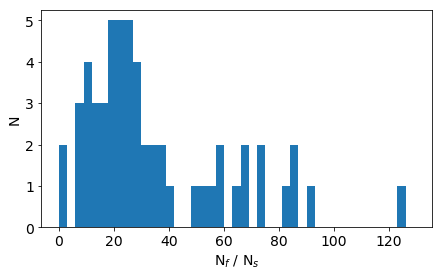

array([   1.        ,    1.        ,    6.36363636,    7.2       ,
          7.45      ,    9.52941176,   10.36363636,   10.36363636,
         10.46153846,   13.09090909,   14.63636364,   14.86206897,
         15.55      ,   16.79746835,   16.875     ,   19.53333333,
         20.24731183,   20.31818182,   20.4375    ,   20.625     ,
         22.25      ,   22.35714286,   22.80952381,   23.15      ,
         23.75925926,   24.17283951,   24.63636364,   24.8125    ,
         26.60465116,   26.89473684,   27.01515152,   27.21153846,
         28.75      ,   29.21875   ,   30.61764706,   32.66666667,
         34.625     ,   35.64285714,   36.57142857,   37.95454545,
         40.23684211,   49.55      ,   53.3       ,   55.85365854,
         59.29166667,   59.30769231,   64.4       ,   66.57407407,
         66.91666667,   74.61538462,   74.76041667,   81.28571429,
         84.9047619 ,   85.44444444,   92.09090909,  123.8       ,
        129.15384615])

In [1041]:
data = sort(array(df.n_field/df.n_member))
fig = p.figure(figsize=(7,4))
p.hist(data, bins=arange(0,130,3))
p.xlabel(r'N$_f$ / N$_s$')
p.ylabel('N')
p.show()
data

# Principal axis plots

In [ ]:
gs1 = p.GridSpec(nrows=3, ncols=2, height_ratios=[2,1,2])
gs2 = p.GridSpec(nrows=3, ncols=3, hspace=0.5, height_ratios=[2,1,2])
pca = PCA(n_components=3, svd_solver='full')

with PdfPages('/net/virgo01/data/users/virgini/rockstar/RC3/output/selection/pca3.pdf') as pdf:
    
    for n in tqdm(range(len(name)), desc='Loading..'):

        name2 = name[n].split('.')
        name2[0], name2[1]

        select = 'exp%s == %s' %(name2[0], name2[1])

        x = ds.evaluate('x', selection=select)
        y = ds.evaluate('y', selection=select)
        z = ds.evaluate('z', selection=select)

        vx = ds.evaluate('vx', selection=select)
        vy = ds.evaluate('vy', selection=select)
        vz = ds.evaluate('vz', selection=select)

        r_array = array([x,y,z]).T
        v_array = array([vx,vy,vz]).T

        # Fit: create priciple axis on the basis of the positions
        pca.fit(r_array)
        # transform: convert the velocities to the principle axis coordinates
        vv = pca.transform(v_array)
        # transform: convert the positions to the principle axis coordinates
        rr = pca.transform(r_array)

        r1, r2, r3 = rr[:,2], rr[:,1], rr[:,0] #sort pca from the smallest variance
        v1, v2, v3 = vv[:,2], vv[:,1], vv[:,0]
        
        bins = arange(-70,75,5)
        diam = 0.150 #kpc
        width = int(diam*2*1e3)

        fig = p.figure(figsize=(14,17))        
        fig.suptitle('Experiment %s - Substructure %s' %(name2[0], name2[1]), y=0.95)

        fig.add_subplot(gs1[0])
        ax = p.scatter(r1, r2)
        for i in range(len(v1)):
            p.arrow(r1[i], r2[i], v1[i]/1000, v2[i]/1000, width=0.0001)
        p.xlim(r1.mean()-diam, r1.mean()+diam)
        p.ylim(r2.mean()-diam, r2.mean()+diam)
        p.xticks(fontsize='large')
        p.yticks(fontsize='large')
        p.xlabel(r'$r_1$ [kpc]', fontsize='x-large')
        p.ylabel(r'$r_2$ [kpc]', fontsize='x-large')
        p.title('Box size = %s pc x %s pc' %(width, width), loc='left')
        p.gca().add_patch(p.Circle((r1.mean(),r2.mean()), radius=0.050, ec='red', fc='none', label='rad 50 pc'))
        p.gca().add_patch(p.Circle((r1.mean(),r2.mean()), radius=0.100, ec='blue', fc='none', label='rad 100 pc'))
        p.legend(frameon=False)

        fig.add_subplot(gs1[1])
        p.scatter(r3, r2)
        for i in range(len(v1)):
            p.arrow(r3[i], r2[i], v3[i]/1000, v2[i]/1000, width=0.0001)
        p.xlim(r3.mean()-diam, r3.mean()+diam)
        p.ylim(r2.mean()-diam, r2.mean()+diam)
        p.xticks(fontsize='large')
        p.yticks(fontsize='large')
        p.xlabel(r'$r_3$ [kpc]', fontsize='x-large')
        p.title('N = %s' %len(x), loc='right')
        p.gca().add_patch(p.Circle((r3.mean(),r2.mean()), radius=0.050, ec='red', fc='none', label='rad 50 pc'))
        p.gca().add_patch(p.Circle((r3.mean(),r2.mean()), radius=0.100, ec='blue', fc='none', label='rad 100 pc'))
        p.legend(frameon=False)

        # calculate velocity dispersion
        vv2 = pca.fit_transform(v_array)
        sigma = sort(sqrt(pca.explained_variance_))
        v1, v2, v3 = vv2[:,2], vv2[:,1], vv2[:,0]
        
        fig.add_subplot(gs2[3])
        p.title(r'$\sigma = %s$' %(round(sigma[0],2)), loc='left')
        p.hist(v1, bins=bins, histtype='step', color='k')
        p.xlabel(r'$v_1$ [km/s]', fontsize='x-large')
        p.ylabel('N', fontsize='x-large')

        fig.add_subplot(gs2[4])
        p.title(r'$\sigma = %s$' %(round(sigma[1],2)), loc='left')
        p.hist(v2, bins=bins, histtype='step', color='k')
        p.xlabel(r'$v_2$ [km/s]', fontsize='x-large')

        fig.add_subplot(gs2[5])
        p.title(r'$\sigma = %s$' %(round(sigma[2],2)), loc='left')
        p.hist(v3, bins=bins, histtype='step', color='k')
        p.xlabel(r'$v_3$ [km/s]', fontsize='x-large')
        
        fig.add_subplot(gs1[4])
        p.scatter(v1, v2)
        p.xlim(-70,70), p.ylim(-70,70)
        p.axhline(y=0, c='k', linestyle='dashed')
        p.axvline(x=0, c='k', linestyle='dashed')
        p.xticks(fontsize='large')
        p.yticks(fontsize='large')
        p.xlabel(r'$v_1$ [km/s]', fontsize='x-large')
        p.ylabel(r'$v_2$ [km/s]', fontsize='x-large')
        
        fig.add_subplot(gs1[5])
        p.scatter(v3, v2)
        p.xlim(-70,70), p.ylim(-70,70)
        p.axhline(y=0, c='k', linestyle='dashed')
        p.axvline(x=0, c='k', linestyle='dashed')
        p.xticks(fontsize='large')
        p.yticks(fontsize='large')
        p.xlabel(r'$v_3$ [km/s]', fontsize='x-large')
        
        fig.tight_layout
#         p.show()
        pdf.savefig()
        p.close()

print('finish')

# Cartesian plots

In [ ]:
gs1 = p.GridSpec(nrows=3, ncols=2, height_ratios=[2,1,2])
gs2 = p.GridSpec(nrows=3, ncols=3, hspace=0.5, height_ratios=[2,1,2])

with PdfPages('/net/virgo01/data/users/virgini/rockstar/RC3/output/selection/cartesian.pdf') as pdf:
    
    for n in tqdm(range(len(name)), desc='Loading..'):

        name2 = name[n].split('.')
        name2[0], name2[1]

        select = 'exp%s == %s' %(name2[0], name2[1])

        x = ds.evaluate('x', selection=select)
        y = ds.evaluate('y', selection=select)
        z = ds.evaluate('z', selection=select)

        vx = ds.evaluate('vx', selection=select)
        vy = ds.evaluate('vy', selection=select)
        vz = ds.evaluate('vz', selection=select)

        bins = arange(-70,75,5)
        diam = 0.150 #kpc
        width = int(diam*2*1e3)

        fig = p.figure(figsize=(14,17))        
        fig.suptitle('Experiment %s - Substructure %s' %(name2[0], name2[1]), y=0.95)

        fig.add_subplot(gs1[0])
        ax = p.scatter(x, y)
        p.scatter(0,0)
        for i in range(len(vx)):
            p.arrow(x[i], y[i], vx[i]/1000, vy[i]/1000, width=0.0001)
        p.xlim(x.mean()-diam, x.mean()+diam) 
        p.ylim(y.mean()-diam, y.mean()+diam) 
        p.xticks(fontsize='large')
        p.yticks(fontsize='large')
        p.xlabel(r'$x$ [kpc]', fontsize='x-large')
        p.ylabel(r'$y$ [kpc]', fontsize='x-large')
        p.title('Box size = %s pc x %s pc' %(width, width), loc='left')
        p.gca().add_patch(p.Circle((x.mean(),y.mean()), radius=0.050, ec='red', fc='none', label='rad 50 pc'))
        p.gca().add_patch(p.Circle((x.mean(),y.mean()), radius=0.100, ec='blue', fc='none', label='rad 100 pc'))
        p.legend(frameon=False)

        fig.add_subplot(gs1[1])
        p.scatter(z, y)
        p.scatter(0,0)
        for i in range(len(vx)):
            p.arrow(z[i], y[i], vz[i]/1000, vy[i]/1000, width=0.0001)
        p.xlim(z.mean()-diam, z.mean()+diam)
        p.ylim(y.mean()-diam, y.mean()+diam)
        p.xticks(fontsize='large')
        p.yticks(fontsize='large')
        p.xlabel(r'$z$ [kpc]', fontsize='x-large')
        p.title('N = %s' %len(x), loc='right')
        p.gca().add_patch(p.Circle((z.mean(),y.mean()), radius=0.050, ec='red', fc='none', label='rad 50 pc'))
        p.gca().add_patch(p.Circle((z.mean(),y.mean()), radius=0.100, ec='blue', fc='none', label='rad 100 pc'))
        p.legend(frameon=False)
   
        fig.add_subplot(gs2[3])
        p.title(r'$\sigma = %s$' %(round(vx.std(),2)), loc='left')
        p.hist(vx, bins=bins, histtype='step', color='k')
        p.axvline(x=0, c='k', linestyle='dashed')
        p.xlabel(r'$v_x$ [km/s]', fontsize='x-large')
        p.ylabel('N', fontsize='x-large')

        fig.add_subplot(gs2[4])
        p.title(r'$\sigma = %s$' %(round(vy.std(),2)), loc='left')
        p.hist(vy, bins=bins, histtype='step', color='k')
        p.axvline(x=0, c='k', linestyle='dashed')
        p.xlabel(r'$v_y$ [km/s]', fontsize='x-large')
        
        fig.add_subplot(gs2[5])
        p.title(r'$\sigma = %s$' %(round(vz.std(),2)), loc='left')
        p.hist(vz, bins=bins, histtype='step', color='k')
        p.axvline(x=0, c='k', linestyle='dashed')
        p.xlabel(r'$v_z$ [km/s]', fontsize='x-large')
        
        fig.add_subplot(gs1[4])
        p.scatter(vx, vy)
        p.xlim(-70,70), p.ylim(-70,70)
        p.axhline(y=0, c='k', linestyle='dashed')
        p.axvline(x=0, c='k', linestyle='dashed')
        p.xticks(fontsize='large')
        p.yticks(fontsize='large')
        p.xlabel(r'$v_x$ [km/s]', fontsize='x-large')
        p.ylabel(r'$v_y$ [km/s]', fontsize='x-large')
        
        fig.add_subplot(gs1[5])
        p.scatter(vz, vy)
        p.xlim(-70,70), p.ylim(-70,70)
        p.axhline(y=0, c='k', linestyle='dashed')
        p.axvline(x=0, c='k', linestyle='dashed')
        p.xticks(fontsize='large')
        p.yticks(fontsize='large')
        p.xlabel(r'$v_z$ [km/s]', fontsize='x-large')
        
        fig.tight_layout
        pdf.savefig()
        p.close()

print('finish')

# Cartesian plots with correction for solar motion

In [ ]:
gs1 = p.GridSpec(nrows=3, ncols=2, height_ratios=[2,1,2])
gs2 = p.GridSpec(nrows=3, ncols=3, hspace=0.5, height_ratios=[2,1,2])

with PdfPages('/net/virgo01/data/users/virgini/rockstar/RC3/output/selection/cartesian_correction.pdf') as pdf:
    
    for n in tqdm(range(len(name)), desc='Loading..'):

        name2 = name[n].split('.')
        name2[0], name2[1]

        select = 'exp%sc == %s' %(name2[0], name2[1])

        x = ds.evaluate('x', selection=select)
        y = ds.evaluate('y', selection=select)
        z = ds.evaluate('z', selection=select)

        vx = ds.evaluate('vx', selection=select)
        vy = ds.evaluate('vy', selection=select)
        vz = ds.evaluate('vz', selection=select)

        bins = arange(-70,75,5)
        diam = 0.150 #kpc
        width = int(diam*2*1e3)

        fig = p.figure(figsize=(14,17))        
        fig.suptitle('Experiment %s - Substructure %s' %(name2[0], name2[1]), y=0.95)

        fig.add_subplot(gs1[0])
        ax = p.scatter(x, y)
        p.scatter(0,0)
        for i in range(len(vx)):
            p.arrow(x[i], y[i], vx[i]/1000, vy[i]/1000, width=0.0001)
        p.xlim(x.mean()-diam, x.mean()+diam) 
        p.ylim(y.mean()-diam, y.mean()+diam) 
        p.xticks(fontsize='large')
        p.yticks(fontsize='large')
        p.xlabel(r'$x$ [kpc]', fontsize='x-large')
        p.ylabel(r'$y$ [kpc]', fontsize='x-large')
        p.title('Box size = %s pc x %s pc' %(width, width), loc='left')
        p.gca().add_patch(p.Circle((x.mean(),y.mean()), radius=0.050, ec='red', fc='none', label='rad 50 pc'))
        p.gca().add_patch(p.Circle((x.mean(),y.mean()), radius=0.100, ec='blue', fc='none', label='rad 100 pc'))
        p.legend(frameon=False)

        fig.add_subplot(gs1[1])
        p.scatter(z, y)
        p.scatter(0,0)
        for i in range(len(vx)):
            p.arrow(z[i], y[i], vz[i]/1000, vy[i]/1000, width=0.0001)
        p.xlim(z.mean()-diam, z.mean()+diam)
        p.ylim(y.mean()-diam, y.mean()+diam)
        p.xticks(fontsize='large')
        p.yticks(fontsize='large')
        p.xlabel(r'$z$ [kpc]', fontsize='x-large')
        p.title('N = %s' %len(x), loc='right')
        p.gca().add_patch(p.Circle((z.mean(),y.mean()), radius=0.050, ec='red', fc='none', label='rad 50 pc'))
        p.gca().add_patch(p.Circle((z.mean(),y.mean()), radius=0.100, ec='blue', fc='none', label='rad 100 pc'))
        p.legend(frameon=False)
   
        fig.add_subplot(gs2[3])
        p.title(r'$\sigma = %s$' %(round(vx.std(),2)), loc='left')
        p.hist(vx, bins=bins, histtype='step', color='k')
        p.axvline(x=0, c='k', linestyle='dashed')
        p.xlabel(r'$v_x$ [km/s]', fontsize='x-large')
        p.ylabel('N', fontsize='x-large')

        fig.add_subplot(gs2[4])
        p.title(r'$\sigma = %s$' %(round(vy.std(),2)), loc='left')
        p.hist(vy, bins=bins, histtype='step', color='k')
        p.axvline(x=0, c='k', linestyle='dashed')
        p.xlabel(r'$v_y$ [km/s]', fontsize='x-large')
        
        fig.add_subplot(gs2[5])
        p.title(r'$\sigma = %s$' %(round(vz.std(),2)), loc='left')
        p.hist(vz, bins=bins, histtype='step', color='k')
        p.axvline(x=0, c='k', linestyle='dashed')
        p.xlabel(r'$v_z$ [km/s]', fontsize='x-large')
        
        fig.add_subplot(gs1[4])
        p.scatter(vx, vy)
        p.xlim(-70,70), p.ylim(-70,70)
        p.axhline(y=0, c='k', linestyle='dashed')
        p.axvline(x=0, c='k', linestyle='dashed')
        p.xticks(fontsize='large')
        p.yticks(fontsize='large')
        p.xlabel(r'$v_x$ [km/s]', fontsize='x-large')
        p.ylabel(r'$v_y$ [km/s]', fontsize='x-large')
        
        fig.add_subplot(gs1[5])
        p.scatter(vz, vy)
        p.xlim(-70,70), p.ylim(-70,70)
        p.axhline(y=0, c='k', linestyle='dashed')
        p.axvline(x=0, c='k', linestyle='dashed')
        p.xticks(fontsize='large')
        p.yticks(fontsize='large')
        p.xlabel(r'$v_z$ [km/s]', fontsize='x-large')
        
        fig.tight_layout
        pdf.savefig()
        p.close()

print('finish')

# Sky plots

In [ ]:
gs1 = p.GridSpec(nrows=3, ncols=1, hspace=0.2, height_ratios=[2,2,1])
gs2 = p.GridSpec(nrows=3, ncols=2, hspace=0.2, height_ratios=[2,2,1])
bins = arange(0,34,2)

with PdfPages('/net/virgo01/data/users/virgini/rockstar/RC3/output/selection/sky.pdf') as pdf:
    
    for n in tqdm(range(len(name)), desc='Loading..'):

        name2 = name[n].split('.')
        name2[0], name2[1]

        select = 'exp%s == %s' %(name2[0], name2[1])
        l = ds.evaluate('l', selection=select)
        b = ds.evaluate('b', selection=select)
        pml = ds.evaluate('pm_l', selection=select)
        pmb = ds.evaluate('pm_b', selection=select)
        parallax = ds.evaluate('best_parallax', selection=select)
        distance = ds.evaluate('best_distance', selection=select)*1000

        fig = p.figure(figsize=(14,17))
        fig.suptitle('Experiment %s - Substructure %s' %(name2[0], name2[1]), y=0.95)

        fig.add_subplot(gs1[0])
        p.scatter(l, b)
        for j in range(len(l)):
            p.arrow(l[j], b[j], pml[j]/4, pmb[j]/4, width=0.0001)
        p.xlim(0,360), p.ylim(-90,90)
        p.xlabel(r'$l$ [deg]', fontsize='x-large'), p.ylabel(r'$b$ [deg]', fontsize='x-large')
        p.xticks(fontsize='x-large'), p.yticks(fontsize='x-large')

        fig.add_subplot(gs2[2])
        p.scatter(pml, pmb)
        p.xlim(-150,150), p.ylim(-150,150)
        p.axhline(y=0, c='k', linestyle='dashed')
        p.axvline(x=0, c='k', linestyle='dashed')
        p.xlabel(r'$\mu_l$ [mas/yr]', fontsize='x-large'), p.ylabel(r'$\mu_b$ [mas/yr]', fontsize='x-large')
        p.xticks(fontsize='x-large'), p.yticks(fontsize='x-large')
        
        fig.add_subplot(gs2[3])
        ds.scatter('G-K', 'G', selection=select)
        p.xlim(-1,5), p.ylim(9,-5)
        p.xlabel('G - K', fontsize='x-large'), p.ylabel('G', fontsize='x-large')
        p.xticks(fontsize='x-large'), p.yticks(fontsize='x-large')
        p.title(' ')

        fig.add_subplot(gs2[4])
        p.hist(parallax, bins=bins, histtype='step', color='k')
        p.xlabel(r'$\omega$ [mas]', fontsize='x-large'), p.ylabel('N', fontsize='x-large')
        p.xticks(fontsize='x-large'), p.yticks(fontsize='x-large')

        fig.add_subplot(gs2[5])
        p.hist(distance, bins=arange(0,480,30), histtype='step', color='k')
        p.xlabel('d [pc]', fontsize='x-large'), p.ylabel('N', fontsize='x-large')
        p.xticks(fontsize='x-large'), p.yticks(fontsize='x-large')

        fig.tight_layout
        pdf.savefig()
        p.close()

print('finish')

## Comparison with the fields

This is to ask ourselves, do the motion is really due to the same origin, or is it by chance due to the motion of stars in Galaxy?

In [ ]:
gs1 = p.GridSpec(nrows=4, ncols=2, height_ratios=[2,1,1,1], top=0.92, bottom=0.18)
gs2 = p.GridSpec(nrows=4, ncols=3, hspace=0.4, height_ratios=[2,1,1,1])

with PdfPages('/net/virgo01/data/users/virgini/rockstar/RC3/output/selection/cartesian_field.pdf') as pdf:

    for n in tqdm(range(len(name)), desc='Loading..'):

            name2 = name[n].split('.')
            name2[0], name2[1]

            select = 'exp%s == %s' %(name2[0], name2[1])

            x = ds.evaluate('x', selection=select)
            y = ds.evaluate('y', selection=select)
            z = ds.evaluate('z', selection=select)
            vx = ds.evaluate('vx', selection=select)
            vy = ds.evaluate('vy', selection=select)
            vz = ds.evaluate('vz', selection=select)

            rx = abs(x.max()-x.mean())*2
            ry = abs(y.max()-y.mean())*2
            rz = abs(z.max()-z.mean())*2

            ds.select('(x >= %s) & (x <= %s) & (y >= %s) & (y <= %s) & (z >= %s) & (z <= %s)' \
                     %(str('%.55f' %(x.mean()-rx)), str('%.55f' %(x.mean()+rx)), str('%.55f' %(y.mean()-ry)),\
                     str('%.55f' %(y.mean()+ry)), str('%.55f' %(z.mean()-rz)), str('%.55f' %(z.mean()+rz))), name='field') 
            ds.select('(vx >= %s) & (vx <= %s) & (vy >= %s) & (vy <= %s) & (vz >= %s) & (vz <= %s)' \
                     %(str('%.55f' %vx.min()), str('%.55f' %vx.max()), str('%.55f' %vy.min()), str('%.55f' %vy.max()),\
                     str('%.55f' %vz.min()), str('%.55f' %vz.max())), name='velocity')
            
            x_field = ds.evaluate('x', selection='field')
            y_field = ds.evaluate('y', selection='field')
            z_field = ds.evaluate('z', selection='field')
            vx_field = ds.evaluate('vx', selection='field')
            vy_field = ds.evaluate('vy', selection='field')
            vz_field = ds.evaluate('vz', selection='field')

            x_share = ds.evaluate('x', selection='(field) & (velocity)')
            y_share = ds.evaluate('y', selection='(field) & (velocity)')
            z_share = ds.evaluate('z', selection='(field) & (velocity)')
            vx_share = ds.evaluate('vx', selection='(field) & (velocity)')
            vy_share = ds.evaluate('vy', selection='(field) & (velocity)')
            vz_share = ds.evaluate('vz', selection='(field) & (velocity)')

            bins = arange(-70,75,5)
            diam = 0.150 #kpc
            width = int(diam*2*1e3)

            fig = p.figure(figsize=(14,18))        
            fig.suptitle('Experiment %s - Substructure %s' %(name2[0], name2[1]), y=0.95)

            fig.add_subplot(gs1[0])
            ax = p.scatter(x, y, zorder=1)
            p.scatter(x_field, y_field, s=1, c='lightgrey', zorder=-1)
            p.scatter(0,0)
            for i in range(len(vx)):
                p.arrow(x[i], y[i], vx[i]/1000, vy[i]/1000, width=0.0001)
            p.xlim(x.mean()-diam, x.mean()+diam) 
            p.ylim(y.mean()-diam, y.mean()+diam) 
            p.xticks(fontsize='large')
            p.yticks(fontsize='large')
            p.xlabel(r'$x$ [kpc]', fontsize='x-large')
            p.ylabel(r'$y$ [kpc]', fontsize='x-large')
            p.title('Box size = %s pc x %s pc' %(width, width), loc='left')
            p.gca().add_patch(p.Circle((x.mean(),y.mean()), radius=0.050, ec='red', fc='none', label='rad 50 pc'))
            p.gca().add_patch(p.Circle((x.mean(),y.mean()), radius=0.100, ec='blue', fc='none', label='rad 100 pc'))
            p.legend(frameon=False)

            fig.add_subplot(gs1[1])
            p.scatter(z, y, zorder=1)
            p.scatter(z_field, y_field, s=1, c='lightgrey', zorder=-1)
            p.scatter(0,0)
            for i in range(len(vx)):
                p.arrow(z[i], y[i], vz[i]/1000, vy[i]/1000, width=0.0001)
            p.xlim(z.mean()-diam, z.mean()+diam)
            p.ylim(y.mean()-diam, y.mean()+diam)
            p.xticks(fontsize='large')
            p.yticks(fontsize='large')
            p.xlabel(r'$z$ [kpc]', fontsize='x-large')
            p.gca().add_patch(p.Circle((z.mean(),y.mean()), radius=0.050, ec='red', fc='none', label='rad 50 pc'))
            p.gca().add_patch(p.Circle((z.mean(),y.mean()), radius=0.100, ec='blue', fc='none', label='rad 100 pc'))
            p.legend(frameon=False)

            fig.add_subplot(gs2[3])
            p.title(r'$\sigma = %s$' %(round(vx.std(),2)), loc='left')
            p.hist(vx, bins=bins, histtype='stepfilled', edgecolor='k', color='lightblue')
            p.xlabel(r'$v_x$ [km/s]', fontsize='x-large')
            p.ylabel('N', fontsize='x-large')

            fig.add_subplot(gs2[4])
            p.title(r'$\sigma = %s$' %(round(vy.std(),2)), loc='left')
            p.hist(vy, bins=bins, histtype='stepfilled', edgecolor='k', color='lightblue')
            p.xlabel(r'$v_y$ [km/s]', fontsize='x-large')

            fig.add_subplot(gs2[5])
            p.title(r'$\sigma = %s$' %(round(vz.std(),2)), loc='left')
            p.title('N = %s' %len(vz), loc='right')
            p.hist(vz, bins=bins, histtype='stepfilled', edgecolor='k', color='lightblue')
            p.xlabel(r'$v_z$ [km/s]', fontsize='x-large')

            fig.add_subplot(gs2[6])
            p.title(r'$\sigma = %s$' %(round(vx_field.std(),2)), loc='left')
            p.hist(vx_field, bins=bins, histtype='step', color='k')
            p.hist(vx, bins=bins, histtype='stepfilled', edgecolor='k', color='lightblue')
            p.xlabel(r'$v_x$ [km/s]', fontsize='x-large')
            p.ylabel('N', fontsize='x-large')

            fig.add_subplot(gs2[7])
            p.title(r'$\sigma = %s$' %(round(vy_field.std(),2)), loc='left')
            p.hist(vy_field, bins=bins, histtype='step', color='k')
            p.hist(vy, bins=bins, histtype='stepfilled', edgecolor='k', color='lightblue')
            p.xlabel(r'$v_y$ [km/s]', fontsize='x-large')

            fig.add_subplot(gs2[8])
            p.title(r'$\sigma = %s$' %(round(vz_field.std(),2)), loc='left')
            p.title('N = %s' %len(vz_field), loc='right')
            p.hist(vz_field, bins=bins, histtype='step', color='k')
            p.hist(vz, bins=bins, histtype='stepfilled', edgecolor='k', color='lightblue')
            p.xlabel(r'$v_z$ [km/s]', fontsize='x-large')

            fig.add_subplot(gs2[9])
            p.title(r'$\sigma = %s$' %(round(vx_share.std(),2)), loc='left')
            p.hist(vx_share, bins=bins, histtype='step', color='k')
            p.hist(vx, bins=bins, histtype='stepfilled', edgecolor='k', color='lightblue')
            p.xlabel(r'$v_x$ [km/s]', fontsize='x-large')
            p.ylabel('N', fontsize='x-large')

            fig.add_subplot(gs2[10])
            p.title(r'$\sigma = %s$' %(round(vy_share.std(),2)), loc='left')
            p.hist(vy_share, bins=bins, histtype='step', color='k')
            p.hist(vy, bins=bins, histtype='stepfilled', edgecolor='k', color='lightblue')
            p.xlabel(r'$v_y$ [km/s]', fontsize='x-large')

            fig.add_subplot(gs2[11])
            p.title(r'$\sigma = %s$' %(round(vz_share.std(),2)), loc='left')
            p.title('N = %s' %len(vz_share), loc='right')
            p.hist(vz_share, bins=bins, histtype='step', color='k')
            p.hist(vz, bins=bins, histtype='stepfilled', edgecolor='k', color='lightblue')
            p.xlabel(r'$v_z$ [km/s]', fontsize='x-large')

            fig.tight_layout
            pdf.savefig()
            p.close()

## Cartesian plots, magnified velocity

In [ ]:
gs1 = p.GridSpec(nrows=1, ncols=2)

with PdfPages('/net/virgo01/data/users/virgini/rockstar/RC3/output/selection/cartesian-zoom.pdf') as pdf:
    
    for n in tqdm(range(len(name)), desc='Loading..'):

        name2 = name[n].split('.')
        name2[0], name2[1]

        select = 'exp%s == %s' %(name2[0], name2[1])

        x = ds.evaluate('x', selection=select)
        y = ds.evaluate('y', selection=select)
        z = ds.evaluate('z', selection=select)

        vx = ds.evaluate('vx', selection=select)
        vy = ds.evaluate('vy', selection=select)
        vz = ds.evaluate('vz', selection=select)

        bins = arange(-70,75,5)
        diam = 0.300 #kpc
        width = int(diam*2*1e3)

        fig = p.figure(figsize=(14,7))        
        fig.suptitle('Experiment %s - Substructure %s' %(name2[0], name2[1]), y=0.95)

        fig.add_subplot(gs1[0])
        ax = p.scatter(x, y)
        p.scatter(0,0)
        for i in range(len(vx)):
            p.arrow(x[i], y[i], vx[i]/100, vy[i]/100, width=0.0001)
        p.xlim(x.mean()-diam, x.mean()+diam) 
        p.ylim(y.mean()-diam, y.mean()+diam) 
        p.xticks(fontsize='large')
        p.yticks(fontsize='large')
        p.xlabel(r'$x$ [kpc]', fontsize='x-large')
        p.ylabel(r'$y$ [kpc]', fontsize='x-large')
        p.title('Box size = %s pc x %s pc' %(width, width), loc='left')
        p.gca().add_patch(p.Circle((x.mean(),y.mean()), radius=0.050, ec='red', fc='none', label='rad 50 pc'))
        p.gca().add_patch(p.Circle((x.mean(),y.mean()), radius=0.100, ec='blue', fc='none', label='rad 100 pc'))
        p.legend(frameon=False)

        fig.add_subplot(gs1[1])
        p.scatter(z, y)
        p.scatter(0,0)
        for i in range(len(vx)):
            p.arrow(z[i], y[i], vz[i]/100, vy[i]/100, width=0.0001)
        p.xlim(z.mean()-diam, z.mean()+diam)
        p.ylim(y.mean()-diam, y.mean()+diam)
        p.xticks(fontsize='large')
        p.yticks(fontsize='large')
        p.xlabel(r'$z$ [kpc]', fontsize='x-large')
        p.title('N = %s' %len(x), loc='right')
        p.gca().add_patch(p.Circle((z.mean(),y.mean()), radius=0.050, ec='red', fc='none', label='rad 50 pc'))
        p.gca().add_patch(p.Circle((z.mean(),y.mean()), radius=0.100, ec='blue', fc='none', label='rad 100 pc'))
        p.legend(frameon=False)
        
        fig.tight_layout(rect=[0,0,1,0.90])
        pdf.savefig()
        p.close()

## Principal axis plots, magnified velocity

In [ ]:
gs1 = p.GridSpec(nrows=1, ncols=2)
pca = PCA(n_components=3, svd_solver='full')

with PdfPages('/net/virgo01/data/users/virgini/rockstar/RC3/output/selection/pca3-zoom.pdf') as pdf:
    
    for n in tqdm(range(len(name)), desc='Loading..'):

        name2 = name[n].split('.')
        name2[0], name2[1]

        select = 'exp%s == %s' %(name2[0], name2[1])

        x = ds.evaluate('x', selection=select)
        y = ds.evaluate('y', selection=select)
        z = ds.evaluate('z', selection=select)

        vx = ds.evaluate('vx', selection=select)
        vy = ds.evaluate('vy', selection=select)
        vz = ds.evaluate('vz', selection=select)

        r_array = array([x,y,z]).T
        v_array = array([vx,vy,vz]).T

        # Fit: create priciple axis on the basis of the positions
        pca.fit(r_array)
        # transform: convert the velocities to the principle axis coordinates
        vv = pca.transform(v_array)
        # transform: convert the positions to the principle axis coordinates
        rr = pca.transform(r_array)

        r1, r2, r3 = rr[:,2], rr[:,1], rr[:,0] #sort pca from the smallest variance
        v1, v2, v3 = vv[:,2], vv[:,1], vv[:,0]
        
        bins = arange(-70,75,5)
        diam = 0.300 #kpc
        width = int(diam*2*1e3)

        fig = p.figure(figsize=(14,7))        
        fig.suptitle('Experiment %s - Substructure %s' %(name2[0], name2[1]), y=0.95)

        fig.add_subplot(gs1[0])
        ax = p.scatter(r1, r2)
        for i in range(len(v1)):
            p.arrow(r1[i], r2[i], v1[i]/100, v2[i]/100, width=0.0001)
        p.xlim(r1.mean()-diam, r1.mean()+diam)
        p.ylim(r2.mean()-diam, r2.mean()+diam)
        p.xticks(fontsize='large')
        p.yticks(fontsize='large')
        p.xlabel(r'$r_1$ [kpc]', fontsize='x-large')
        p.ylabel(r'$r_2$ [kpc]', fontsize='x-large')
        p.title('Box size = %s pc x %s pc' %(width, width), loc='left')
        p.gca().add_patch(p.Circle((r1.mean(),r2.mean()), radius=0.050, ec='red', fc='none', label='rad 50 pc'))
        p.gca().add_patch(p.Circle((r1.mean(),r2.mean()), radius=0.100, ec='blue', fc='none', label='rad 100 pc'))
        p.legend(frameon=False)

        fig.add_subplot(gs1[1])
        p.scatter(r3, r2)
        for i in range(len(v1)):
            p.arrow(r3[i], r2[i], v3[i]/100, v2[i]/100, width=0.0001)
        p.xlim(r3.mean()-diam, r3.mean()+diam)
        p.ylim(r2.mean()-diam, r2.mean()+diam)
        p.xticks(fontsize='large')
        p.yticks(fontsize='large')
        p.xlabel(r'$r_3$ [kpc]', fontsize='x-large')
        p.title('N = %s' %len(x), loc='right')
        p.gca().add_patch(p.Circle((r3.mean(),r2.mean()), radius=0.050, ec='red', fc='none', label='rad 50 pc'))
        p.gca().add_patch(p.Circle((r3.mean(),r2.mean()), radius=0.100, ec='blue', fc='none', label='rad 100 pc'))
        p.legend(frameon=False)

        fig.tight_layout(rect=[0,0,1,0.90])
        pdf.savefig()
        p.close()

print('finish')

#### 2. Examine whether there is a subset of substructure from different experiment. 

First check which substructures having the same stars, and then see, which one has the least number of stars. Tools to check:


In [750]:
id_1, sort(id_2)

(array([100, 145, 201, 204, 206, 207, 210, 213]),
 array([102, 146, 205, 206, 208, 209, 211, 212, 213, 215, 218]))

In [781]:
for i in id_1:
    a = ds.data.exp2[ds.data.exp1==i]
    b = intersect1d(unique(sort(a)), id_2)
    if b != []:
        print(i, b)

In [776]:
sort(ds.evaluate('exp2', selection='exp1==213'))

array([ 210.,  210.,  214.,  214.,  214.,  214.,  214.,  215.,  215.,
        215.,  215.,  215.,  215.,  215.,  215.,  215.,  216.,  216.,
        216.,  216.,  216.,  216.,  216.,  216.,  216.,  216.,  216.,
        216.,  216.,  216.,  216.,  216.,  216.,  216.,  216.,  216.,
        216.,  216.,  216.,  216.,  216.,  216.,  216.,  216.,  216.,
        216.,  216.,  216.,  216.,  216.,  216.,  216.,  216.,  216.,
        216.,  216.,  216.,  216.,  216.,  216.,  216.,  216.,  216.,
        216.,  216.,  216.])

In [777]:
dc[(dc.exp==1) & (dc.subs==213)]

,exp,subs,n,r1,r2,r3,physize,v1,v2,v3,vel
213,1,213,66,11.218734,17.248054,24.233057,18.353895,5.658234,6.05957,9.349111,7.214335


In [778]:
dc[(dc.exp==2) & (dc.subs==215)]

,exp,subs,n,r1,r2,r3,physize,v1,v2,v3,vel
459,2,215,66,12.879705,19.264435,27.14328,20.605524,5.129881,5.42203,6.49538,5.712677


In [726]:
id_1 = [100, 145, 204, +206, +207(2 in 2.209), +210, +213]
id_2 = [+205, +206, +208, +209, +211, +212, +213, +215, +218]
id_3 = [-0, +1, +2, +3, +4, +5, -6, +7, +8, +10, -11, +13, +14, +16, +17, +18, -19, -20, +21, +22, +25, -27, +28, -29, +30, +33, +35]
id_4 = [-1, +2, +3, +4, +5, +6, +7, +8, +9, +10, +11, +12, +13, +14, +15, -16, +17, +18, +19, +20, +21, +22, +23, -24, +25, +26, +29, +31, +34, -35, +36, -38, +39, +42, +43]

In [ ]:
ds.selected_length(selection='exp1==201'), ds.selected_length(selection='exp2==205')

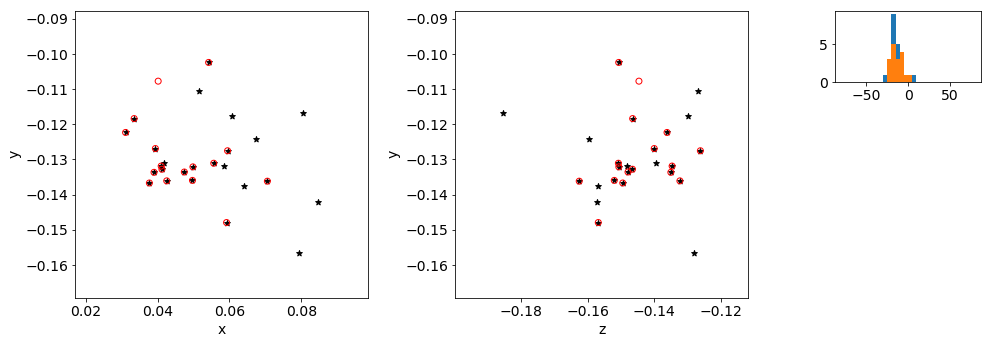

In [593]:
fig = p.figure(figsize=(14,5))
gs1 = p.GridSpec(nrows=1, ncols=3, width_ratios=[2,2,1]) 
gs2 = p.GridSpec(nrows=3, ncols=3, width_ratios=[2,2,1])

fig.add_subplot(gs1[0])
line1 = ds.scatter('x', 'y', selection='exp1==201', marker='*', color='k')
line2 = ds.scatter('x', 'y', selection='exp2==205', marker='o', edgecolor='r', facecolor='none')

fig.add_subplot(gs1[1])
ds.scatter('z', 'y', selection='exp1==201', marker='*', color='k')
ds.scatter('z', 'y', selection='exp2==205', marker='o', edgecolor='r', facecolor='none')

fig.add_subplot(gs2[2])
vx1 = ds.evaluate('vx', selection='exp1==201')
vx2 = ds.evaluate('vx', selection='exp2==205')
p.hist(vx1, bins=arange(-80,85,5))
p.hist(vx2, bins=arange(-80,85,5))

fig.tight_layout()
p.show()

In [743]:
sort(ds.evaluate('exp4', selection='(exp1==206)'))

array([ 28.,  28.,  28.,  28.,  28.,  28.,  28.,  28.,  28.,  28.,  28.,
        28.,  28.,  28.,  28.,  28.,  28.,  nan,  nan,  nan])

In [1392]:
# Results #1

id_1 = [100, 145, 204, 206, 207, 210, 213]
id_2 = [205, 206, 208, 209, 211, 212, 213, 215, 218]
id_3 = [1, 2, 3, 4, 5, 7, 10, 13, 17, 18, 22, 25, 28, 35]
id_4 = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23, 26, 29, 31, 34, 42, 43]

print("Number of selected substructure:", len(id_1)+len(id_2)+len(id_3)+len(id_4))

Number of selected substructure: 57


In [904]:
# Result #2

id_1 = [100, 145, 204, 206, 207, 210]
id_2 = [+205, +206, +208, +209, +211, +212, +213, +215, +218]
id_3 = [+1, +2, +3, +4, +5, +7, +8, +10, +13, +14, +17, +18, +21, +22, +25, +28, +30, +35]
id_4 = [+2, +3, +4, +5, +6, +7, +8, +9, +10, +11, +12, +13, +14, +15, +17, +18, +19, +20, +21, +22, +23, +26, +29, +31, +34, +42, +43]

print("Number of selected substructure:", len(id_1),len(id_2),len(id_3),len(id_4), len(id_1)+len(id_2)+len(id_3)+len(id_4))

Number of selected substructure: 6 9 18 27 60


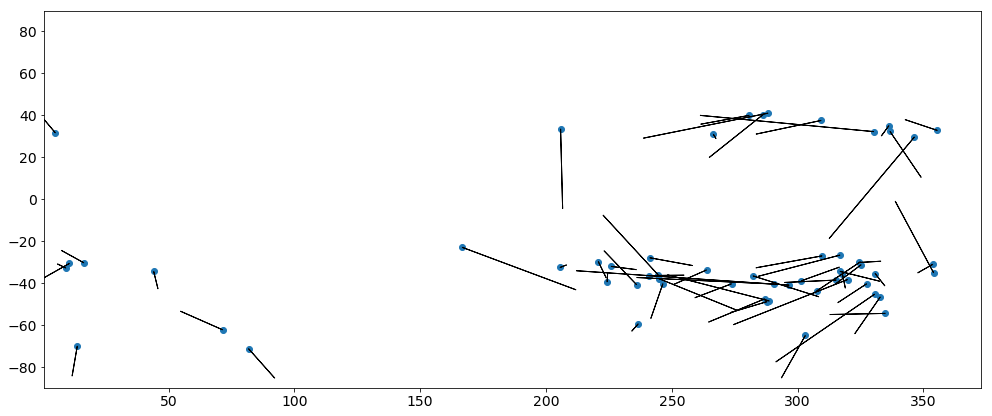

In [1400]:
# all experiment sky arrow

fig = p.figure(figsize=(14,6))
gs = p.GridSpec(nrows=1, ncols=2, width_ratios=[1,1.15])
l = dm.evaluate('(l+360)%360')
b = dm.evaluate('b')
pml = dm.evaluate('pm_l')
pmb = dm.evaluate('pm_b')
p.scatter(l,b)
for i in range(len(b)):
    p.arrow(l[i], b[i], pml[i], pmb[i])
p.xlim(0.360), p.ylim(-90,90)
fig.tight_layout()
# fig.savefig('/net/virgo01/data/users/virgini/rockstar/RC3/output/Report/xyz.png', format='png')
p.show()

In [1406]:
id_1 = [100, 145, 204, 206, 207, 210, 213]
id_2 = [205, 206, 208, 209, 211, 212, 213, 215, 218]
id_3 = [1, 2, 3, 4, 5, 7, 10, 13, 17, 18, 22, 25, 28, 35]
id_4 = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23, 26, 29, 31, 34, 42, 43]

id_all = [id_1, id_2, id_3, id_4]
exp    = ['1.', '2.', '3.', '4.']
select = ['exp1==%s', 'exp2==%s', 'exp3==%s', 'exp4==%s']
folder = '/net/virgo01/data/users/virgini/rockstar/RC3/output/Report/'
gs1 = p.GridSpec(nrows=3, ncols=1)
gs2 = p.GridSpec(nrows=3, ncols=2)

x = zeros(57)
y = zeros(57)
z = zeros(57)
vx = zeros(57)
vy = zeros(57)
vz = zeros(57)

k = 0
for j in range(4):
    for i in id_all[j]:
        ds.select(select[j]  %i, name='sub')
        
        x[k] = median(ds.evaluate('x', selection='sub'))
        y[k] = median(ds.evaluate('y', selection='sub'))
        z[k] = median(ds.evaluate('z', selection='sub'))
        vx[k] = median(ds.evaluate('vx', selection='sub'))
        vy[k] = median(ds.evaluate('vy', selection='sub'))
        vz[k] = median(ds.evaluate('vz', selection='sub'))
        k=k+1

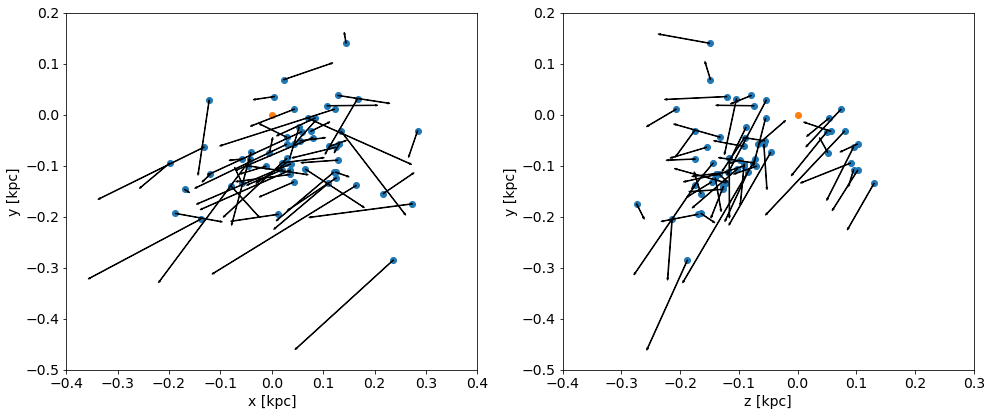

In [1425]:
fig = p.figure(figsize=(14,6))
gs = p.GridSpec(nrows=1, ncols=2)

fig.add_subplot(gs[0])
p.scatter(x, y)
p.scatter(0,0)
for i in range(len(x)):
    p.arrow(x[i], y[i], vx[i]/200, vy[i]/200)
p.xlim(-0.4, 0.4), p.ylim(-0.5,0.2)
p.xlabel('x [kpc]'), p.ylabel('y [kpc]')
fig.add_subplot(gs[1])
p.scatter(z, y)
p.scatter(0,0)
for i in range(len(x)):
    p.arrow(z[i], y[i], vz[i]/200, vy[i]/200)
p.xlim(-0.4, 0.3), p.ylim(-0.5,0.2)
p.xlabel('z [kpc]'), p.ylabel('y [kpc]')
fig.tight_layout()
fig.savefig('/net/virgo01/data/users/virgini/rockstar/RC3/output/Report/xyz_all.png', format='png')
p.show()


In [ ]:
idx = [i[0] for i in sorted(enumerate(sigma), key=lambda x:x[1])] #get the index of the sorted sigma (from the samllest)

In [ ]:
idx[0]

In [ ]:
v1 = vv[:,idx[0]] 
v2 = vv[:,idx[1]] 
v3 = vv[:,idx[2]] 

In [ ]:
select1 = 'exp1 == 100'
select2 = 'exp2 == 102'
select3 = 'exp3 == 6'
select4 = 'exp4 == 35'

legend1 = '1.100'
legend2 = '2.102'
legend3 = '3.6'
legend4 = '4.35'


x1 = ds.evaluate('x', selection=select1)
y1 = ds.evaluate('y', selection=select1)
z1 = ds.evaluate('z', selection=select1)
vx1 = ds.evaluate('vx', selection=select1)
vy1 = ds.evaluate('vy', selection=select1)
vz1 = ds.evaluate('vz', selection=select1)

x2 = ds.evaluate('x', selection=select2)
y2 = ds.evaluate('y', selection=select2)
z2 = ds.evaluate('z', selection=select2)
vx2 = ds.evaluate('vx', selection=select2)
vy2 = ds.evaluate('vy', selection=select2)
vz2 = ds.evaluate('vz', selection=select2)

x3 = ds.evaluate('x', selection=select3)
y3 = ds.evaluate('y', selection=select3)
z3 = ds.evaluate('z', selection=select3)
vx3 = ds.evaluate('vx', selection=select3)
vy3 = ds.evaluate('vy', selection=select3)
vz3 = ds.evaluate('vz', selection=select3)

x4 = ds.evaluate('x', selection=select4)
y4 = ds.evaluate('y', selection=select4)
z4 = ds.evaluate('z', selection=select4)
vx4 = ds.evaluate('vx', selection=select4)
vy4 = ds.evaluate('vy', selection=select4)
vz4 = ds.evaluate('vz', selection=select4)


fig = p.figure(figsize=(14,6))
fig.add_subplot(121)

line3 = p.scatter(x3, y3, s=100, marker='*', facecolors='none', edgecolors='black', zorder=1)
line4 = p.scatter(x4, y4, s=100, marker='o', facecolors='none', edgecolors='red', zorder=1)
line2 = p.scatter(x2, y2, s=100, marker='s', facecolors='none', edgecolors='blue', zorder=1)
line1 = p.scatter(x1, y1, s=100, marker='^', facecolors='none', edgecolors='green', zorder=1)

for j in range(len(x3)):
    p.arrow(x3[j], y3[j], vx3[j]/1000, vy3[j]/1000, lw=0.001, color='grey', zorder=-1)
for j in range(len(x4)):
    p.arrow(x4[j], y4[j], vx4[j]/1000, vy4[j]/1000, lw=0.001, color='grey', zorder=-1)
for j in range(len(x2)):
    p.arrow(x2[j], y2[j], vx2[j]/1000, vy2[j]/1000, lw=0.001, color='grey', zorder=-1)
for j in range(len(x1)):
    p.arrow(x1[j], y1[j], vx1[j]/1000, vy1[j]/1000, lw=0.001, color='grey', zorder=-1)


p.legend([line1, line2, line3, line4], [legend1, legend2, legend3, legend4], loc='lower right', fontsize='large')
p.xlabel('x [kpc]', fontsize='x-large'), p.ylabel('y [kpc]', fontsize='x-large')
p.xticks(fontsize='x-large'), p.yticks(fontsize='x-large')

fig.add_subplot(122)
line3 = p.scatter(z3, y3, s=100, marker='*', facecolors='none', edgecolors='black', zorder=1)
line4 = p.scatter(z4, y4, s=100, marker='o', facecolors='none', edgecolors='red', zorder=1)
line2 = p.scatter(z2, y2, s=100, marker='s', facecolors='none', edgecolors='blue', zorder=1)
line1 = p.scatter(z1, y1, s=100, marker='^', facecolors='none', edgecolors='green', zorder=1)

for j in range(len(x3)):
    p.arrow(z3[j], y3[j], vx3[j]/1000, vy3[j]/1000, lw=0.001, color='grey', zorder=-1)
for j in range(len(x4)):
    p.arrow(z4[j], y4[j], vx4[j]/1000, vy4[j]/1000, lw=0.001, color='grey', zorder=-1)
for j in range(len(x2)):
    p.arrow(z2[j], y2[j], vx2[j]/1000, vy2[j]/1000, lw=0.001, color='grey', zorder=-1)
for j in range(len(x1)):
    p.arrow(z1[j], y1[j], vx1[j]/1000, vy1[j]/1000, lw=0.001, color='grey', zorder=-1)

p.xlabel('z [kpc]', fontsize='x-large'), p.ylabel('y [kpc]', fontsize='x-large')
p.xticks(fontsize='x-large'), p.yticks(fontsize='x-large')

fig.tight_layout()
fig.savefig('/net/virgo01/data/users/virgini/rockstar/RC3/output/selection/share_1100_cartesian.png', format='png')

p.show()

In [ ]:
fig = p.figure(figsize=(14,6))
fig.add_subplot(121)
line3 = p.scatter(vx3, vy3, s=100, marker='*', facecolors='none', edgecolors='black', zorder=1)
line4 = p.scatter(vx4, vy4, s=100, marker='o', facecolors='none', edgecolors='red', zorder=1)
line2 = p.scatter(vx2, vy2, s=100, marker='s', facecolors='none', edgecolors='blue', zorder=1)
line1 = p.scatter(vx1, vy1, s=100, marker='^', facecolors='none', edgecolors='green', zorder=1)
p.legend([line1, line2], [legend1, legend2], loc='upper left', fontsize='large')
p.xlabel('vx [km/s]', fontsize='x-large'), p.ylabel('vy [km/s]', fontsize='x-large')
p.xticks(fontsize='x-large'), p.yticks(fontsize='x-large')
p.xlim(-20,10), p.ylim(-40,-10)
p.legend([line1, line2, line3, line4], [legend1, legend2, legend3, legend4], loc='upper left', fontsize='large')

fig.add_subplot(122)
line3 = p.scatter(vz3, vy3, s=100, marker='*', facecolors='none', edgecolors='black', zorder=1)
line4 = p.scatter(vz4, vy4, s=100, marker='o', facecolors='none', edgecolors='red', zorder=1)
line2 = p.scatter(vz2, vy2, s=100, marker='s', facecolors='none', edgecolors='blue', zorder=1)
line1 = p.scatter(vz1, vy1, s=100, marker='^', facecolors='none', edgecolors='green', zorder=1)
p.xlabel('vz [km/s]', fontsize='x-large'), p.ylabel('vy [km/s]', fontsize='x-large')
p.xticks(fontsize='x-large'), p.yticks(fontsize='x-large')
p.xlim(-30,0), p.ylim(-40,-10)

fig.tight_layout()
fig.savefig('/net/virgo01/data/users/virgini/rockstar/RC3/output/selection/share_1100_vectorpoint.png', format='png')

p.show()

In [ ]:
fig = p.figure(figsize=(14,6))

fig.add_subplot(121)
line3 = ds.scatter('pm_l', 'pm_b', selection=select3, s=100, marker='*', facecolors='none', edgecolors='black')
line4 = ds.scatter('pm_l', 'pm_b', selection=select4, s=100, marker='o', facecolors='none', edgecolors='red')
line2 = ds.scatter('pm_l', 'pm_b', selection=select2, s=100, marker='s', facecolors='none', edgecolors='blue')
line1 = ds.scatter('pm_l', 'pm_b', selection=select1, s=100, marker='^', facecolors='none', edgecolors='green')

p.legend([line1, line2, line3, line4], [legend1, legend2, legend3, legend4], loc='upper left', fontsize='large')
p.xlabel(r'$\mu_l$ [mas/yr]', fontsize='x-large'), p.ylabel(r'$\mu_b$ [mas/yr]', fontsize='x-large')
p.xticks(fontsize='x-large'), p.yticks(fontsize='x-large')

fig.add_subplot(122)
ds.scatter('G - K', 'G', length_check=False, s=1, c='lightgrey')
ds.scatter('G-K', 'G', selection=select3, s=100, marker='*', facecolors='none', edgecolors='black')
ds.scatter('G-K', 'G', selection=select4, s=100, marker='o', facecolors='none', edgecolors='red')
ds.scatter('G-K', 'G', selection=select2, s=100, marker='s', facecolors='none', edgecolors='blue')
ds.scatter('G-K', 'G', selection=select1, s=100, marker='^', facecolors='none', edgecolors='green')
p.xlim(-1,5), p.ylim(9,-5)
p.xlabel('G - K', fontsize='x-large'), p.ylabel('G', fontsize='x-large')
p.xticks(fontsize='x-large'), p.yticks(fontsize='x-large')
p.title(' ')

fig.tight_layout()
# fig.savefig('/net/virgo01/data/users/virgini/rockstar/RC3/output/selection/share_1100_36_pm.png', format='png')

p.show()

In [ ]:
vx = ds.evaluate('vx', selection=select1)
vy = ds.evaluate('vy', selection=select1)
vz = ds.evaluate('vz', selection=select1)

vx2 = ds.evaluate('vx', selection=select2)
vy2 = ds.evaluate('vy', selection=select2)
vz2 = ds.evaluate('vz', selection=select2)

vv = array([vx,vy,vz]).T
vv2 = array([vx2,vy2,vz2]).T

v_pca = pca.fit_transform(vv)
sigma = sqrt(pca.explained_variance_)

v_pca2 = pca.fit_transform(vv2)
sigma2 = sqrt(pca.explained_variance_)

for i in range(3):
    print(min(v_pca[:,i]), max(v_pca[:,i]))
    print(min(v_pca2[:,i]), max(v_pca2[:,i]))

In [ ]:
fig = p.figure(figsize=(14,4))
gs  = p.GridSpec(1,3)
for i in range(3):
    fig.add_subplot(gs[i])
    p.hist(v_pca[:,i],  bins=arange(-20,25,5), color='black', histtype='step', label=r'$\sigma = %s$' %round(sigma[i], 2))
    p.hist(v_pca2[:,i], bins=arange(-20,25,5), color='red', histtype='step', label=r'$\sigma = %s$' %round(sigma2[i],2))
    p.xlabel(r'V$_%s$' %str(i+1), fontsize='x-large'), p.ylabel('N', fontsize='x-large')
    p.xlim(-30,30), p.ylim(0,40)
    p.legend(loc='upper left', fontsize='large')

fig.tight_layout()
fig.savefig('/net/virgo01/data/users/virgini/rockstar/RC3/output/selection/share_1100_36_sigma.png', format='png')

p.show()

In [ ]:
xx = ds.evaluate('vx', selection=select1)
yy = ds.evaluate('vy', selection=select1)
zz = ds.evaluate('vz', selection=select1)

xx2 = ds.evaluate('vx', selection=select2)
xy2 = ds.evaluate('vy', selection=select2)
xz2 = ds.evaluate('vz', selection=select2)

rr = array([xx,yy,zz]).T
rr2 = array([xx2,yy2,zz2]).T

r_pca = pca.fit_transform(rr)
sigma_r = sqrt(pca.explained_variance_)

r_pca2 = pca.fit_transform(rr2)
sigma_r2 = sqrt(pca.explained_variance_)

fig = p.figure(figsize=(14,4))

p.subplot(121)
for j in range(3):
    p.scatter(1, sigma_r[j], s=100, marker='*', color='black')
    p.scatter(2, sigma_r2[j], s=100, marker='o', facecolor='None', edgecolor='red')
    p.xticks(arange(0,3,1), ('', legend1, legend2, ''), fontsize='x-large')
    p.ylabel('Size', fontsize='x-large')
    p.xlim(0,3), p.ylim(0,10)
    p.yticks(fontsize='x-large')

p.subplot(122)
for j in range(3):
    p.scatter(1, sigma[j], s=100, marker='*', color='black')
    p.scatter(2, sigma2[j], s=100, marker='o', facecolor='None', edgecolor='red')
    p.xticks(arange(0,3,1), ('', legend1, legend2, ''), fontsize='x-large')
    p.ylabel(r'$\sigma_v$', fontsize='x-large')
    p.xlim(0,3), p.ylim(0,10)
    p.yticks(fontsize='x-large')
    
fig.tight_layout()
fig.savefig('/net/virgo01/data/users/virgini/rockstar/RC3/output/selection/share_1_rank.png', format='png')

p.show()

#### 3. Check (again, final) if there are the same stars in between the 57 substructures. If so, delete the bigger one.

In [ ]:
id_all = [id_1, id_2, id_3, id_4]
exp    = ['1.', '2.', '3.', '4.']

In [ ]:
empty = []
for j in range(4):
    for i in tqdm(id_all[j], desc='Loading'):
        arr1 = ds.evaluate('rockstar_id', selection='exp%s == %s' %(4, 23))
        arr2 = ds.evaluate('rockstar_id', selection='exp%s == %s' %(j+1, i))
        same = intersect1d(arr1, arr2) 
        if same != empty:
            print(j+1, i, len(same))

In [ ]:
id_all = [id_1, id_2, id_3, id_4]
exp    = ['1.', '2.', '3.', '4.']

## Calculate the properties

Since the id of the substructures depends on which experiment it comes from, we have to treat it one by one (per experiment). However, maybe we can make a csv document to open and write the data in a new line, without deleting the previous data.

In [ ]:
output = '/net/virgo01/data/users/virgini/rockstar/RC3/output/master-table.csv'

# write the header in the file
with open(output, 'w') as f:
    writer = csv.writer(f, delimiter=',', lineterminator='\n')
    writer.writerow(['flag', 'n_star', 'x_med', 'y_med', 'z_med', 'l', 'b', 'd', 'r', 'a', 'size', 'vel', 'vr', 'std_vr', \
                    'pm_l', 'std_pm_l', 'pm_b', 'std_pm_b', 'met', 'met_std'])
    f.close()
    
# write the data from the first experiment
with open(output, 'a') as f:
    writer = csv.writer(f, delimiter=',', lineterminator='\n')
    
    id_all = [id_1, id_2, id_3, id_4]
    exp    = ['1.', '2.', '3.', '4.']
    select = ['exp1==%s', 'exp2==%s', 'exp3==%s', 'exp4==%s']
    
    for j in range(4):
        for i in id_all[j]:
            ds.select(select[j]  %i, name='sub')

            # from which experiment
            flag = exp[j]+str(i)
            
            # number of stars
            n_star = ds.selected_length(selection='sub')
            
            # data of position and velocity
            x = ds.evaluate('x', selection='sub')
            y = ds.evaluate('y', selection='sub')
            z = ds.evaluate('z', selection='sub')
            vx = ds.evaluate('vx', selection='sub')
            vy = ds.evaluate('vy', selection='sub')
            vz = ds.evaluate('vz', selection='sub')

            # data subtracted by mean
            x2 = x - mean(x)
            y2 = y - mean(y)
            z2 = z - mean(z)
            vx2 = vx - mean(vx)
            vy2 = vy - mean(vy)
            vz2 = vz - mean(vz)
            lensub = len(x)

            # The convariance
            cxx, cyy, czz = sum(x2*x2)/(lensub-1), sum(y2*y2)/(lensub-1), sum(z2*z2)/(lensub-1)
            cxy, cxz, cyz = sum(x2*y2)/(lensub-1), sum(x2*z2)/(lensub-1), sum(y2*z2)/(lensub-1)
            cvxx, cvyy, cvzz = sum(vx2*vx2)/(lensub-1), sum(vy2*vy2)/(lensub-1), sum(vz2*vz2)/(lensub-1)
            cvxy, cvxz, cvyz = sum(vx2*vy2)/(lensub-1), sum(vx2*vz2)/(lensub-1), sum(vy2*vz2)/(lensub-1)

            # Put covariance in matrix
            cov_r = [[cxx, cxy, cxz], [cxy, cyy, cyz], [cxz, cyz, czz]]
            cov_v = [[cvxx, cvxy, cvxz], [cvxy, cvyy, cvyz], [cvxz, cvyz, cvzz]]

            # Calculate eigenvalues and eigenvectors
            er, vr = linalg.eig(cov_r) #eigenvalues w (3), eigenvectors v (3x3)
            ev, vv = linalg.eig(cov_v)

            # The size of the system
            size = (sqrt((er[0]+er[1]+er[2])/3))*1000
            vel  = sqrt((ev[0]+ev[1]+ev[2])/3)
            
            # median position of the substructure
            x_med = median(x)
            y_med = median(y)
            z_med = median(z)  

            # distance (kpc)
            d = median(ds.evaluate('best_distance', selection='sub'))

            # position in galactic & equatorial coordinate
            l = arctan2(y_med,x_med)*180/pi
            b = (-arccos(z_med/d)+pi/2)*180/pi
            
            # radius containing 100% and 68% of members (kpc)
            R = sort(ds.evaluate('sqrt((x-%s)**2+(y-%s)**2+(z-%s)**2)' %(x_med,y_med,z_med), selection='sub'))
            r = max(R)
            A = int(0.68*len(R))
            a = R[A-1]
            
            # radial velocity and its sigma
            vr     = ds.evaluate('HRV', selection='sub').mean()
            std_vr = ds.evaluate('HRV', selection='sub').std()

            # proper motion
            pm_l   = ds.evaluate('pm_l', selection='sub').mean()
            pm_b   = ds.evaluate('pm_b', selection='sub').mean()
            
            # dispersion of proper motion
            std_pm_l   = ds.evaluate('pm_l', selection='sub').std()
            std_pm_b   = ds.evaluate('pm_b', selection='sub').std()
            
            # metallicity and its sigma (avoid nan!)
            Met_K   = ds.evaluate('Met_K', selection='sub')
            Met_K   = Met_K[~isnan(Met_K)]
            met     = Met_K.mean()
            met_std = Met_K.std()
            
            writer.writerow([flag, n_star, x_med, y_med, z_med, l, b, d, r, a, size, vel, vr, std_vr, \
                            pm_l, std_pm_l, pm_b, std_pm_b, met, met_std])
    f.close()
print('finish')

# Result: Master table and its properties

In [1426]:
output = '/net/virgo01/data/users/virgini/rockstar/RC3/output/master-table.csv'
dm = vaex.from_ascii(output, seperator=',')

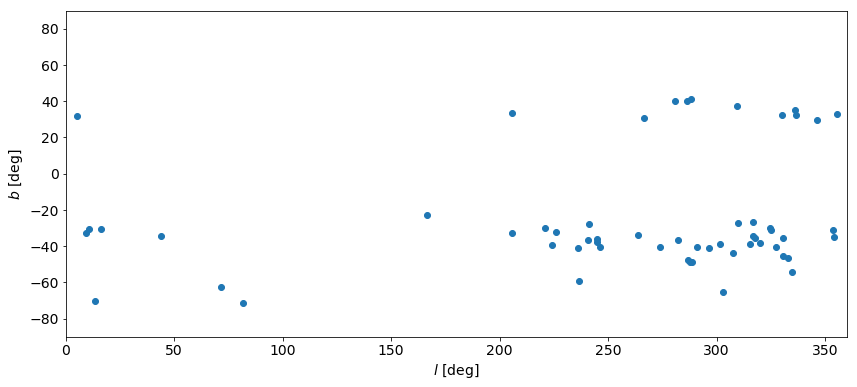

In [1432]:
fig = p.figure(figsize=(14,6))
dm.scatter('(l+360)%360', 'b')
p.xlabel(r'$l$ [deg]'), p.ylabel(r'$b$ [deg]')
p.xlim(0,360), p.ylim(-90,90)
p.show()

In [1260]:
dm

column,type,unit,description,expression
flag,float64,,,
n_star,int64,,,
x_med,float64,,,
y_med,float64,,,
z_med,float64,,,
l,float64,,,
b,float64,,,
d,float64,,,
r,float64,,,
a,float64,,,


In [ ]:
tmp_pdf = '/net/virgo01/data/users/virgini/rockstar/RC3/output/master-properties.pdf'
with PdfPages(tmp_pdf) as pdf:
    
    fig = p.figure(figsize=(14,20))
    fig.suptitle('Properties of the Substructures', fontsize='large', y=0.95)
    gs = p.GridSpec(nrows=12,ncols=2)
    
    properties = dm.get_column_names()
    
    for i in range(24):
        fig.add_subplot(gs[i])
        dm.plot1d(properties[i+1])
    
    fig.tight_layout(rect=[0.03,0.03,0.96,0.92])
    pdf.savefig(fig)
    
print('finish')

In [ ]:
p.close('all')

# Master Plots

In [ ]:
id_1 = [100, 145, 204, 206, 207, 210, 213]
id_2 = [205, 206, 208, 209, 211, 212, 213, 215, 218]
id_3 = [1, 2, 3, 4, 5, 7, 10, 13, 17, 18, 22, 25, 28, 35]
id_4 = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23, 26, 29, 31, 34, 42, 43]

In [ ]:
id_all = [id_1, id_2, id_3, id_4]
exp    = ['1-', '2-', '3-', '4-']
select = ['exp1==%s', 'exp2==%s', 'exp3==%s', 'exp4==%s']
folder = '/net/virgo01/data/users/virgini/rockstar/RC3/output/properties/'

for j in range(4):
    for i in tqdm(id_all[j], desc='Loading'):        
        ds.select(select[j]  %i, name='sub')
        # from which experiment
        flag = exp[j]+str(i)
        fig = p.figure(figsize=(10,10))
        gs = p.GridSpec(ncols=2, nrows=2, wspace=0)
        p.subplot(gs[0])
        ds.scatter('x_pc', 'y_pc', s=3, selection='sub')
        p.xlim(-400,400), p.ylim(-400,400)
        p.xticks(arange(-200,201,200), fontsize='x-large'), p.yticks(arange(-200,201,200), fontsize='x-large')
        p.xlabel(r'$x$ (kpc)', fontsize='x-large'), p.ylabel(r'$y$ (kpc)', fontsize='x-large')
        p.text(-350, 320, 'Substructure %s' %flag, fontsize='x-large')
        p.subplot(gs[1])
        ds.scatter('z_pc', 'y_pc', s=3, selection='sub')
        p.xlim(-400,400), p.ylim(-400,400)
        p.xticks(arange(-200,201,200), fontsize='x-large'), p.yticks(visible=False)
        p.xlabel(r'$z$ (kpc)', fontsize='x-large'), p.ylabel('')
        
        p.subplot(gs[2])
        ds.scatter('vx', 'vy', s=3, selection='sub')
        p.xlim(-200,200), p.ylim(-200,200)
        p.xticks(arange(-100,101,100), fontsize='x-large'), p.yticks(arange(-100,101,100), fontsize='x-large')
        p.xlabel(r'$v_x$ (kpc)', fontsize='x-large'), p.ylabel(r'$v_y$ (kpc)', fontsize='x-large')
        p.subplot(gs[3])
        ds.scatter('vz', 'vy', s=3, selection='sub')
        p.xlim(-200,200), p.ylim(-200,200)
        p.xticks(arange(-100,101,100), fontsize='x-large'), p.yticks(visible=False)
        p.xlabel(r'$v_z$ (kpc)', fontsize='x-large'), p.ylabel('')
        
#         p.subplot(gs[4])
#         ds.scatter('pm_l', 'pm_b', s=3, selection='sub')
#         p.xlim(-400,400), p.ylim(-400,400)
#         p.xticks(arange(-200,201,200)), p.yticks(arange(-200,201,200))
        fig.tight_layout()
        name = os.path.join(folder + str(flag))
        fig.savefig(name, format='png')
#         p.show()
        p.close()

In [ ]:
ds.add_virtual_columns_proper_motion2vperpendicular(distance='best_distance')

In [ ]:
id_all = [id_1, id_2, id_3, id_4]
exp    = ['1-', '2-', '3-', '4-']

lim=100
lim2=0.5

for j in range(4):
    for i in tqdm(id_all[j], desc='Loading'):        
        ds.select(select[j]  %i, name='sub')
        flag = exp[j]+str(i)
        p.figure(figsize=(14,14))
        p.subplot(331)
        ds.scatter('x', 'y', s=7, c='black', selection='sub')
        p.xlim(-lim2,lim2), p.ylim(-lim2,lim2)
        p.subplot(332)
        ds.scatter('z', 'y', s=7, c='black', selection='sub')
        p.xlim(-lim2,lim2), p.ylim(-lim2,lim2)
        p.subplot(334)
        ds.scatter('vx', 'vy', s=7, c='black', selection='sub')
        p.xlim(-lim,lim), p.ylim(-lim,lim)
        p.subplot(335)
        ds.scatter('vz', 'vy', s=7, c='black', selection='sub')
        p.xlim(-lim,lim), p.ylim(-lim,lim)
        p.subplot(337)
        ds.scatter('vl', 'vb', s=7, c='black', selection='sub')
        p.xlim(-lim,lim), p.ylim(-lim,lim)
        p.subplot(338)
        ds.scatter('HRV', 'vb', s=7, c='black', selection='sub')
        p.xlim(-lim,lim), p.ylim(-lim,lim)
        p.subplot(339)
        ds.scatter('pm_l', 'pm_b', s=7, c='black', selection='sub')
        p.xlim(-lim,lim), p.ylim(-lim,lim)
        name = os.path.join('/net/virgo01/data/users/virgini/rockstar/RC3/output/Report/' + '4vel-' + str(flag) + '.png')
        p.savefig(name, format='png')
        p.close()

# Search for more members in TGAS

Now take the stars from tgas dataset. Since the position of stars in TGAS dataset is only available in the equatorial and galactic coordinate, we have to calculate the position in the Cartesian coordinate using vaex (add virtual column from spherical to cartesian). This will transform ra-dec-distance into x-y-z. We will read the complete TGAS dataset as dt.

In [1070]:
dt = vaex.open('/net/gaia/data/users/breddels/data/tgas/x_allwise_2mass_tycho2/tgas_x_allwise_2mass_tycho2_extra.hdf5') #data tgas
# dt.add_virtual_columns_spherical_to_cartesian(alpha='l', delta='b', distance='distance') #add position in x,y,z

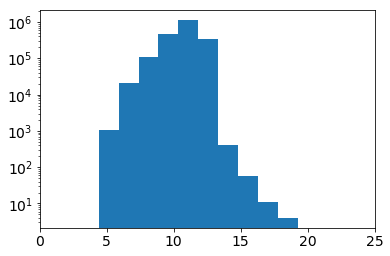

In [1083]:
data = dt.evaluate('phot_g_mean_mag')
p.hist(data)
p.yscale('log')
p.xlim(0,25)
p.show()

In [1085]:
dt.evaluate('phot_g_mean_mag').max()

19.30785743194954

In [ ]:
dt.scatter('distance_uncertainty', '1/parallax_error', selection='(parallax >=0) & (parallax_error/parallax <= 0.3)', length_check=False)
p.show()

In [ ]:
a = dt.evaluate('distance_uncertainty', selection='(parallax >=0) & (parallax_error/parallax <= 0.3)')
b = dt.evaluate('parallax_error', selection='(parallax >=0) & (parallax_error/parallax <= 0.3)')
p.hist(a, alpha=0.5)
p.hist(b, alpha=0.5)
p.yscale('log')
p.show()

# Search for more members in TGAS (second try)

September 19 -- Now we want to make a selection of members in TGAS dataset based on position on the sky (l and b) instead of in the Cartesian coordinate, together with motion on the sky. This is to prevent selection based on distance. What we did previously (selecting stars based on Cartesian position but cutting by proper motion) is not preferable since it's going back and forth between 2 coordinate system, and one of it depends on distance, which we want to avoid. What we will do next is as following:
1. Select members based on separation on the sky (first have to find out how to do this, what is the formula, google it!) OK
2. Select members based on pm_l and pm_b OK
3. Additional selection: calculate the mean parallax from tgas-rave members, and select tgas members by 1 or 2 sigma. See how it looks.
4. Always keep an eye on how many members before and after cut, especially by the parallax cut.
5. Plot pm_l versus pm_b (just like when we plot vx versus vy).
6. Plot also the color magnitude diagram.

In [ ]:
dt.add_virtual_column('G', 'phot_g_mean_mag+5*log10(parallax)-10')
dt.add_virtual_column('K', 'ks_m+5*log10(parallax)-10')
# dt.add_virtual_column('B', '0.85*(bt_mag+5*log10(parallax)-10)')
# dt.add_virtual_column('V', '0.85*(vt_mag+5*log10(parallax)-10)')

## Member selection based on position $(l, b)$, proper motion $(\mu_l, \mu_b)$, and parallax $(\pi)$

Instead of using range of degree as criteria of selection -- which can be a problem when the substructure ranges from 350 to 10 degree -- we use the great-circle distance between two points on the sky given their longitudes and latitudes.

In [ ]:
# radius containing 100% and 68% of members
D2 = ds.evaluate('arctan2(sqrt((cos(deg2rad(b))*sin(abs(deg2rad(l)-%s)))**2+\
                (cos(%s)*sin(deg2rad(b))-sin(%s)*cos(deg2rad(b))*cos(abs(deg2rad(l)-%s)))**2),\
                (sin(%s)*sin(deg2rad(b))+cos(%s)*cos(deg2rad(b))*cos(abs(deg2rad(l)-%s))))'\
                %(deg2rad(l_med), deg2rad(b_med), deg2rad(b_med), deg2rad(l_med), deg2rad(b_med),\
                deg2rad(b_med),deg2rad(l_med)), selection='sub')

# define selection in TGAS dataset based on position in l and b (and positive distance)
dt.select('(arctan2(sqrt((cos(deg2rad(b))*sin(abs(deg2rad(l)-%s)))**2+\
        (cos(%s)*sin(deg2rad(b))-sin(%s)*cos(deg2rad(b))*cos(abs(deg2rad(l)-%s)))**2),\
        (sin(%s)*sin(deg2rad(b))+cos(%s)*cos(deg2rad(b))*cos(abs(deg2rad(l)-%s)))) <= %s)\
        & (distance>=0)' %(deg2rad(l_med), deg2rad(b_med), deg2rad(b_med), deg2rad(l_med),\
        deg2rad(b_med), deg2rad(b_med), deg2rad(l_med), r), name='position')

In [ ]:
# find stars in certain region on the sky, using the distance in l and b

id_all = [id_1, id_2, id_3, id_4]
exp    = ['1.', '2.', '3.', '4.']
select = ['exp1==%s', 'exp2==%s', 'exp3==%s', 'exp4==%s']
folder = '/net/virgo01/data/users/virgini/rockstar/RC3/output/Report/'
gs1 = p.GridSpec(nrows=3, ncols=1)
gs2 = p.GridSpec(nrows=3, ncols=2)

# tmp_pdf = '/net/virgo01/data/users/virgini/rockstar/RC3/output/Report/Experiment_1_tgas_member.pdf'
# with PdfPages(tmp_pdf) as pdf:

for j in [0]: #range(4):
    for i in [209]: #tqdm(id_all[j], desc='Loading'):

        ds.select(select[j]  %i, name='sub')

        # from which experiment
        flag = exp[j]+str(i)

        # data of tgas-rave stars
        n = ds.selected_length(selection='sub')
        l = ds.evaluate('l', selection='sub')
        b = ds.evaluate('b', selection='sub')
        pm_l = ds.evaluate('pm_l', selection='sub')
        pm_b = ds.evaluate('pm_b', selection='sub')
        parallax = ds.evaluate('best_parallax', selection='sub')
        relative_parallax_error = ds.evaluate('best_parallax_error/best_parallax', selection='sub')

        # median position on the sky
        l_med = median(ds.evaluate('l', selection='sub'))
        b_med = median(ds.evaluate('b', selection='sub'))
        pm_l_med = median(ds.evaluate('pm_l', selection='sub'))
        pm_b_med = median(ds.evaluate('pm_b', selection='sub'))

        # radius containing 100% and 68% of members
        D = ds.evaluate('arccos(sin(deg2rad(b))*sin(%s) + cos(deg2rad(b))*cos(%s)*cos(abs(deg2rad(l)-(%s))))'\
                         %(deg2rad(b_med), deg2rad(b_med), deg2rad(l_med)), selection='sub')
               
        R = sort(D)
        r = max(R)
        A = int(0.68*len(R))
        a = R[A-1]

        # define selection in TGAS dataset based on position in l and b (and positive distance)
        dt.select('(arccos(sin(deg2rad(b))*sin(%s) + cos(deg2rad(b))*cos(%s)*cos(abs(deg2rad(l)-(%s)))) <= %s)\
                  & (distance>=0)' %(deg2rad(b_med), deg2rad(b_med), deg2rad(l_med), r), name='position')

        # define selection in TGAS dataset based on proper motion
        dt.select('(abs(pm_l - %s)/%s <= 1) & (abs(pm_b - %s)/%s <= 1)' %(str('%.55f' %median(pm_l)),\
                  str('%.55f' %std(pm_l)), str('%.55f' %median(pm_b)), str('%.55f' %std(pm_b))), name='motion')
        
        # define selection in TGAS dataset based on parallax
        dt.select('(abs(parallax - %s) / sqrt(parallax_error**2 + %s)) <= 1' \
                  %(str('%.55f' %median(parallax)), str('%.55f' %(std(parallax)**2))), name='par')

        n_tgas = dt.selected_length(selection='position')
        l_tgas = dt.evaluate('l', selection='position')
        b_tgas = dt.evaluate('b', selection='position')

        n_member = dt.selected_length(selection='(position) & (motion) & (par)')
        l_member = dt.evaluate('l', selection='(position) & (motion) & (par)')
        b_member = dt.evaluate('b', selection='(position) & (motion) & (par)')
        parallax_member = dt.evaluate('parallax', selection='(position) & (motion) & (par)')
        relative_parallax_error_member = dt.evaluate('parallax_error/parallax', selection='(position) & (motion) & (par)')

        fig = p.figure(figsize=(14, 20))

        l[l < 180] += 360
        l[l > 180] -= 360
        l_member[l_member < 180] += 360
        l_member[l_member > 180] -= 360
        l_tgas[l_tgas < 180] += 360
        l_tgas[l_tgas > 180] -= 360

        ax = fig.add_subplot(gs1[0])
        p.title(('Experiment %s - Substructure %s' %(j+1, i)), fontsize='x-large')
        line3 = p.scatter(l_tgas, b_tgas, s=3, c='lightgrey')
        line2 = p.scatter(l_member, b_member, s=50, c='red')
        line1 = p.scatter(l, b, s=10, c='blue')
        p.xlabel(r'$l$ (deg)', fontsize='x-large'), p.ylabel(r'$b$ (deg)', fontsize='x-large')
        p.xticks(fontsize='x-large'), p.yticks(fontsize='x-large')
        p.legend([line1, line2, line3], ['tgas-rave members (%s)' %n, 'tgas members (%s)' %n_member, 'field stars (%s)' %n_tgas], loc='upper left')

        ticks = ax.get_xticks()
        ticks[ticks < 0] += 360
        ax.set_xticklabels([int(tick) for tick in ticks])

        fig.add_subplot(gs2[2])
        line3 = dt.scatter('pm_l', 'pm_b', s=3, c='lightgrey', selection='position', length_check=False)
        line2 = dt.scatter('pm_l', 'pm_b', s=3, c='red', selection='(position) & (motion) & (par)')
        line1 = ds.scatter('pm_l', 'pm_b', s=3, c='blue', selection='sub')
        p.xlabel(r'$\mu_l$ (mas/yr)', fontsize='x-large'), p.ylabel(r'$\mu_b$ (mas/yr)', fontsize='x-large')
        p.xticks(fontsize='x-large'), p.yticks(fontsize='x-large')
        limit = 150
        p.xlim(-limit, limit), p.ylim(-limit, limit)

        fig.add_subplot(gs2[3])
        line3 = dt.scatter('G - K', 'G', s=3, c='lightgrey', selection='position', length_check=False)
        line2 = dt.scatter('G - K', 'G', s=3, c='red', selection='(position) & (motion) & (par)')
        line1 = ds.scatter('G - K', 'G', s=3, c='blue', selection='sub')
        p.xlabel(r'$G - K$', fontsize='x-large'), p.ylabel(r'$G$', fontsize='x-large')
        p.xticks(fontsize='x-large'), p.yticks(fontsize='x-large')
        p.xlim(-1,5), p.ylim(9, -5)

        fig.add_subplot(gs2[4])
        bins = arange(0,15,0.5)
        line2 = p.hist(parallax_member, histtype='step', color='red', bins=bins)
        line1 = p.hist(parallax, histtype='step', color='blue', bins=bins)
        p.xlabel(r'$\pi$ (mas)', fontsize='x-large'), p.ylabel(r'$N$', fontsize='x-large')
        p.xticks(fontsize='x-large'), p.yticks(fontsize='x-large')

        fig.add_subplot(gs2[5])
        bins = arange(0,1.1,0.05)
        line2 = p.hist(relative_parallax_error_member, histtype='step', color='red', bins=bins)
        line1 = p.hist(relative_parallax_error, histtype='step', color='blue', bins=bins)
        p.xlabel(r'$\delta_{\pi}$', fontsize='xx-large'), p.ylabel(r'$N$', fontsize='x-large')
        p.xticks(fontsize='x-large'), p.yticks(fontsize='x-large')

        p.show()
#         fig.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])
#         name = os.path.join(folder + str(j+1) + '-' + str(i) + '-68'+ '.png')
#         file = fig.savefig(name, format='png')
#         pdf.savefig(file)
#         p.close()
            
print('finish')
# print('Substructure', flag, '|', n_member+n_add, 'stars')

In [ ]:
dm.to_pandas_df(selection='flag == 4.13')

In [ ]:
median(ds.evaluate('best_distance', selection='sub')), ds.evaluate('best_distance', selection='sub').std()
median(dt.evaluate('distance', selection='(position) & (motion) & (par)')), dt.evaluate('distance', selection='(position) & (motion) & (par)').std()

In [ ]:
for j in range(4):
    for i in id_all[j]:
        name = '%s-%s.pdf' %(j+1,i)
        #print('\includepdf[pages=-]{pdf/%s}' %name)

In [ ]:
folder = '/net/virgo01/data/users/virgini/rockstar/RC3/output/properties_5d/'

fig = p.figure(figsize=(20, 14))
gs1 = p.GridSpec(nrows=2, ncols=3)
gs2 = p.GridSpec(nrows=2, ncols=3)

l[l < 180] += 360
l[l > 180] -= 360
l_member[l_member < 180] += 360
l_member[l_member > 180] -= 360
l_tgas[l_tgas < 180] += 360
l_tgas[l_tgas > 180] -= 360

ax = fig.add_subplot(gs1[0,:-1])
p.title(('Substructure %s' %flag), fontsize='x-large')
line3 = p.scatter(l_tgas, b_tgas, s=3, c='lightgrey')
line2 = p.scatter(l_member, b_member, c='red')
line1 = p.scatter(l, b, c='blue')
p.xlabel(r'$l$ (deg)', fontsize='x-large'), p.ylabel(r'$b$ (deg)', fontsize='x-large')
p.xticks(fontsize='x-large'), p.yticks(fontsize='x-large')
p.legend([line1, line2, line3], ['tgas-rave members (%s)' %n, 'tgas members (%s)' %n_member, 'field stars (%s)' %n_tgas], loc='upper left')

ticks = ax.get_xticks()
ticks[ticks < 0] += 360
ax.set_xticklabels([int(tick) for tick in ticks])

fig.add_subplot(gs1[2])
line3 = dt.scatter('pm_l', 'pm_b', s=3, c='lightgrey', selection='position', length_check=False)
line2 = dt.scatter('pm_l', 'pm_b', s=3, c='red', selection='(position) & (motion) & (par)')
line1 = ds.scatter('pm_l', 'pm_b', s=3, c='blue', selection='sub')
p.xlabel(r'$\mu_l$ (mas/yr)', fontsize='x-large'), p.ylabel(r'$\mu_b$ (mas/yr)', fontsize='x-large')
p.xticks(fontsize='x-large'), p.yticks(fontsize='x-large')
limit = 150
p.xlim(-limit, limit), p.ylim(-limit, limit)

fig.add_subplot(gs2[3])
line3 = dt.scatter('G - K', 'G', s=3, c='lightgrey', selection='position', length_check=False)
line2 = dt.scatter('G - K', 'G', s=3, c='red', selection='(position) & (motion) & (par)')
line1 = ds.scatter('G - K', 'G', s=3, c='blue', selection='sub')
p.xlabel(r'$G - K$', fontsize='x-large'), p.ylabel(r'$G$', fontsize='x-large')
p.xticks(fontsize='x-large'), p.yticks(fontsize='x-large')
p.xlim(-1,5), p.ylim(9, -5)

fig.add_subplot(gs2[4])
bins = arange(0,15,0.2)
line2 = p.hist(parallax_member, histtype='step', color='red', bins=bins)
line1 = p.hist(parallax, histtype='step', color='blue', bins=bins)
p.xlabel(r'$\pi$ (mas)', fontsize='x-large'), p.ylabel(r'$N$', fontsize='x-large')
p.xticks(fontsize='x-large'), p.yticks(fontsize='x-large')

fig.add_subplot(gs2[5])
bins = arange(0,1.1,0.05)
line2 = p.hist(relative_parallax_error_member, histtype='step', color='red', bins=bins)
line1 = p.hist(relative_parallax_error, histtype='step', color='blue', bins=bins)
p.xlabel(r'$\delta_{\pi}$', fontsize='xx-large'), p.ylabel(r'$N$', fontsize='x-large')
p.xticks(fontsize='x-large'), p.yticks(fontsize='x-large')

fig.tight_layout(rect=[0.02,0.02,0.94,0.93])
name = os.path.join(folder + str(flag))
fig.savefig(name, format='png')

p.show()

In [ ]:
fig = p.figure(figsize=(14, 7))

radius=0.15
x = median(ds.evaluate('x', selection='sub'))
y = median(ds.evaluate('y', selection='sub'))
z = median(ds.evaluate('z', selection='sub'))
mark = [[x-0.05, y], [x-0.1, y], [x+0.05, y], [x+0.1, y]]

ax = fig.add_subplot(121)
p.scatter(x, y, marker='x', c='red')
dt.scatter('x', 'y', s=1, c='grey', selection='position', length_check=False)
dt.scatter('x', 'y', s=7, selection='(position) & (motion) & (par)')
ds.scatter('x', 'y', s=7, selection='sub')
p.axvline(x, c='grey'), p.axhline(y, c='grey')
p.scatter([x-0.05, x-0.1, x+0.05, x+0.1], [y,y,y,y], marker='+', c='grey')
p.scatter([x,x,x,x], [y-0.05, y-0.1, y+0.05, y+0.1], marker='+', c='grey')
p.xlabel(r'x (kpc)', fontsize='x-large'), p.ylabel(r'y (kpc)', fontsize='x-large')
p.xticks(fontsize='x-large'), p.yticks(fontsize='x-large')
p.xlim(x-radius, x+radius), p.ylim(y-radius, y+radius)

fig.add_subplot(122)
p.scatter(z, y, marker='x', c='red')
dt.scatter('z', 'y', s=1, c='grey', selection='position', length_check=False)
dt.scatter('z', 'y', s=7, selection='(position) & (motion) & (par)')
ds.scatter('z', 'y', s=7, selection='sub')
p.axvline(z, c='grey'), p.axhline(y, c='grey')
p.scatter([z-0.05, z-0.1, z+0.05, z+0.1], [y,y,y,y], marker='+', c='grey')
p.scatter([z,z,z,z], [y-0.05, y-0.1, y+0.05, y+0.1], marker='+', c='grey')
p.xlabel(r'z (kpc)', fontsize='x-large'), p.ylabel('')
p.xticks(fontsize='x-large'), p.yticks(fontsize='x-large')
p.xlim(z-radius, z+radius), p.ylim(y-radius, y+radius)

fig.tight_layout()
p.show()

In [ ]:
fig = p.figure(figsize=(14, 7))
fig.add_subplot(121)
p.xlim(-50, 50), p.ylim(-30,80)
dt.scatter('pm_l', 'pm_b', s=1, c='grey', selection='position', length_check=False)
# dt.scatter('pm_l*cos(b)', 'pm_b', s=3, selection='(position) & (motion) & (par)')
# ds.scatter('pm_l*cos(b)', 'pm_b', s=3, selection='sub')
p.xlabel(r'$\mu_l$ (mas/yr)', fontsize='x-large'), p.ylabel(r'$\mu_b$ (mas/yr)', fontsize='x-large')
p.xticks(fontsize='x-large'), p.yticks(fontsize='x-large')

fig.add_subplot(122, sharex=ax, sharey=ax)
dt.scatter('pm_l', 'pm_b', s=3, selection='(position) & (motion) & (par)')
ds.scatter('pm_l', 'pm_b', s=3, selection='sub')
p.xlabel(r'$\mu_l$ (mas/yr)', fontsize='x-large'), p.ylabel(r'$\mu_b$ (mas/yr)', fontsize='x-large')
p.xticks(fontsize='x-large'), p.yticks(fontsize='x-large')

p.show()

In [ ]:
fig = p.figure(figsize=(14, 7))
ax = fig.add_subplot(121)
dt.plot1d('parallax_error', c='grey', selection='position')
p.xlabel(r'$\pi$ (mas)', fontsize='x-large'), p.ylabel(r'$N$', fontsize='x-large')
p.xticks(fontsize='x-large'), p.yticks(fontsize='x-large')

fig.add_subplot(122)
dt.plot1d('parallax_error', limits='minmax', selection='(position) & (motion) & (par)  & (something)')
ds.plot1d('parallax_error', limits='minmax', selection='sub')
p.xlabel(r'$\pi$ (mas)', fontsize='x-large'), p.ylabel(r'$N$', fontsize='x-large')
p.xticks(fontsize='x-large'), p.yticks(fontsize='x-large')

p.show()

In [ ]:
p.hist('')

# Compilation of figures (add to loop if necessary)

In [ ]:
fig = p.figure(figsize=(14, 7))

fig.add_subplot(121)
dt.scatter('G-K', 'G', s=1, c='grey', selection='position', length_check=False)
p.xlim(-1,5), p.ylim(9, -5)
p.xlabel('G - K', fontsize='x-large'), p.ylabel('G', fontsize='x-large')
p.xticks(fontsize='x-large'), p.yticks(fontsize='x-large')

fig.add_subplot(122)
dt.scatter('G-K', 'G', s=1, c='lightgrey', selection='position', length_check=False)
dt.scatter('G-K', 'G', s=3, selection='(position) & (motion) & (par) & (something)')
# dt.scatter('G-K', 'G', s=10, selection='(position) & (motion) & (par) & (parallax_error>0.4)', c='red')
ds.scatter('G-K', 'G', s=3, selection='sub')
p.xlim(-1,5), p.ylim(9, -5)
p.xlabel('G - K', fontsize='x-large'), p.ylabel('G', fontsize='x-large')
p.xticks(fontsize='x-large'), p.yticks(fontsize='x-large')

p.show()

# Addition of new columns to the master table 

In [ ]:
# This is to add column in master table to keep track how many additional stars from tgas, 1_sigma, 2_sigma
idx = 0
array_n_tgas = zeros(57)
array_n_1sigma_parallax = zeros(57)
array_n_2sigma_parallax = zeros(57)

# put this code into the loop, just in case we need to fix something. This is to make an array.
sigma_1_min = mean(parallax)-std(parallax)
sigma_1_max = mean(parallax)+std(parallax)
sigma_2_min = mean(parallax)-2*std(parallax)
sigma_2_max = mean(parallax)+2*std(parallax)

array_n_tgas[idx] = int(len(parallax_tgas))
array_n_1sigma_parallax[idx] = int(len(parallax_tgas[(parallax_tgas >= sigma_1_min) & (parallax_tgas <= sigma_1_max)]))
array_n_2sigma_parallax[idx] = int(len(parallax_tgas[(parallax_tgas >= sigma_2_min) & (parallax_tgas <= sigma_2_max)]))
idx = idx + 1

# to put the array into the master table.
dm.add_column(name='n_tgas', data=array_n_tgas)
dm.add_column(name='n_1sigma_parallax', data=array_n_1sigma_parallax)
dm.add_column(name='n_2sigma_parallax', data=array_n_2sigma_parallax)

# This is to add column in master table to calculate the new l and new b based on 1 sigma parallax membership
idx = 0
array_l_1sigma = zeros(57)
array_b_1sigma = zeros(57)
array_l_1sigma[idx] = median(l_tgas_cut)
array_b_1sigma[idx] = median(b_tgas_cut)        
idx = idx + 1

# to put the array into the master table.
dm.add_column(name='l_1sigma', data=array_l_1sigma)
dm.add_column(name='b_1sigma', data=array_b_1sigma)

In [ ]:
# The shift of position in l and b between rockstar and tgas-1sigma-parallax
p.figure(figsize=(14,3))
p.hist(abs(dm.data.l - dm.data.l_1sigma), alpha=0.5, bins=arange(0,41,1), label='l')
p.hist(abs(dm.data.b - dm.data.b_1sigma), alpha=0.5, bins=arange(0,41,1), label='b')
p.xticks(arange(0,41,1))
p.legend()
p.show()

In [ ]:
dob = dm.to_pandas_df(column_names=['flag', 'l_1sigma', 'b_1sigma'])
dob = dob[['flag', 'l_1sigma', 'b_1sigma']]

In [ ]:
dob.to_csv('/net/virgo01/data/users/virgini/rockstar/RC3/output/crossmatch-55', sep=',', index=False)

In [ ]:
ds.select('(l > 340) & (l < 360) & (b > 10) & (b < 30) & (parallax > 5) & (parallax < 15)', name='US')

In [ ]:
ds.select('(arctan2(sqrt((cos(deg2rad(b))*sin(abs(deg2rad(l)-%s)))**2+\
         (cos(%s)*sin(deg2rad(b))-sin(%s)*cos(deg2rad(b))*cos(abs(deg2rad(l)-%s)))**2),\
         (sin(%s)*sin(deg2rad(b))+cos(%s)*cos(deg2rad(b))*cos(abs(deg2rad(l)-%s)))) <= %s) \
         & (pm_l >= %s) & (pm_l <= %s) & (pm_b >= %s) & (pm_b <= %s) & (best_distance>0) & \
         (parallax >= %s) & (parallax <= %s)' %(deg2rad(l_med), deg2rad(b_med),\
         deg2rad(b_med), deg2rad(l_med), deg2rad(b_med), deg2rad(b_med),deg2rad(l_med),\
         r, min(pm_l), max(pm_l), min(pm_b), max(pm_b), sigma_1_min, sigma_1_max), name='US')

In [ ]:
l_us = ds.evaluate('l', selection='US')
b_us = ds.evaluate('b', selection='US')
pm_l_us = ds.evaluate('pm_l', selection='US')
pm_b_us = ds.evaluate('pm_b', selection='US')

fig = p.figure(figsize=(7,5))
p.title(r'TGAS $\times$ RAVE', fontsize='x-large')
p.scatter(l_us, b_us)
for i in range(ds.selected_length(selection='US')):
    p.arrow(l_us[i], b_us[i], pm_l_us[i]/10, pm_b_us[i]/10)
p.xlim(330, 360), p.ylim(10, 30)
p.xlabel(r'$l$ (deg)', fontsize='x-large'), p.ylabel(r'$b$ (deg)', fontsize='x-large')
p.xticks(fontsize='x-large'), p.yticks(fontsize='x-large')
fig.tight_layout()
p.show()
fig.savefig('/net/virgo01/data/users/virgini/rockstar/RC3/output/properties/US-tgas-rave.png', format='png')

In [ ]:
output

In [ ]:
dt.select('(arctan2(sqrt((cos(deg2rad(b))*sin(abs(deg2rad(l)-%s)))**2+\
         (cos(%s)*sin(deg2rad(b))-sin(%s)*cos(deg2rad(b))*cos(abs(deg2rad(l)-%s)))**2),\
         (sin(%s)*sin(deg2rad(b))+cos(%s)*cos(deg2rad(b))*cos(abs(deg2rad(l)-%s)))) <= %s) \
         & (pm_l >= %s) & (pm_l <= %s) & (pm_b >= %s) & (pm_b <= %s) & (distance>0) & \
         (parallax >= %s) & (parallax <= %s)' %(deg2rad(l_med), deg2rad(b_med),\
         deg2rad(b_med), deg2rad(l_med), deg2rad(b_med), deg2rad(b_med),deg2rad(l_med),\
         r, min(pm_l), max(pm_l), min(pm_b), max(pm_b), sigma_1_min, sigma_1_max), name='US_tgas')

In [ ]:
l_us_tgas = dt.evaluate('l', selection='US_tgas')
b_us_tgas = dt.evaluate('b', selection='US_tgas')
pm_l_us_tgas = dt.evaluate('pm_l', selection='US_tgas')
pm_b_us_tgas = dt.evaluate('pm_b', selection='US_tgas')

fig = p.figure(figsize=(7,5))
p.title(r'TGAS', fontsize='x-large')
p.scatter(l_us_tgas, b_us_tgas)
for i in range(dt.selected_length(selection='US_tgas')):
    p.arrow(l_us_tgas[i], b_us_tgas[i], pm_l_us_tgas[i]/10, pm_b_us_tgas[i]/10)
p.xlim(330, 360), p.ylim(10, 30)
p.xlabel(r'$l$ (deg)', fontsize='x-large'), p.ylabel(r'$b$ (deg)', fontsize='x-large')
p.xticks(fontsize='x-large'), p.yticks(fontsize='x-large')
fig.tight_layout()
p.show()
fig.savefig('/net/virgo01/data/users/virgini/rockstar/RC3/output/properties/US-tgas.png', format='png')

## The crossmatch between rockstar subs and OB association

In [ ]:
dob = vaex.from_csv('/net/virgo01/data/users/virgini/rockstar/RC3/output/properties/crossmatch-55-md')
dob.add_column('sep', dob.data.Separation/3600)
dob.head()

## The distribution of all RS, OB-A, and OC ---- why don't they match?

In [1433]:
md = vaex.from_csv('/net/virgo01/data/users/virgini/rockstar/RC3/output/crossmatch-md')
daml = vaex.from_csv('/net/virgo01/data/users/virgini/rockstar/RC3/output/crossmatch-daml.tsv', sep=';')

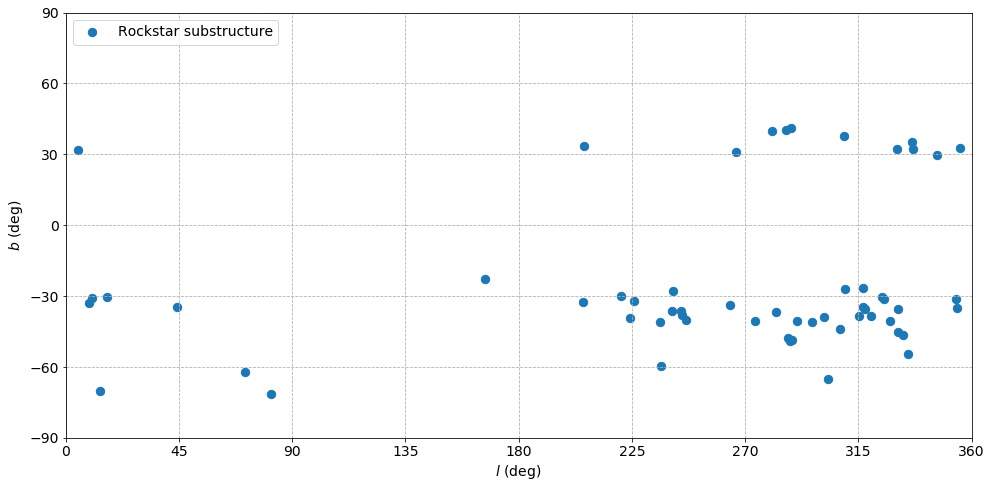

In [1443]:
fig = p.figure(figsize=(14,7))
# dt.scatter('l', 'b', s=1, length_check=False)
# ds.scatter('l', 'b', s=1, length_check=False)
# dt.plot('l', 'b', f='log', colormap='gray', colorbar=False)
# ds.plot('l', 'b', f='log', colormap='autumn', colorbar=False)
p.scatter((dm.data.l+360)%360, dm.data.b, marker='o', s=70, label='Rockstar substructure', zorder=1)
# p.scatter(dm.data.l_1sigma, dm.data.b_1sigma, marker='x', color='orange', label=r'Rockstar substructure (1$\sigma_{\pi}$)')
# p.scatter(daml.data.l, daml.data.b, marker='*', color='dodgerblue', label='Open cluster (Dias et al, 2002)', zorder=-1)
# p.scatter(md.data.l, md.data.b, marker='o', color='black', label='OB association (Melnik & Dambis, 2017)', zorder=0)
p.xlabel(r'$l$ (deg)'), p.ylabel(r'$b$ (deg)')
p.xticks(arange(0,360+45,45),), p.yticks(arange(-90,90+30,30))
p.ylim(-90, 90), p.xlim(0, 360)
p.legend(loc='upper left')
p.grid(linestyle='--')
fig.tight_layout()
p.show()
fig.savefig('/net/virgo01/data/users/virgini/rockstar/RC3/output/properties/crossmatch-all2.png', format='png')

## Calculating $\tilde{\sigma_v}$ (as reference for 5d)

In [ ]:
ds.add_virtual_columns_lbrvr_proper_motion2vcartesian(long_in='l', lat_in='b', distance='best_distance', pm_long='pm_l', pm_lat='pm_b', vr='0', vx='vx_tilda', vy='vy_tilda', vz='vz_tilda')

In [ ]:
sigma = zeros(len(dm)+1)
sigma_tilda = zeros(len(dm)+1)

k = 0
for j in range(4):
    for i in tqdm(id_all[j], desc='Loading'):
        ds.select(select[j]  %i, name='sub')
        vx_sigma = ds.evaluate('vx', selection='sub').std()
        vy_sigma = ds.evaluate('vy', selection='sub').std()
        vz_sigma = ds.evaluate('vz', selection='sub').std()
        vx_sigma_tilda = ds.evaluate('vx_tilda', selection='sub').std()
        vy_sigma_tilda = ds.evaluate('vy_tilda', selection='sub').std()
        vz_sigma_tilda = ds.evaluate('vz_tilda', selection='sub').std()
        sigma[k] = sqrt((vx_sigma**2)+(vy_sigma**2)+(vz_sigma**2))
        sigma_tilda[k] = sqrt((vx_sigma_tilda**2)+(vy_sigma_tilda**2)+(vz_sigma_tilda**2))
        k = k+1

In [ ]:
m, b = polyfit(sigma[(sigma_tilda <= 1.5*sigma) & (sigma<10)], sigma_tilda[(sigma_tilda <= 1.5*sigma) & (sigma<10)], 1)

p.figure(figsize=(7,7))
p.plot([0,20], [0,20],'-', c='grey')
p.plot(sigma[(sigma_tilda <= 1.5*sigma) & (sigma<10)], m*sigma[(sigma_tilda <= 1.5*sigma) & (sigma<10)]+b, '-', c='black')
p.scatter(sigma[sigma<10], sigma_tilda[sigma<10])
p.scatter(sigma[(sigma_tilda >= 1.5*sigma) & (sigma<10)], sigma_tilda[(sigma_tilda >= 1.5*sigma) & (sigma<10)], c='red')
p.xlim(0,20), p.ylim(0,20)
p.xlabel(r'$\sigma$', fontsize='xx-large'), p.ylabel(r'$\tilde{\sigma}}$', fontsize='xx-large')
p.xticks(fontsize='x-large'), p.yticks(fontsize='x-large')
p.savefig('/net/virgo01/data/users/virgini/rockstar/RC3/output/sigma_corr.jpg', format='jpg')
p.show()

## Finding more members in tgas dataset using the star ID

In [ ]:
# add rockstar id to tgas dataset
dt.add_column(name='rockstar_id', f_or_array=arange(len(dt)))

# data of rockstar experiment
exp2_5d = '/net/virgo01/data/users/virgini/rockstar/RC3/output/b5-f80-n10-t70-5d-particles'
exp4_5d = '/net/virgo01/data/users/virgini/rockstar/RC3/output/b20-f80-n10-t70-5d-particles'
names = ['x', 'y', 'z', 'vx', 'vy', 'vz', 'rs_id', 'as_int_id', 'int_id', 'ext_id']
de2_raw = vaex.from_ascii(exp2_5d, names=names)
de4_raw = vaex.from_ascii(exp4_5d, names=names)

# select only the real substructure
de2 = de2_raw.to_copy(selection='(as_int_id == int_id) & (ext_id != -1)')
de4 = de4_raw.to_copy(selection='(as_int_id == int_id) & (ext_id != -1)')

# rename the column that we are going to use to make is short and handy
de2.rename_column(name='ext_id', new_name='exp2_5d')
de4.rename_column(name='ext_id', new_name='exp4_5d')

# join the results to the original dataset
dt._join('rockstar_id', de2, 'rs_id', column_names=['exp2_5d'])
dt._join('rockstar_id', de4, 'rs_id', column_names=['exp4_5d'])

Since the coordinate of the stars (l and b) is unique for each stars, we can use it to match between ds and dt and see if stars that belong to a substructure in ds also belong to substructure in dt. Hopefully one corresponds to one, we'll see.

In [ ]:
id_2

In [ ]:
arr1 = ds.evaluate('l', selection='exp2==211')
id_4_5d = zeros(len(arr1))
j = 0
for i in arr1:
    id_4_5d[j] = dt.data.exp4_5d[dt.data.l == i]
    j = j+1
intersect1d(id_4_5d, id_4_5d_sigma)

In [ ]:
i = 'exp2==211'
j = 'exp4_5d==2486'

p.subplot(121)
dt.scatter('l', 'b', selection=j)
ds.scatter('l', 'b', s=3, selection=i)
p.subplot(122)
dt.scatter('pm_l', 'pm_b', selection=j)
ds.scatter('pm_l', 'pm_b', s=3, selection=i)
p.show()

p.subplot(121)
dt.scatter('G-K', 'G', selection=j)
ds.scatter('G-K', 'G', s=3, selection=i)
p.xlim(-1,5), p.ylim(9, -5)
p.subplot(122)
dt.plot1d('parallax', selection=j)
ds.plot1d('parallax', selection=i)
p.show()

In [ ]:
ds.evaluate('l', selection='(exp1 == 100) & (exp1 == 145) & (exp1 == 204) & (exp1 == 210) & (exp2 == 205) & \
(exp2 == 206) & (exp2 == 207) & (exp2 == 208) & (exp2 == 209) & (exp2 == 211) & \
(exp2 == 212) & (exp2 == 215) & (exp2 == 218) & (exp3 == 1) & (exp3 == 2) & \
(exp3 == 3) & (exp3 == 4) & (exp3 == 5) & (exp3 == 7) & (exp3 == 10) & (exp3 == 13) & \
(exp3 == 17) & (exp3 == 22) & (exp3 == 25) & (exp3 == 28) & (exp3 == 35) & (exp4 == 2) & \
(exp4 == 3) & (exp4 == 4) & (exp4 == 5) & (exp4 == 6) & (exp4 == 7) & (exp4 == 8) & \
(exp4 == 9) & (exp4 == 10) & (exp4 == 11) & (exp4 == 12) & (exp4 == 13) & (exp4 == 14) & \
(exp4 == 15) & (exp4 == 17) & (exp4 == 18) & (exp4 == 19) & (exp4 == 20) & (exp4 == 23) & \
(exp4 == 26) & (exp4 == 29) & (exp4 == 31) & (exp4 == 34) & (exp4 == 42) & (exp4 == 43)')

In [ ]:
# id_2_5d_all = zeros(len(unique(dt.data.exp2_5d[~isnan(dt.data.exp2_5d)])))
id_4_5d_all = zeros(len(unique(dt.data.exp4_5d[~isnan(dt.data.exp4_5d)]))+2)
# for i in unique(dt.data.exp2_5d[~isnan(dt.data.exp2_5d)]).astype('int'):
for i in unique(dt.data.exp4_5d[~isnan(dt.data.exp4_5d)]).astype('int'):
#     dt.select('exp2_5d == %s' %i, name='sub')
    dt.select('exp4_5d == %s' %i, name='sub')
    sigma_vx_tilde = dt.evaluate('vx_tilda', selection='sub').std()
    sigma_vy_tilde = dt.evaluate('vy_tilda', selection='sub').std()
    sigma_vz_tilde = dt.evaluate('vz_tilda', selection='sub').std()
    sigma_tilde = sqrt(sigma_vx_tilde**2 + sigma_vy_tilde**2 + sigma_vz_tilde**2)
    if (sigma_tilde <= 10) & (dt.selected_length(selection='sub') < 1000):
#         id_2_5d_all[i] = i
        id_4_5d_all[i] = i
    else:
#         id_2_5d_all[i] = 'nan'
        id_4_5d_all[i] = 'nan'

## Check if stars from the 55 substructures are in the TGAS substructure

In [ ]:
exp2_5d_halo = '/net/virgo01/data/users/virgini/rockstar/RC3/output/b5-f80-n10-t70-5d-halo'
exp4_5d_halo = '/net/virgo01/data/users/virgini/rockstar/RC3/output/b20-f80-n10-t70-5d-halo'
dh2 = vaex.from_ascii(exp2_5d_halo)
dh4 = vaex.from_ascii(exp4_5d_halo)
n_all2 = dh2.evaluate('num_p').sum()
n_all4 = dh4.evaluate('num_p').sum()
n_max2 = dh2.evaluate('num_p').max()
n_max4 = dh4.evaluate('num_p').max()
print(len(dh2), n_all2, n_max2, n_max2/n_all2, len(dh4), n_all4, n_max4, n_max4/n_all4)

In [ ]:
dm.evaluate('n_star').sum()

In [ ]:
id_all = [id_1, id_2, id_3, id_4]
exp    = ['1.', '2.', '3.', '4.']
select = ['exp1==%s', 'exp2==%s', 'exp3==%s', 'exp4==%s']

# stars from 5d substructures
# arr_tgas = dt.evaluate('source_id', selection='(exp2_5d <= 7000)')
# arr_tgas = dt.evaluate('source_id', selection='(exp4_5d <= 3000)')
# arr_tgas = dt.evaluate('source_id', selection='(exp2_5d <= 7000) & (exp2_5d != 6526)')
# arr_tgas = dt.evaluate('source_id', selection='(exp4_5d <= 7000) & (exp4_5d != 2592)')

idx = 0
for j in range(4):
    for i in id_all[j]:
        ds.select(select[j]  %i, name='sub')
        flag = exp[j]+str(i)
        
        # stars from 6d substructures
        arr_tgasrave = ds.evaluate('source_id', selection='sub')
        common = intersect1d(arr_tgasrave, arr_tgas)
        
        # number of stars in common
        n_common = len(common)
        n_tgasrave = ds.selected_length(selection='sub')
        
        # from which substructure in 5d?
        id_5d = zeros(len(common))
        for k in range(len(common)):
            id_5d[k] = dt.data.exp4_5d[dt.data.source_id == common[k]]
            
        # print if not all stars in 6d appear in 5d
        if n_common/n_tgasrave < 1:
            # print(flag, n_common, '/', n_tgasrave, len(unique(id_5d)))#, unique(id_5d))
            
            # check if the stars from 6d are not in 5d because the distance comes from rave
            for k in range(len(arr_tgasrave)):
                if arr_tgasrave[k] not in common:
                    if ds.data.best_parallax_from[ds.data.source_id == arr_tgasrave[k]] == b'rave':
                        print(flag, n_tgasrave-n_common, 'rave')
                        
        idx = idx+1

In [ ]:
unique(ds.evaluate('best_parallax_from', selection='exp3==25'), return_counts=True)

In [ ]:
for j in range(4):
    for i in id_all[j]:
        ds.select(select[j]  %i, name='sub')
        flag = exp[j]+str(i)
        print(flag, unique(ds.evaluate('best_parallax_from', selection='sub')))

In [ ]:
n_common_total.sum(), dm.evaluate('n_star').sum()

In [ ]:
dh2.data.id[dh2.data.num_p == dh2.data.num_p.max()]

In [ ]:
dh2.to_astropy_table(selection='id == 5974')

In [ ]:
p.hist(dm.data.size*1000)
p.show()

In [ ]:
len(id_4)

In [ ]:
dm.select('(flag > 1.0) & (flag < 2.0)', name='exp1')
dm.select('(flag > 2.0) & (flag < 3.0)', name='exp2')
dm.select('(flag > 3.0) & (flag < 4.0)', name='exp3')
dm.select('(flag > 4.0) & (flag < 5.0)', name='exp4')


idx = 0
label = ['Exp 1 (7)', 'Exp 2 (9)', 'Exp 3 (14)', 'Exp 4 (27)']
fig = p.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='polar')
for i in ['exp1', 'exp2', 'exp3', 'exp4']:
    n = dm.data.n_star
    l = deg2rad(dm.evaluate('l', selection=i))
    d = dm.evaluate('d', selection=i)*1000
    s = dm.evaluate('size', selection=i)
    ax.scatter(l, d, s=6*s, alpha=0.8, label=label[idx])
    idx = idx+1
ax.set_rmax(500)
ax.set_xticklabels([r'$l = 0^{\circ}$', ' ', r'$l = 90^{\circ}$', ' ', r'$l = 180^{\circ}$', ' ', r'$l = 270^{\circ}$'], fontsize='x-large')
ax.set_yticklabels(['100 pc', '200 pc', '300 pc', '400 pc', '500 pc'], fontsize='x-large')
ax.set_rlabel_position(135)
ax.spines['polar'].set_visible(False)
ax.grid(linestyle='-')
ax.legend(fontsize='x-large')
fig.tight_layout()
# fig.savefig('/net/virgo01/data/users/virgini/rockstar/RC3/output/Report/dist-l-d.png', format='png')
p.show()

In [ ]:
dm.data.size*1000

In [ ]:
# Creating one column consist of substructure id (the final)

flag = zeros(len(id_1)+len(id_2)+len(id_3)+len(id_4))
idx = 0

for j in range(4):
    for i in id_all[j]:
        flag[idx] = exp[j]
        idx += 1

my_id = [id_1, id_2, id_3, id_4]
str_my_id = ['exp1', 'exp2', 'exp3', 'exp4']
sub_id = ones(len(ds)) * -1
exp_id = ones(len(ds)) * -1
counter = 1

for i,(v,vs) in enumerate(zip(my_id, str_my_id)):
    for j,w in enumerate(v):
        ind = ds.evaluate(vs)==w
        sub_id[arange(len(ds))[ind]] = counter
        exp_id[arange(len(ds))[ind]] = flag[counter-1]
        counter+=1

ds.add_column(name='sub_id', f_or_array=sub_id.astype('int'))
ds.add_column(name='exp_id', f_or_array=exp_id.astype('int'))

In [ ]:
# Make a flag of which stars always appear in all experiment

ds.select('(exp1>=0) & (exp2>=0) & (exp3>=0) & (exp4>=0)', name='four')
ds.evaluate('source_id', selection='four').shape

my_star  = ds.evaluate('source_id', selection='four')
all_star = ds.evaluate('source_id')

persistence = ones(len(ds)) * -1
common = intersect1d(my_star, all_star)
for i in range(len(ds)):
    if ds.data.source_id[i] in common:
        persistence[i] = 1
ds.add_column(name='persist', f_or_array=persistence)

In [ ]:
for i in range(300):
    print(unique(ds.evaluate('persist', selection='exp1==%s' %i), return_counts=True))

In [ ]:
ds.select('(l>170) & (l<190) & (b>-33) & (b<-13)', name='Hyades')
l = ds.evaluate('l', selection='Hyades')
b = ds.evaluate('b', selection='Hyades')
pm_l = ds.evaluate('pm_l', selection='Hyades')
pm_b = ds.evaluate('pm_b', selection='Hyades')

p.scatter(l, b)
for i in range(len(l)):
    p.arrow(l[i], b[i], pm_l[i]/100, pm_b[i]/100, width=0)
p.show()

data = ds.evaluate('best_distance', selection='Hyades')
p.hist(data)
p.show()

len(l), l.mean(), b.mean()

In [ ]:
from scipy import stats

In [ ]:
data1 = ds.evaluate('vx')
data2 = ds.evaluate('vx', selection='(exp_id>=1) & (exp_id<=4)')

In [ ]:
p.hist(data1, bins=arange(-500,510,10))
p.hist(data4, bins=arange(-500,510,10))
p.show()

In [ ]:
data3 = ds.evaluate('vx', selection='exp_id==4')
stats.ks_2samp(data1, data3)

In [ ]:
data4 = dh4.evaluate('vx')
stats.ks_2samp(data1, data4)

In [ ]:
data4 = dh4.evaluate('vx')
stats.ks_2samp(data4, data1)

In [ ]:
random.seed(12345678)  #fix random seed to get the same result
n1 = 200  # size of first sample
n2 = 300  # size of second sample

# For a different distribution, we can reject the null hypothesis since the pvalue is below 1%:

rvs1 = stats.norm.rvs(size=n1, loc=0., scale=1)
rvs2 = stats.norm.rvs(size=n2, loc=0.5, scale=1.5)
stats.ks_2samp(rvs1, rvs2)

In [ ]:
p.hist(rvs1, bins=arange(-5,5.5,0.5), alpha=0.5)
p.hist(rvs2, bins=arange(-5,5.5,0.5), alpha=0.5)
p.show()

In [ ]:
rvs4 = stats.norm.rvs(size=n2, loc=0.0, scale=1.0)
stats.ks_2samp(rvs1, rvs4)

In [ ]:
p.hist(rvs1, bins=arange(-5,5.5,0.5), alpha=0.5)
p.hist(rvs4, bins=arange(-5,5.5,0.5), alpha=0.5)
p.show()

In [ ]:
a = [1,2,3]
b = [1,2,3]
stats.ks_2samp(a,b)

In [ ]:
a = [1,2,3]
b = [78,79,80]
stats.ks_2samp(a,b)

In [ ]:
arr1 = ds.evaluate('source_id')
arr2 = dt.evaluate('source_id', selection='parallax_error/parallax <= 0.2')
len(intersect1d(arr1, arr2)), len(ds), (len(ds)-len(intersect1d(arr1, arr2)))/len(ds)

<string>:1: RuntimeWarning: invalid value encountered in greater_equal
/net/baade/data/users/jovan/miniconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


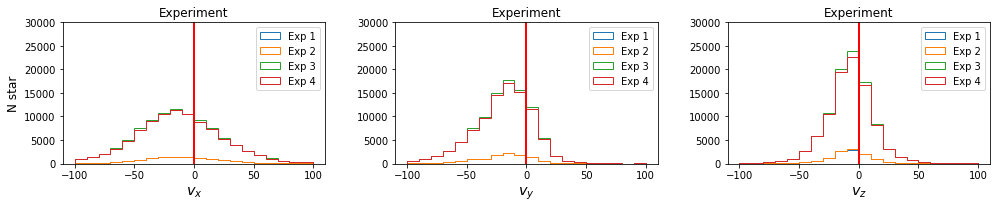

In [6]:
ds = dre
fig = p.figure(figsize=(14,3))
gs = p.GridSpec(nrows=1, ncols=3)
bins = arange(-100, 100+10, 10)
xlabel=[r'$v_x$', r'$v_y$', r'$v_z$']
# ylabel=['N star',' ',' ']
ylabel=['N star',' ']
# label=['Exp 1', 'Exp 2', 'Exp 3', 'Exp 4']
label=['Exp 5', 'Exp 6']

for i in range(2):
    ds.select('exp%s >= 0' %str(i+1), name='exp')
    vx = ds.evaluate('vx', selection='exp')
    vy = ds.evaluate('vy', selection='exp')
    vz = ds.evaluate('vz', selection='exp')
    v = [vx, vy, vz]
    for k in range(3):
        fig.add_subplot(gs[k])
        p.hist(v[k], bins=bins, histtype='step', label=label[i])
        p.xlabel(xlabel[k], fontsize='x-large')
        p.ylabel(ylabel[k], fontsize='large')
        p.title('Experiment', fontsize='large')
        p.axvline(0, c='red')
        p.legend()
        p.ylim(0,30000)
fig.tight_layout()
p.savefig('/net/virgo01/data/users/virgini/rockstar/RC3/output/Vel-dis-subs-56.png', format='png')
p.show()


In [ ]:
x1 = ds.evaluate('x', selection='exp1==214')
y1 = ds.evaluate('y', selection='exp1==214')

In [906]:
array = ds.evaluate('x')*1000
ds.add_column(name='x_pc', f_or_array=array)
array = ds.evaluate('y')*1000
ds.add_column(name='y_pc', f_or_array=array)
array = ds.evaluate('z')*1000
ds.add_column(name='z_pc', f_or_array=array)

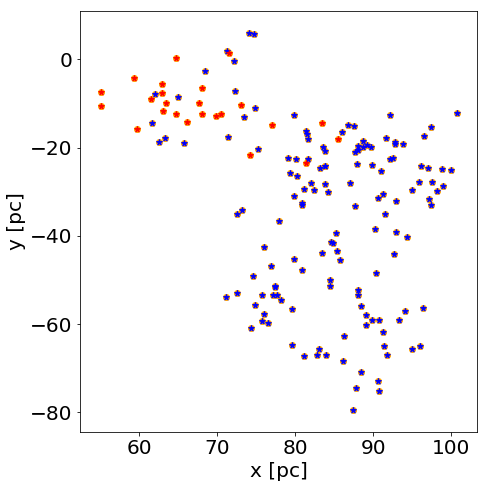

In [908]:
fig = p.figure(figsize=(7,7))
line1 = ds.scatter('x_pc', 'y_pc', marker='o', c='orange', selection='exp1==224')
line2 = ds.scatter('x_pc', 'y_pc', marker='*', c='blue', selection='exp2==228')
line3 = ds.scatter('x_pc', 'y_pc', marker='*', c='red', selection='exp2==229')
# p.legend([line1, line2, line3], ['Exp 1 (277 stars)', 'Exp 2 (16 stars, 10 in common)', 'Exp 2 (45 stars, 26 in common)'], loc='upper left')
p.xlabel('x [pc]', fontsize='x-large'), p.ylabel('y [pc]', fontsize='x-large')
p.xticks(fontsize='x-large'), p.yticks(fontsize='x-large')
# p.xlim(10,170), p.ylim(-150,20)
fig.tight_layout()
# p.savefig('/net/virgo01/data/users/virgini/rockstar/RC3/output/parent-child-12.png', format='png')
p.show()

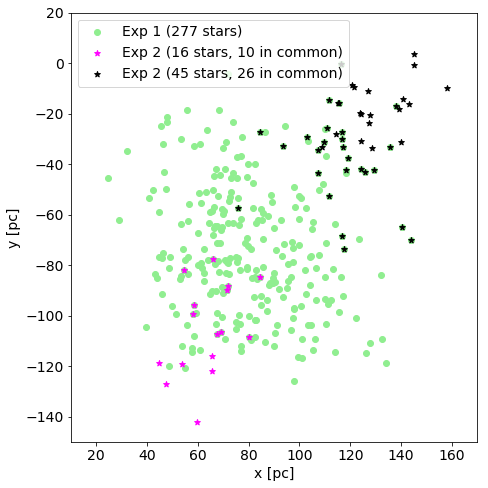

In [968]:
fig = p.figure(figsize=(7,7))
line1 = ds.scatter('x_pc', 'y_pc', marker='o', c='lightgreen', selection='exp1==214')
line2 = ds.scatter('x_pc', 'y_pc', marker='*', c='fuchsia', selection='exp2==208')
line3 = ds.scatter('x_pc', 'y_pc', marker='*', c='black', selection='exp2==217')
p.legend([line1, line2, line3], ['Exp 1 (277 stars)', 'Exp 2 (16 stars, 10 in common)', 'Exp 2 (45 stars, 26 in common)'], loc='upper left')
p.xlabel('x [pc]'), p.ylabel('y [pc]')
p.xlim(10,170), p.ylim(-150,20)
fig.tight_layout()
p.savefig('/net/virgo01/data/users/virgini/rockstar/RC3/output/parent-child-12.png', format='png')
p.show()

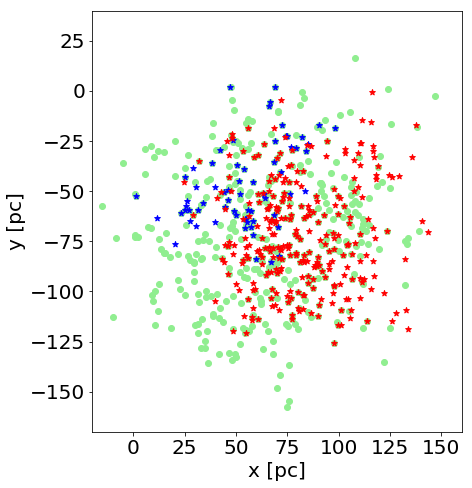

In [924]:
fig = p.figure(figsize=(7,7))
line1 = ds.scatter('x_pc', 'y_pc', marker='o', c='lightgreen', selection='exp2==216')
# line2 = ds.scatter('x_pc', 'y_pc', marker='*', c='blue', selection='exp1==207')
# line3 = ds.scatter('x_pc', 'y_pc', marker='*', c='black', selection='exp1==210')
line4 = ds.scatter('x_pc', 'y_pc', marker='*', c='blue', selection='exp1==213')
line5 = ds.scatter('x_pc', 'y_pc', marker='*', c='red', selection='exp1==214')
p.legend([line1, line2, line4, line5], ['Exp 2 (434 stars)', 'Exp 1 (54 stars, 43 in common)', 'Exp 1 (66 stars, 50 in common)', 'Exp 1 (277 stars, 103 in common)'], loc='upper left')
p.xlabel('x [pc]', fontsize='x-large'), p.ylabel('y [pc]', fontsize='x-large')
p.xticks(fontsize='x-large'), p.yticks(fontsize='x-large')
p.xlim(-20,160), p.ylim(-170,40)
fig.tight_layout()
# p.savefig('/net/virgo01/data/users/virgini/rockstar/RC3/output/parent-child-21.png', format='png')
p.show()

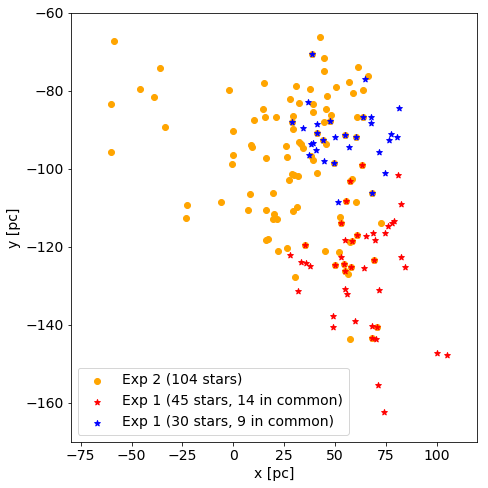

In [970]:
fig = p.figure(figsize=(7,7))
line1 = ds.scatter('x_pc', 'y_pc', marker='o', c='orange', selection='exp2==213')
line2 = ds.scatter('x_pc', 'y_pc', marker='*', c='red', selection='exp1==202')
line3 = ds.scatter('x_pc', 'y_pc', marker='*', c='blue', selection='exp1==205')
p.legend([line1, line2, line3], ['Exp 2 (104 stars)', 'Exp 1 (45 stars, 14 in common)', 'Exp 1 (30 stars, 9 in common)'], loc='lower left')
p.xlabel('x [pc]'), p.ylabel('y [pc]')
p.xlim(-80,120), p.ylim(-170,-60)
fig.tight_layout()
p.savefig('/net/virgo01/data/users/virgini/rockstar/RC3/output/parent-child-21.png', format='png')
p.show()

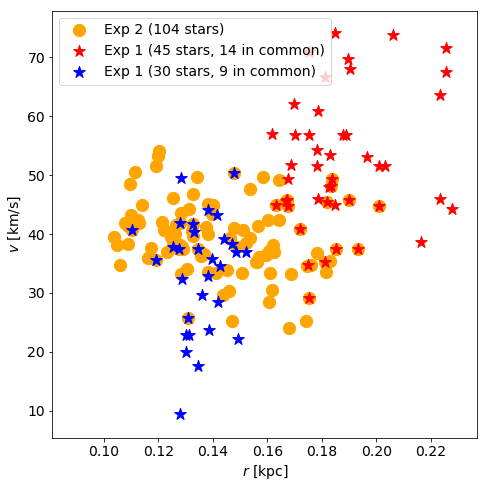

In [1379]:
fig = p.figure(figsize=(7,7))
line1 = ds.scatter('sqrt(x**2+y**2+z**2)', 'sqrt(vx**2+vy**2+vz**2)', s=150, marker='o', c='orange', selection='exp2==213')
line2 = ds.scatter('sqrt(x**2+y**2+z**2)', 'sqrt(vx**2+vy**2+vz**2)', s=150, marker='*', c='red', selection='exp1==202')
line3 = ds.scatter('sqrt(x**2+y**2+z**2)', 'sqrt(vx**2+vy**2+vz**2)', s=150, marker='*', c='blue', selection='exp1==205')
p.legend([line1, line2, line3], ['Exp 2 (104 stars)', 'Exp 1 (45 stars, 14 in common)', 'Exp 1 (30 stars, 9 in common)'], \
         loc='upper left')
p.xlabel(r'$r$ [kpc]'), p.ylabel(r'$v$ [km/s]')
# p.xlim(-80,120), p.ylim(-170,-60)
fig.tight_layout()
p.savefig('/net/virgo01/data/users/virgini/rockstar/RC3/output/parent-child-21-vel.png', format='png')
p.show()

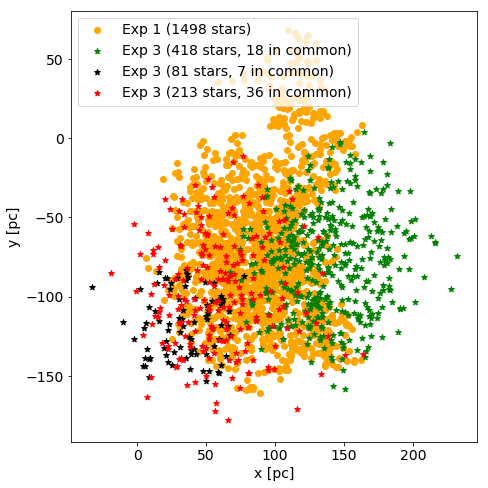

In [1351]:
fig = p.figure(figsize=(7,7))
line1 = ds.scatter('x_pc', 'y_pc', marker='o', c='orange', selection='exp1==208')
line2 = ds.scatter('x_pc', 'y_pc', marker='*', c='green', selection='exp3==32')
line3 = ds.scatter('x_pc', 'y_pc', marker='*', c='black', selection='exp3==18')
line4 = ds.scatter('x_pc', 'y_pc', marker='*', c='red', selection='exp3==29')
p.legend([line1, line2, line3, line4], \
         ['Exp 1 (1498 stars)', 'Exp 3 (418 stars, 18 in common)', 'Exp 3 (81 stars, 7 in common)', 'Exp 3 (213 stars, 36 in common)']\
         , loc='upper left')
p.xlabel('x [pc]'), p.ylabel('y [pc]')
# p.xlim(-80,120), p.ylim(-170,-60)
fig.tight_layout()
p.savefig('/net/virgo01/data/users/virgini/rockstar/RC3/output/parent-child-13.png', format='png')
p.show()

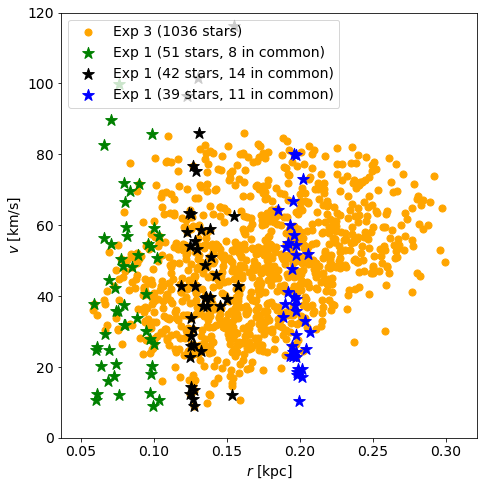

In [1385]:
fig = p.figure(figsize=(7,7))
line1 = ds.scatter('sqrt(x**2+y**2+z**2)', 'sqrt(vx**2+vy**2+vz**2)', s=50, marker='o', c='orange', selection='exp3==9')
line2 = ds.scatter('sqrt(x**2+y**2+z**2)', 'sqrt(vx**2+vy**2+vz**2)', s=150, marker='*', c='green', selection='exp1==92')
line3 = ds.scatter('sqrt(x**2+y**2+z**2)', 'sqrt(vx**2+vy**2+vz**2)', s=150, marker='*', c='black', selection='exp1==232')
line4 = ds.scatter('sqrt(x**2+y**2+z**2)', 'sqrt(vx**2+vy**2+vz**2)', s=150, marker='*', c='blue', selection='exp1==238')
p.legend([line1, line2, line3, line4], ['Exp 3 (1036 stars)', 'Exp 1 (51 stars, 8 in common)', \
         'Exp 1 (42 stars, 14 in common)', 'Exp 1 (39 stars, 11 in common)'], loc='upper left')
p.xlabel('x [pc]'), p.ylabel('y [pc]')
p.xlabel(r'$r$ [kpc]'), p.ylabel(r'$v$ [km/s]')
p.ylim(0,120)
fig.tight_layout()
p.savefig('/net/virgo01/data/users/virgini/rockstar/RC3/output/parent-child-13-vel.png', format='png')
p.show()

In [ ]:
nsub = len(unique(ds.evaluate('exp1', selection='exp1>=0')))
# nstar = ds.selected_length(selection='exp1>=0')

In [ ]:
nsub, nstar

In [ ]:
# Number of substructure in total
a = len(unique(ds.evaluate('exp1', selection='exp1>=0')))
b = len(unique(ds.evaluate('exp2', selection='exp2>=0')))
c = len(unique(ds.evaluate('exp3', selection='exp3>=0')))
d = len(unique(ds.evaluate('exp4', selection='exp4>=0')))
a+b+c+d

In [1391]:
dm.to_astropy_table(selection='flag==4.17')

flag,n_star,x_med,y_med,z_med,l,b,d,r,a,size,vel,vr,std_vr,pm_l,std_pm_l,pm_b,std_pm_b,met,met_std
float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
4.17,33,-0.0582475342297,-0.133624076016,-0.121967542906,-113.552675201,-40.3084850212,0.188540780044,0.110356212006,0.0583180667252,32.7512376495,3.00666239864,8.21942,4.58329,-4.80593118807,2.71235348304,-16.6515104943,4.85752160337,-0.21129,0.258815


In [ ]:
n=100000
a = 0.3
b = 0.6
th = random.randn(n)
x = a*exp(b*th)*cos(th)
y = a*exp(b*th)*sin(th)
p.plot(x,y,"*")
p.show()

In [ ]:
pca = PCA(n_components=3, svd_solver='full')

xx  = random.random(size=100)
yy  = random.random(size=100)
zz  = random.random(size=100)

XX = array([xx,yy,zz]).T
tras = pca.fit_transform(XX)

p.scatter(tras[:,0], tras[:,1])
p.show()

# Fit: create priciple axis on the basis of the velocities
pca.fit(vv)
# transform: convert the velocities to the principle axis coordinates
v_pca = pca.transform(vv)
# transform: convert the positions to the principle axis coordinates
r_pca = pca.transform(rr)
